## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_3params as n_counts_simulator
#importlib.reload(n_counts_simulator)

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.020, 0.6])
upper = np.array([0.1275, 0.024, 1.1])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76])
n_params = len(theta_fiducial)

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [7]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_3params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_3params.py'>

In [8]:
N_countsSimulator = n_counts_simulator.Model()

N_countsSimulator.N_counts

total: 0.9774756 s


array([1.78485558e+04, 5.76970955e+04, 7.91959673e+04, 7.60280551e+04,
       5.88513395e+04, 2.53149917e+03, 6.50857065e+03, 6.79905624e+03,
       4.77690342e+03, 2.60821304e+03, 1.41326957e+02, 2.40973379e+02,
       1.54407659e+02, 6.19686706e+01, 1.80224732e+01, 1.15792928e+00,
       8.97137339e-01, 2.22002922e-01, 2.95445872e-02, 2.45078214e-03])

In [9]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [10]:
N_countsSimulator.n_counts_trapz(theta_fiducial, 0.1, 0.2, 14.0, 14.5)

computing cosmo: 0.00023506799999939432 s
computing halo mass function object: 0.1304091619999994 s
computing factors: 0.12022083699999975 s
loop over z_steps: 0.037579280000000104 s


17848.555764027973

In [11]:
N_countsSimulator.n_counts_trapz_all(theta_fiducial, z_min, z_max, log10masses)

total: 0.9877216099999995 s


array([1.78485558e+04, 5.76970955e+04, 7.91959673e+04, 7.60280551e+04,
       5.88513395e+04, 2.53149917e+03, 6.50857065e+03, 6.79905624e+03,
       4.77690342e+03, 2.60821304e+03, 1.41326957e+02, 2.40973379e+02,
       1.54407659e+02, 6.19686706e+01, 1.80224732e+01, 1.15792928e+00,
       8.97137339e-01, 2.22002922e-01, 2.95445872e-02, 2.45078214e-03])

In [12]:
N_countsSimulator.N_counts.shape

(20,)

In [13]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [14]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [15]:
N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data

array([[17720, 57628, 78955, 75947, 58462],
       [ 2499,  6606,  6684,  4733,  2579],
       [  140,   228,   173,    55,    15],
       [    1,     0,     0,     1,     0]])

## Define ensemble of NDEs

In [16]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=20, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [17]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(20), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results/")

## Sequential Neural Likelihood

In [21]:
n_initial = 10 #200
n_batch = 20 #200
n_populations = 5 #20

total: 0.9941969870000023 s
total: 0.9916416310000002 s
total: 0.9999856330000014 s
total: 0.9924541910000002 s
total: 0.9893218389999987 s
total: 0.9919203269999954 s
total: 0.989618851000003 s
total: 1.001281726000002 s
total: 0.9971087589999996 s
total: 0.9927667299999996 s


Population 1/5
Sampling proposal density...
Done.


total: 0.9548094880000235 s
total: 0.9512701499999991 s
total: 0.953984136999992 s
total: 0.9565130539999984 s
total: 0.9523778089999837 s
total: 0.9517362960000071 s
total: 0.9559055999999941 s
total: 0.9521892799999989 s
total: 0.953579891000004 s
total: 0.957807712999994 s
total: 0.9531560370000136 s
total: 0.9558073130000082 s
total: 0.954604340000003 s
total: 0.9533475839999994 s
total: 0.9553285929999902 s
total: 0.9591000570000006 s
total: 0.9582830100000024 s
total: 0.9520667589999903 s
total: 0.956960209000016 s
total: 0.9553617359999862 s


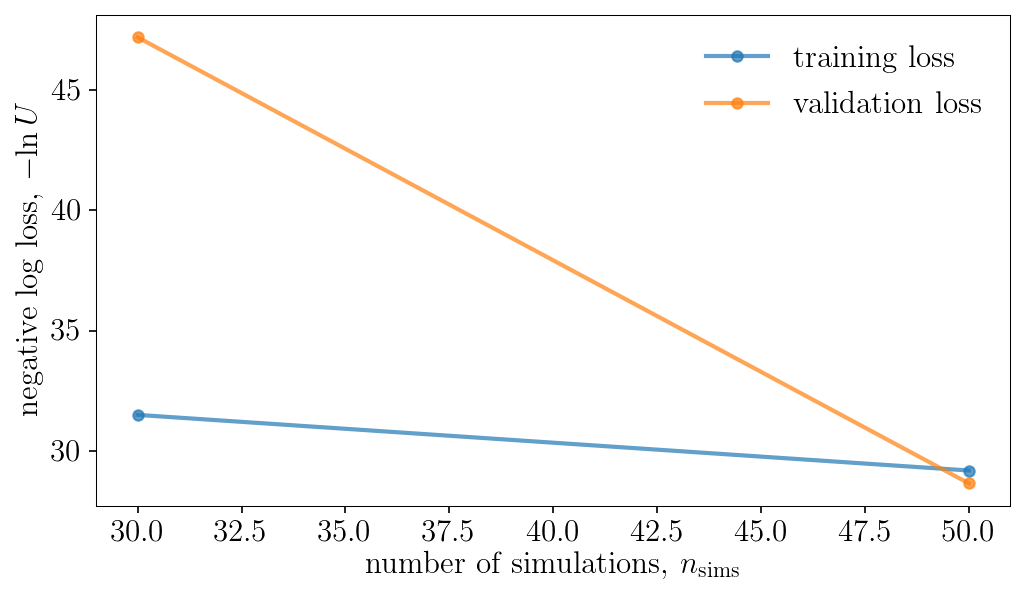

Population 2/5
Sampling proposal density...
Done.


total: 0.9463501289999954 s
total: 0.9620802050000066 s
total: 0.9444237629999748 s
total: 0.9497593009999719 s
total: 0.9491445799999951 s
total: 0.9634931909999978 s
total: 0.9442064159999859 s
total: 0.9435372309999934 s
total: 0.9445266319999632 s
total: 0.9665954669999905 s
total: 0.945679087999963 s
total: 0.9425653779999834 s
total: 0.9443746960000112 s
total: 0.9690291279999883 s
total: 0.9503981800000361 s
total: 0.9480956909999918 s
total: 0.9448303190000047 s
total: 0.962844500000017 s
total: 0.9443738589999953 s
total: 0.9437538180000047 s


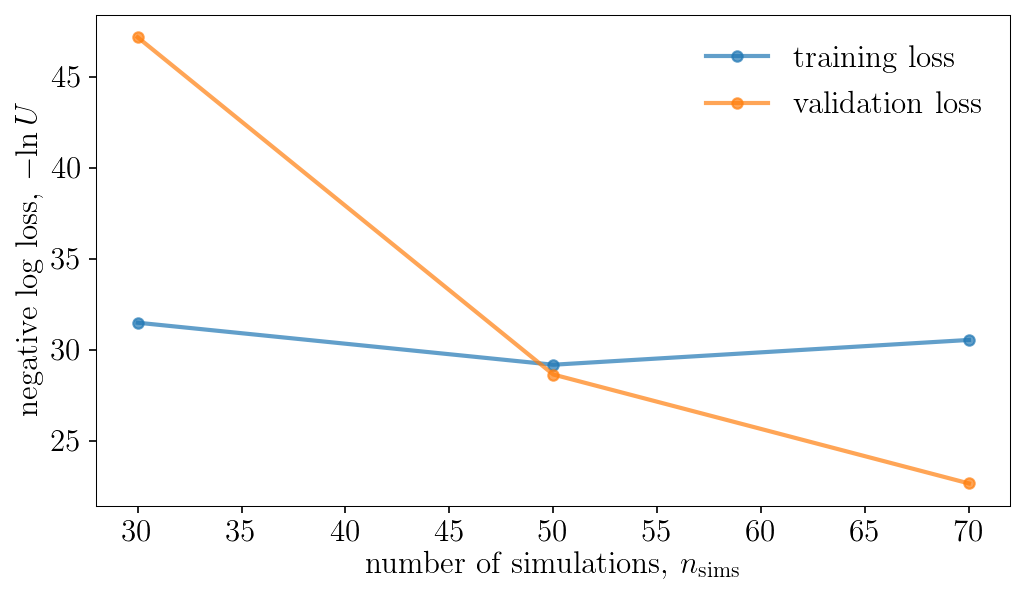

Population 3/5
Sampling proposal density...
Done.


total: 0.946178280999959 s
total: 0.9461290670000153 s
total: 0.9433094980000192 s
total: 0.9469829679999862 s
total: 0.9506974730000479 s
total: 0.9493477679999955 s
total: 0.9431879839999624 s
total: 0.9460387039999887 s
total: 0.9416685639999969 s
total: 0.9422095819999754 s
total: 0.9432182890000149 s
total: 0.9479242840000097 s
total: 0.9454887879999774 s
total: 0.9492149519999771 s
total: 0.9453802090000067 s
total: 0.9439385080000307 s
total: 0.9420948329999987 s
total: 0.9405252180000048 s
total: 0.9450116079999589 s
total: 0.9473208730000238 s


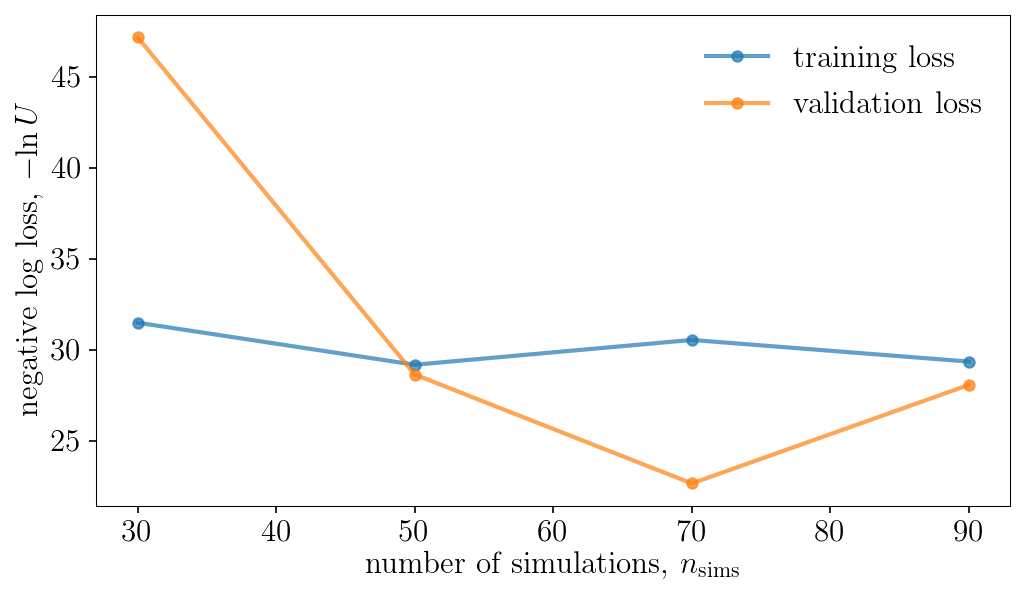

Population 4/5
Sampling proposal density...
Done.


total: 0.9458494499999688 s
total: 0.9477436690000332 s
total: 0.9533931590000293 s
total: 0.9548482449999938 s
total: 0.9520334520000233 s
total: 0.9455945969999675 s
total: 0.944613559000004 s
total: 0.9447908780000489 s
total: 0.9450018759999921 s
total: 0.9466780740000331 s
total: 0.9445247179999114 s
total: 0.9516451559999268 s
total: 0.9415458900000431 s
total: 0.9463189159999956 s
total: 0.9447619400000349 s
total: 0.9436012620000156 s
total: 0.9416174940000701 s
total: 0.9527602980000438 s
total: 0.9487954489999311 s
total: 0.9464315540000143 s


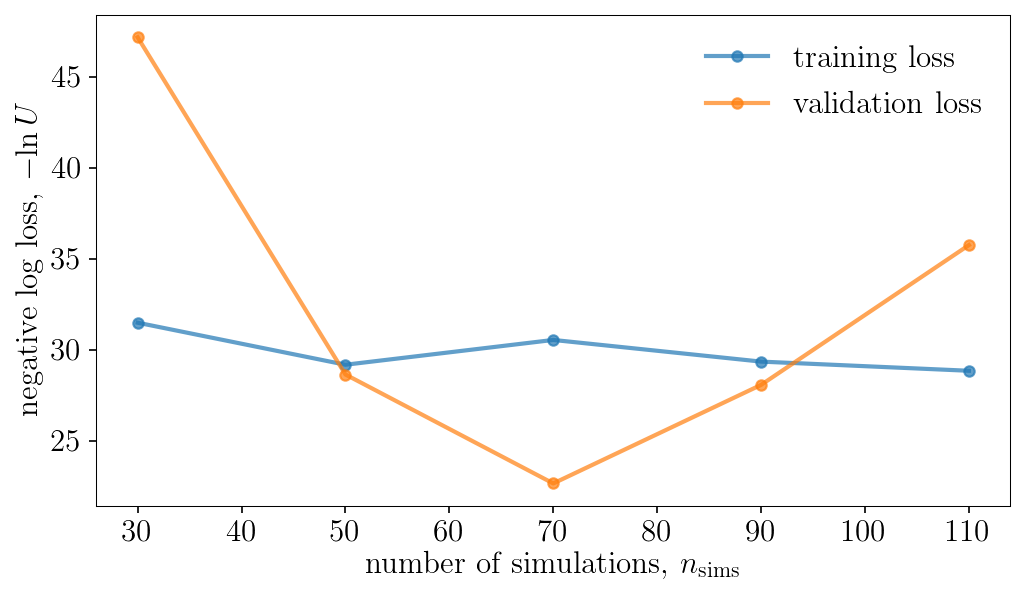

Population 5/5
Sampling proposal density...
Done.


total: 0.9544479220000994 s
total: 0.9480739159999985 s
total: 0.9488484280000193 s
total: 0.9454402269999491 s
total: 0.9472968400000354 s
total: 0.953233282000042 s
total: 0.9514196610000454 s
total: 0.9473563220000187 s
total: 0.9427612879999288 s
total: 0.9439148230000001 s
total: 0.9462952169999426 s
total: 0.9494091889999936 s
total: 0.953105058999995 s
total: 0.9459868639999058 s
total: 0.9449572789999365 s
total: 0.9480775480000148 s
total: 0.950550964999934 s
total: 0.9462342650000437 s
total: 0.9505055250000396 s
total: 0.9446285770000031 s


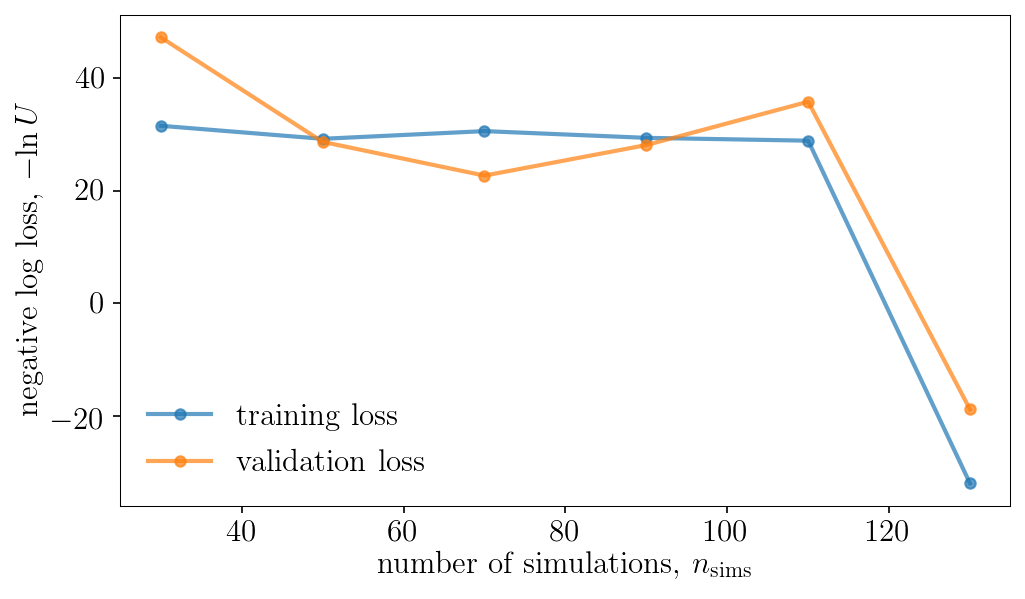

In [22]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

In [ ]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

## Sample the learned posterior

In [23]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


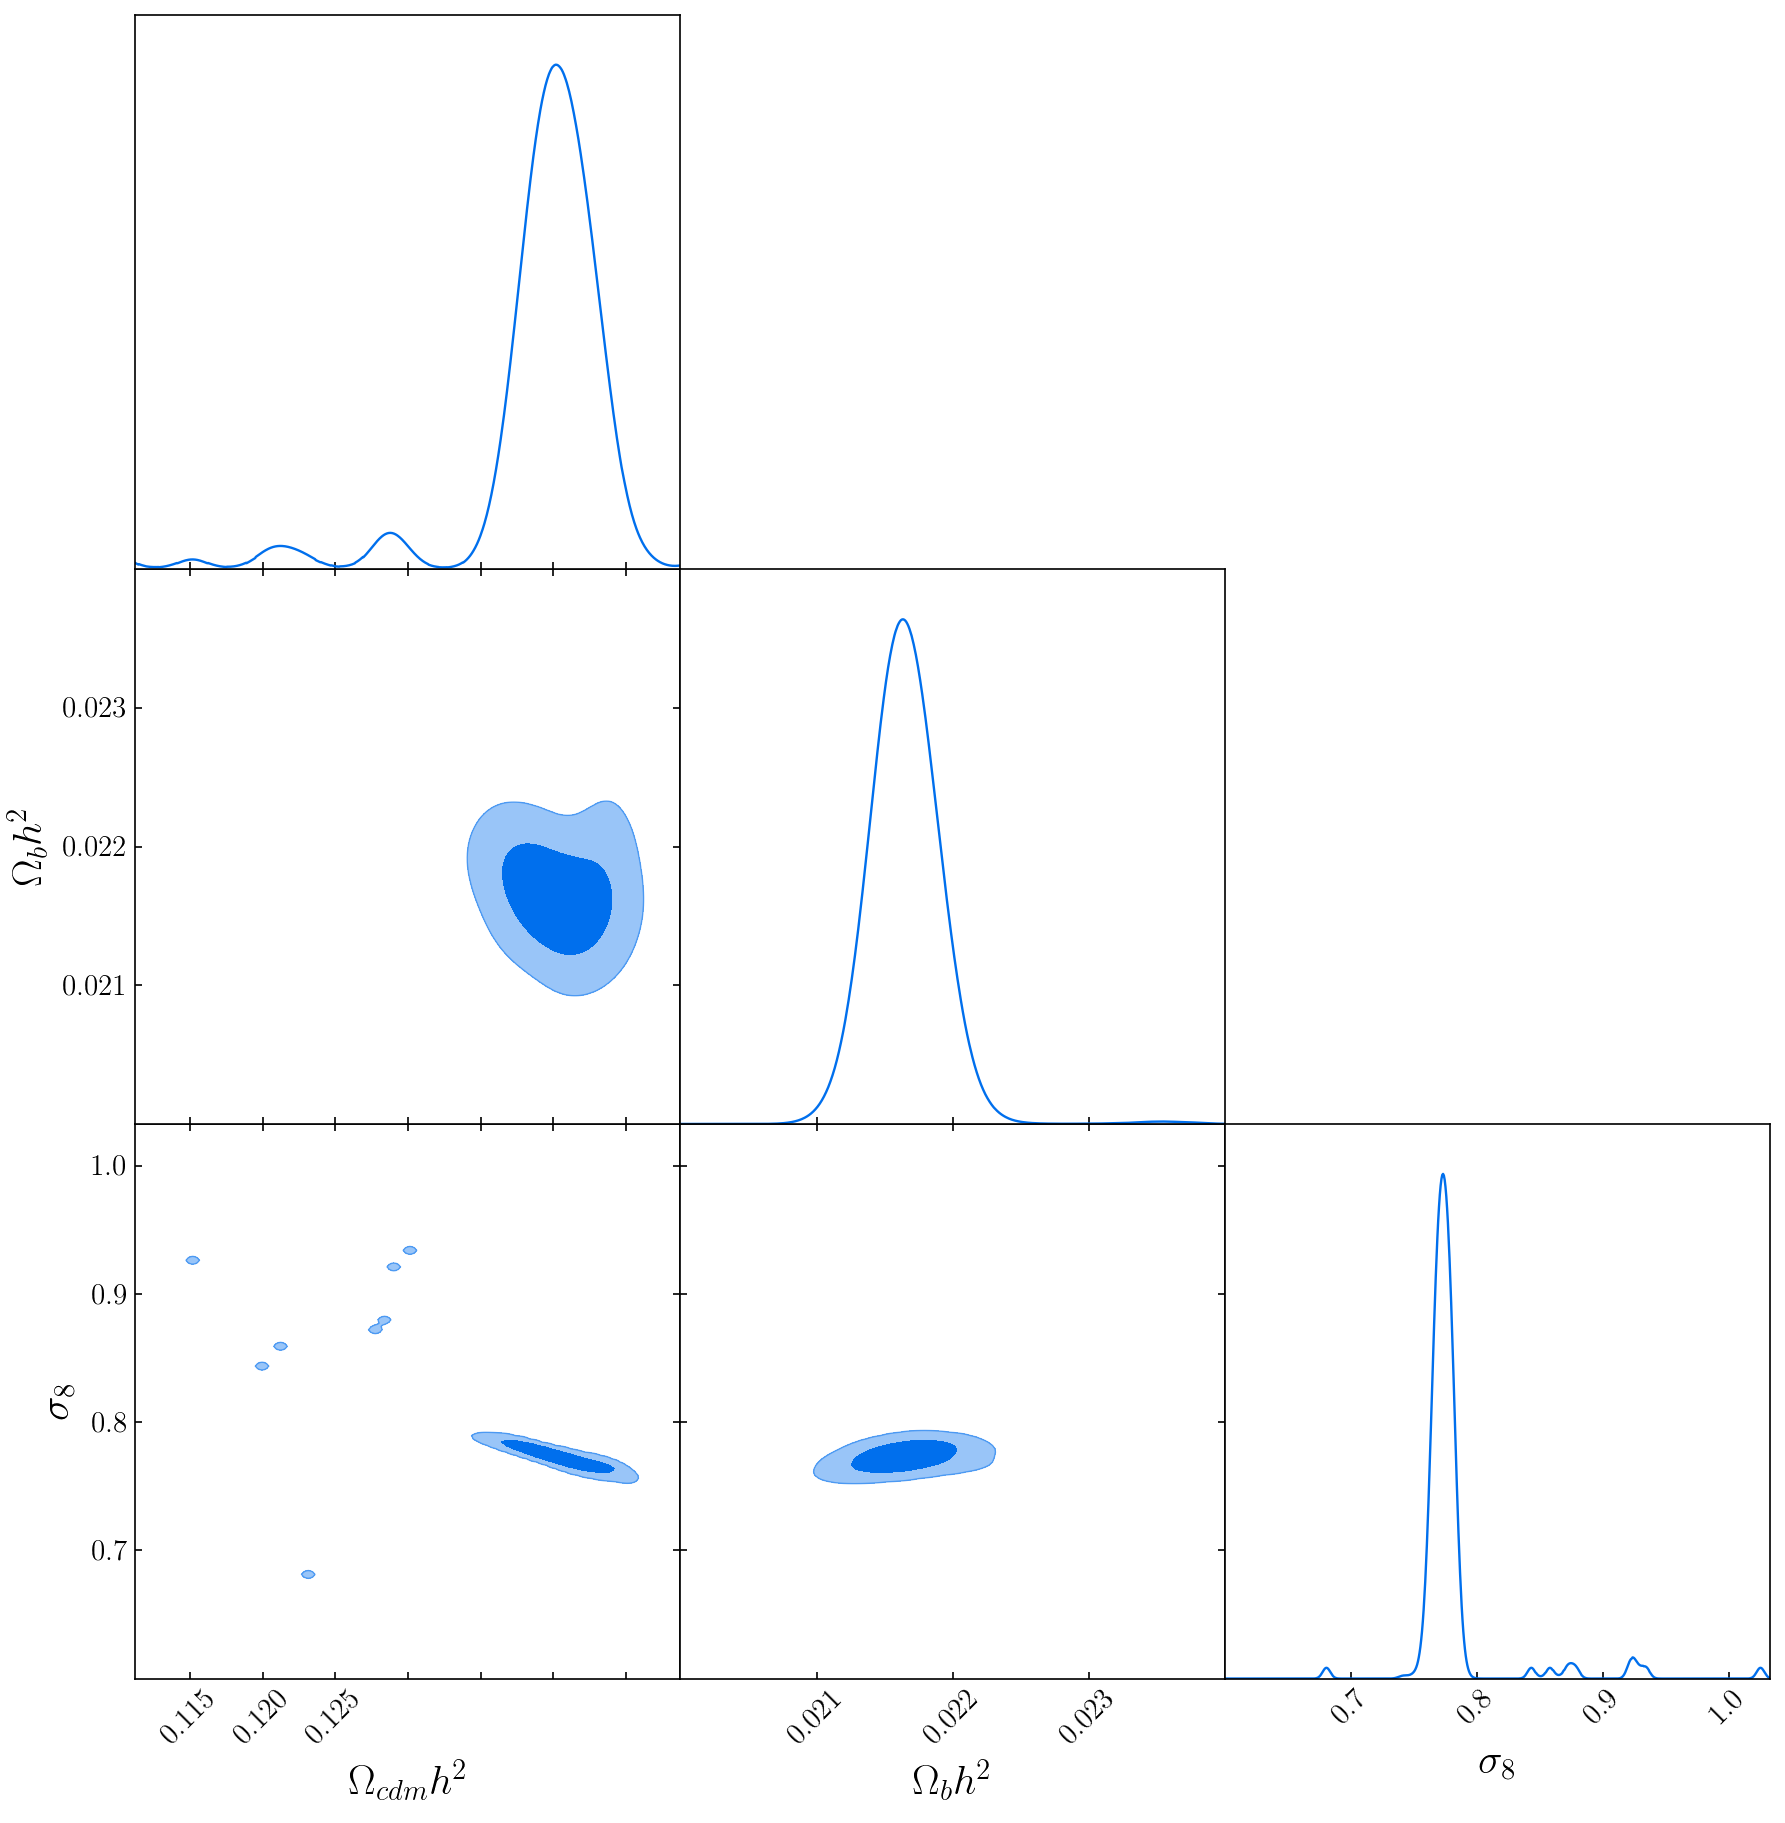

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

<Figure size 900x600 with 0 Axes>

In [24]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])
plt.savefig('posteriors_3params.jpg')

## Attempt 2

In [18]:
DelfiEnsemble2 = delfi.Delfi(N_counts_data.reshape(20), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_3params_200sims/")

In [19]:
n_initial = 20 #200
n_batch = 10 #200
n_populations = 20 #20

total: 0.9977757650000001 s
total: 0.9992964740000012 s
total: 0.9956806110000009 s
total: 0.9933078920000007 s
total: 0.9974454629999983 s
total: 0.9847537089999996 s
total: 0.9924147790000006 s
total: 0.9864449460000024 s
total: 0.9910641679999976 s
total: 0.9979478569999998 s
total: 0.9882910570000014 s
total: 0.9906885810000041 s
total: 0.9899615100000005 s
total: 0.9906155100000049 s
total: 0.9959788029999999 s
total: 0.9906670829999982 s
total: 0.9992406050000042 s
total: 0.9886362539999993 s
total: 0.9913446730000004 s
total: 1.0024827559999991 s


Sampling approximate posterior...
Done.
Removed no burn in


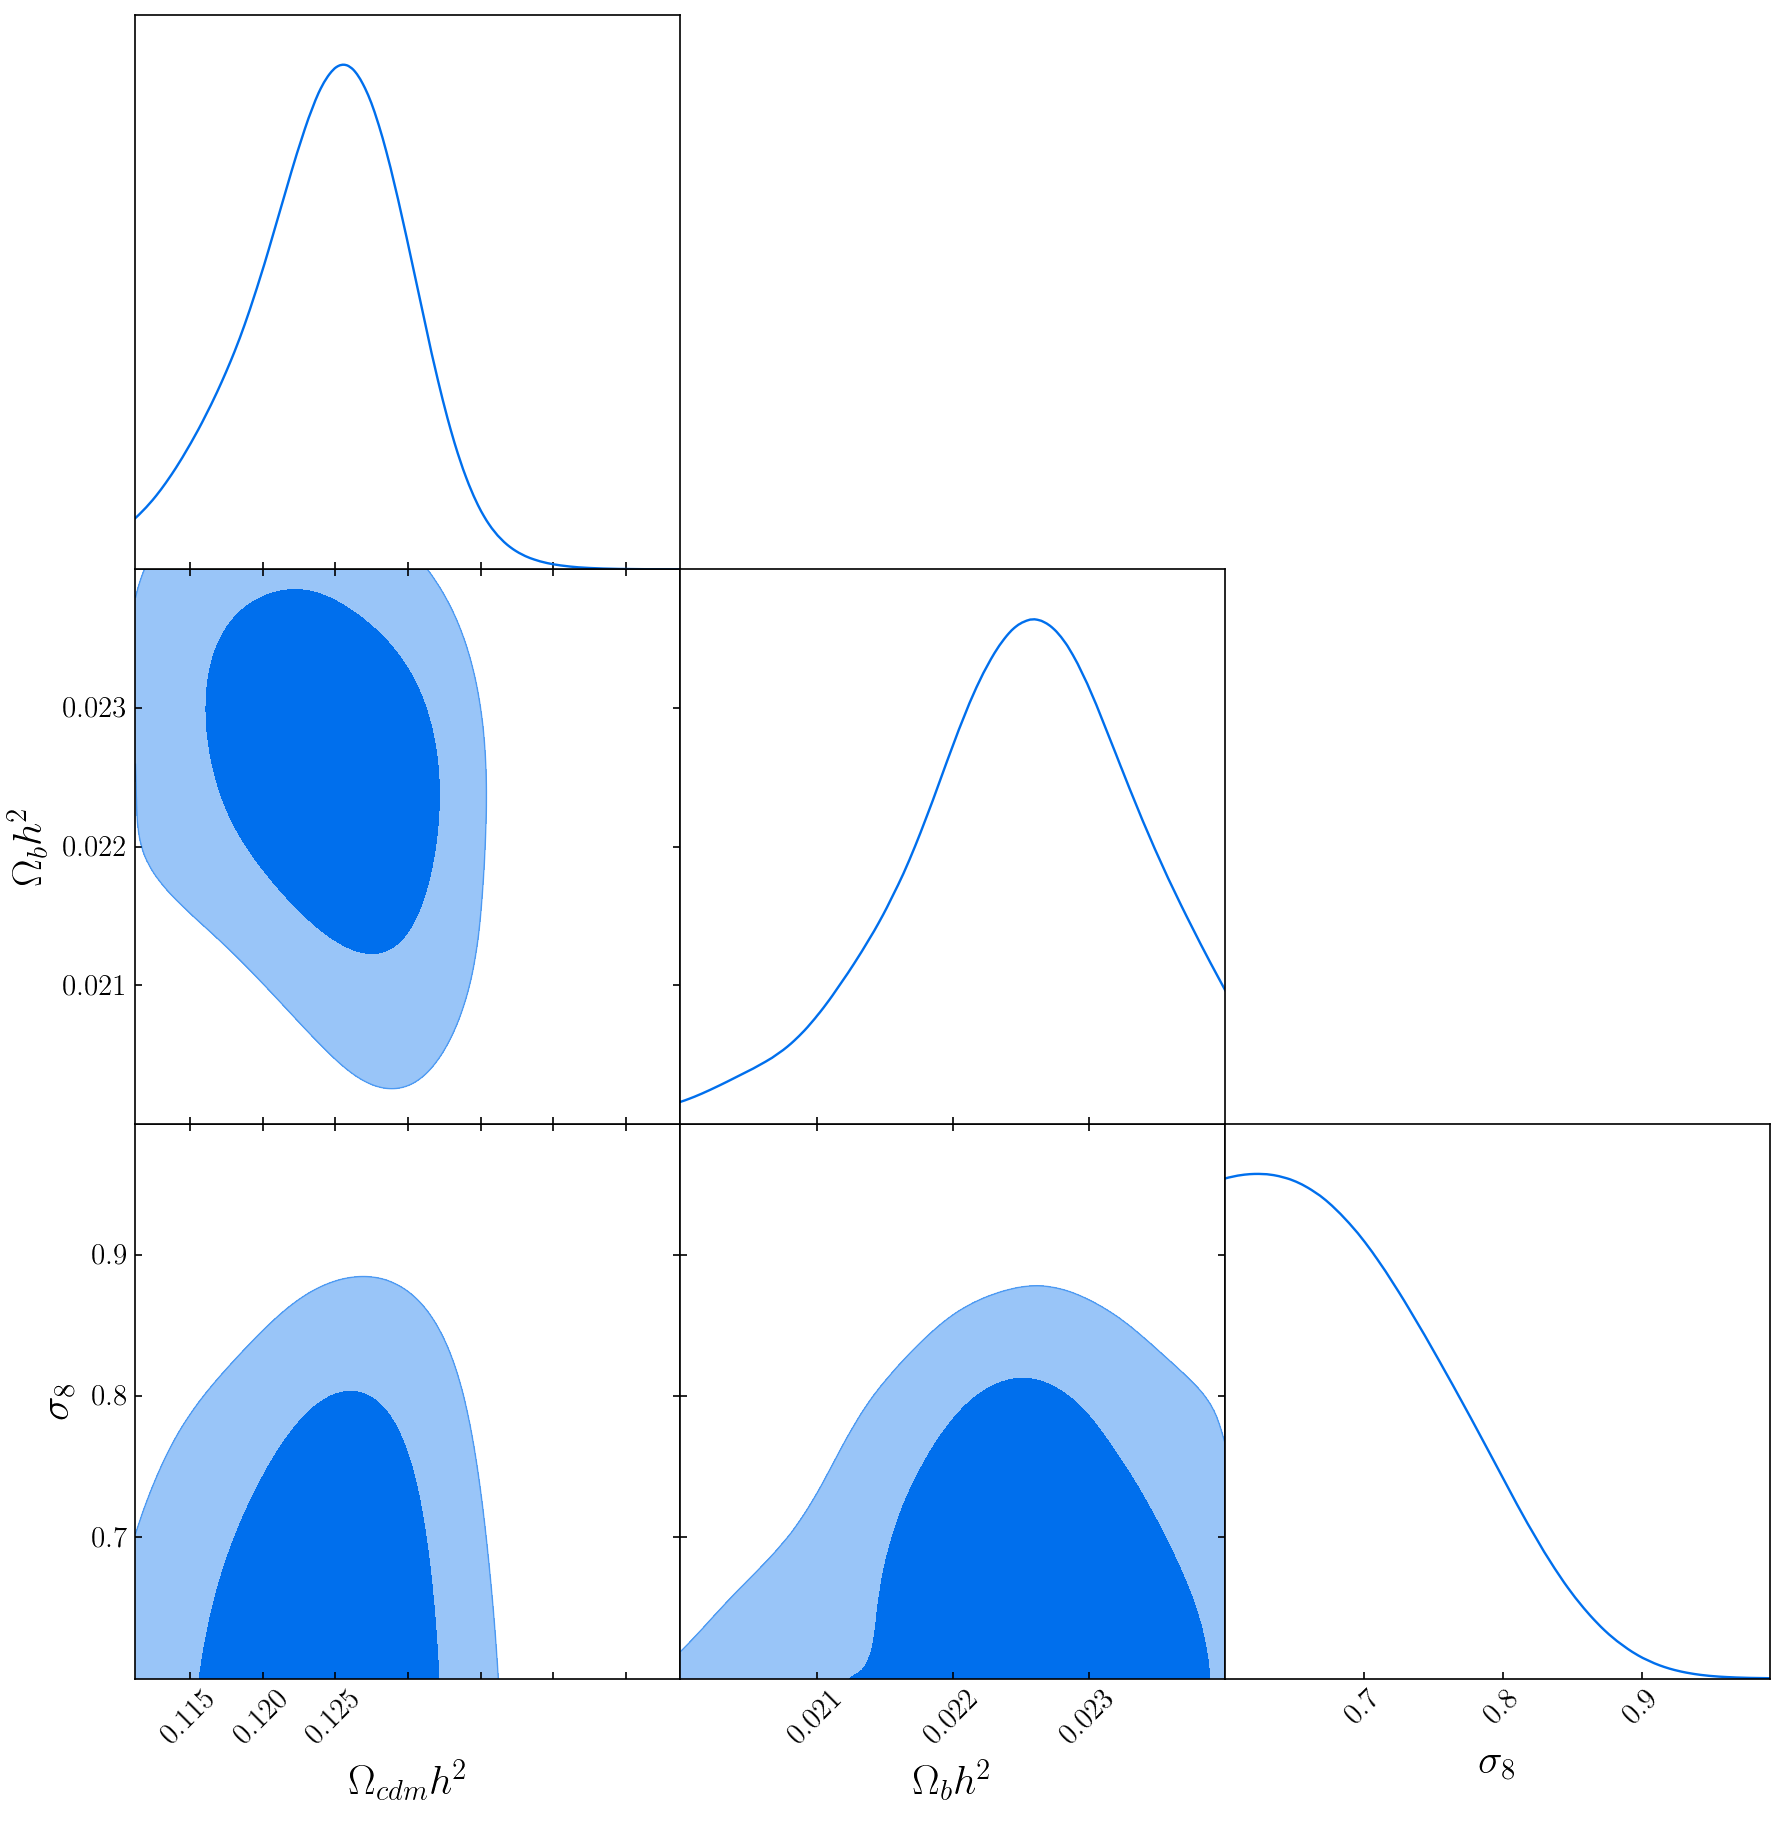

Population 1/20
Sampling proposal density...
Done.


total: 0.9900724240000045 s
total: 0.9895741249999901 s
total: 0.9915277490000562 s
total: 0.9852441599999793 s
total: 0.9864871280000216 s
total: 0.9869120300000986 s
total: 0.9835702830000628 s
total: 0.992226225999957 s
total: 0.9850278239999852 s
total: 0.9841915569999173 s


Sampling approximate posterior...
Done.
Removed no burn in


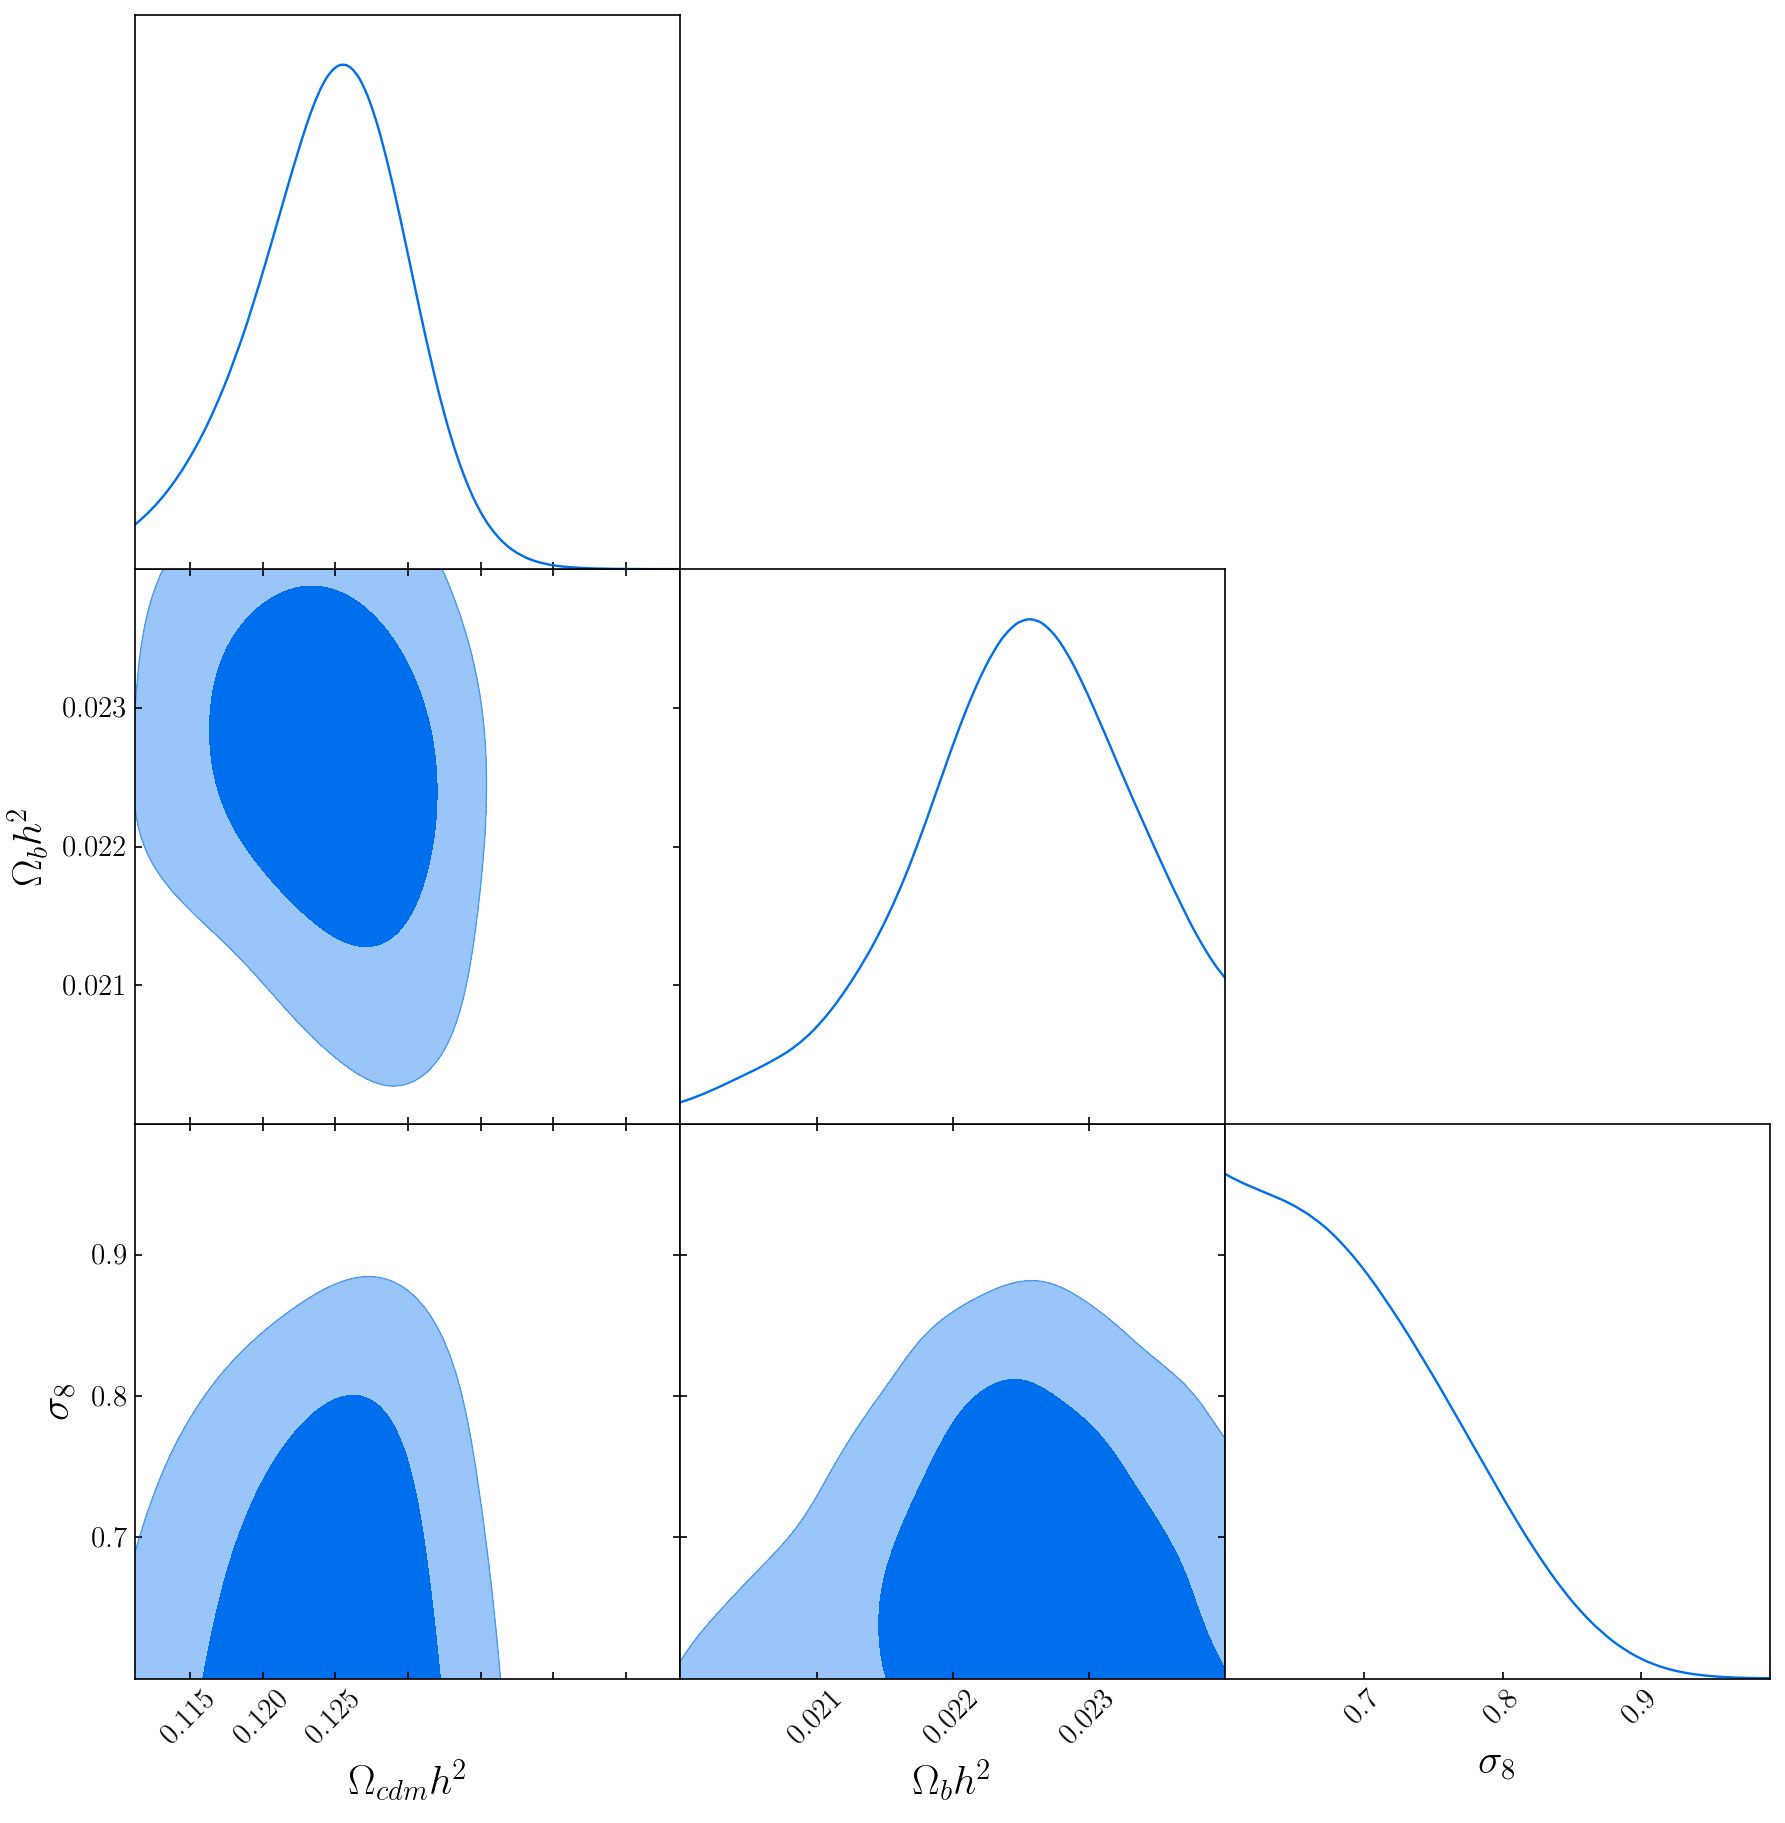

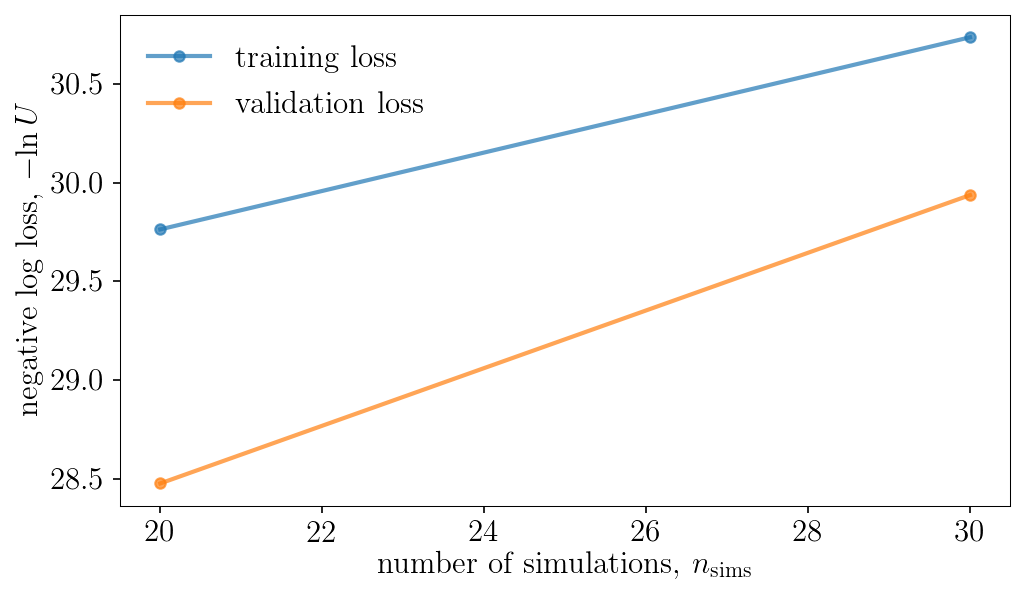

Population 2/20
Sampling proposal density...
Done.


total: 0.9980636689999756 s
total: 0.9899237270001322 s
total: 0.9891989010000088 s
total: 0.9920007120001628 s
total: 1.011096933999852 s
total: 0.9937400109999999 s
total: 0.991071040000179 s
total: 0.9909088060001068 s
total: 0.9932429660000253 s
total: 0.9898718430001736 s


Sampling approximate posterior...
Done.
Removed no burn in


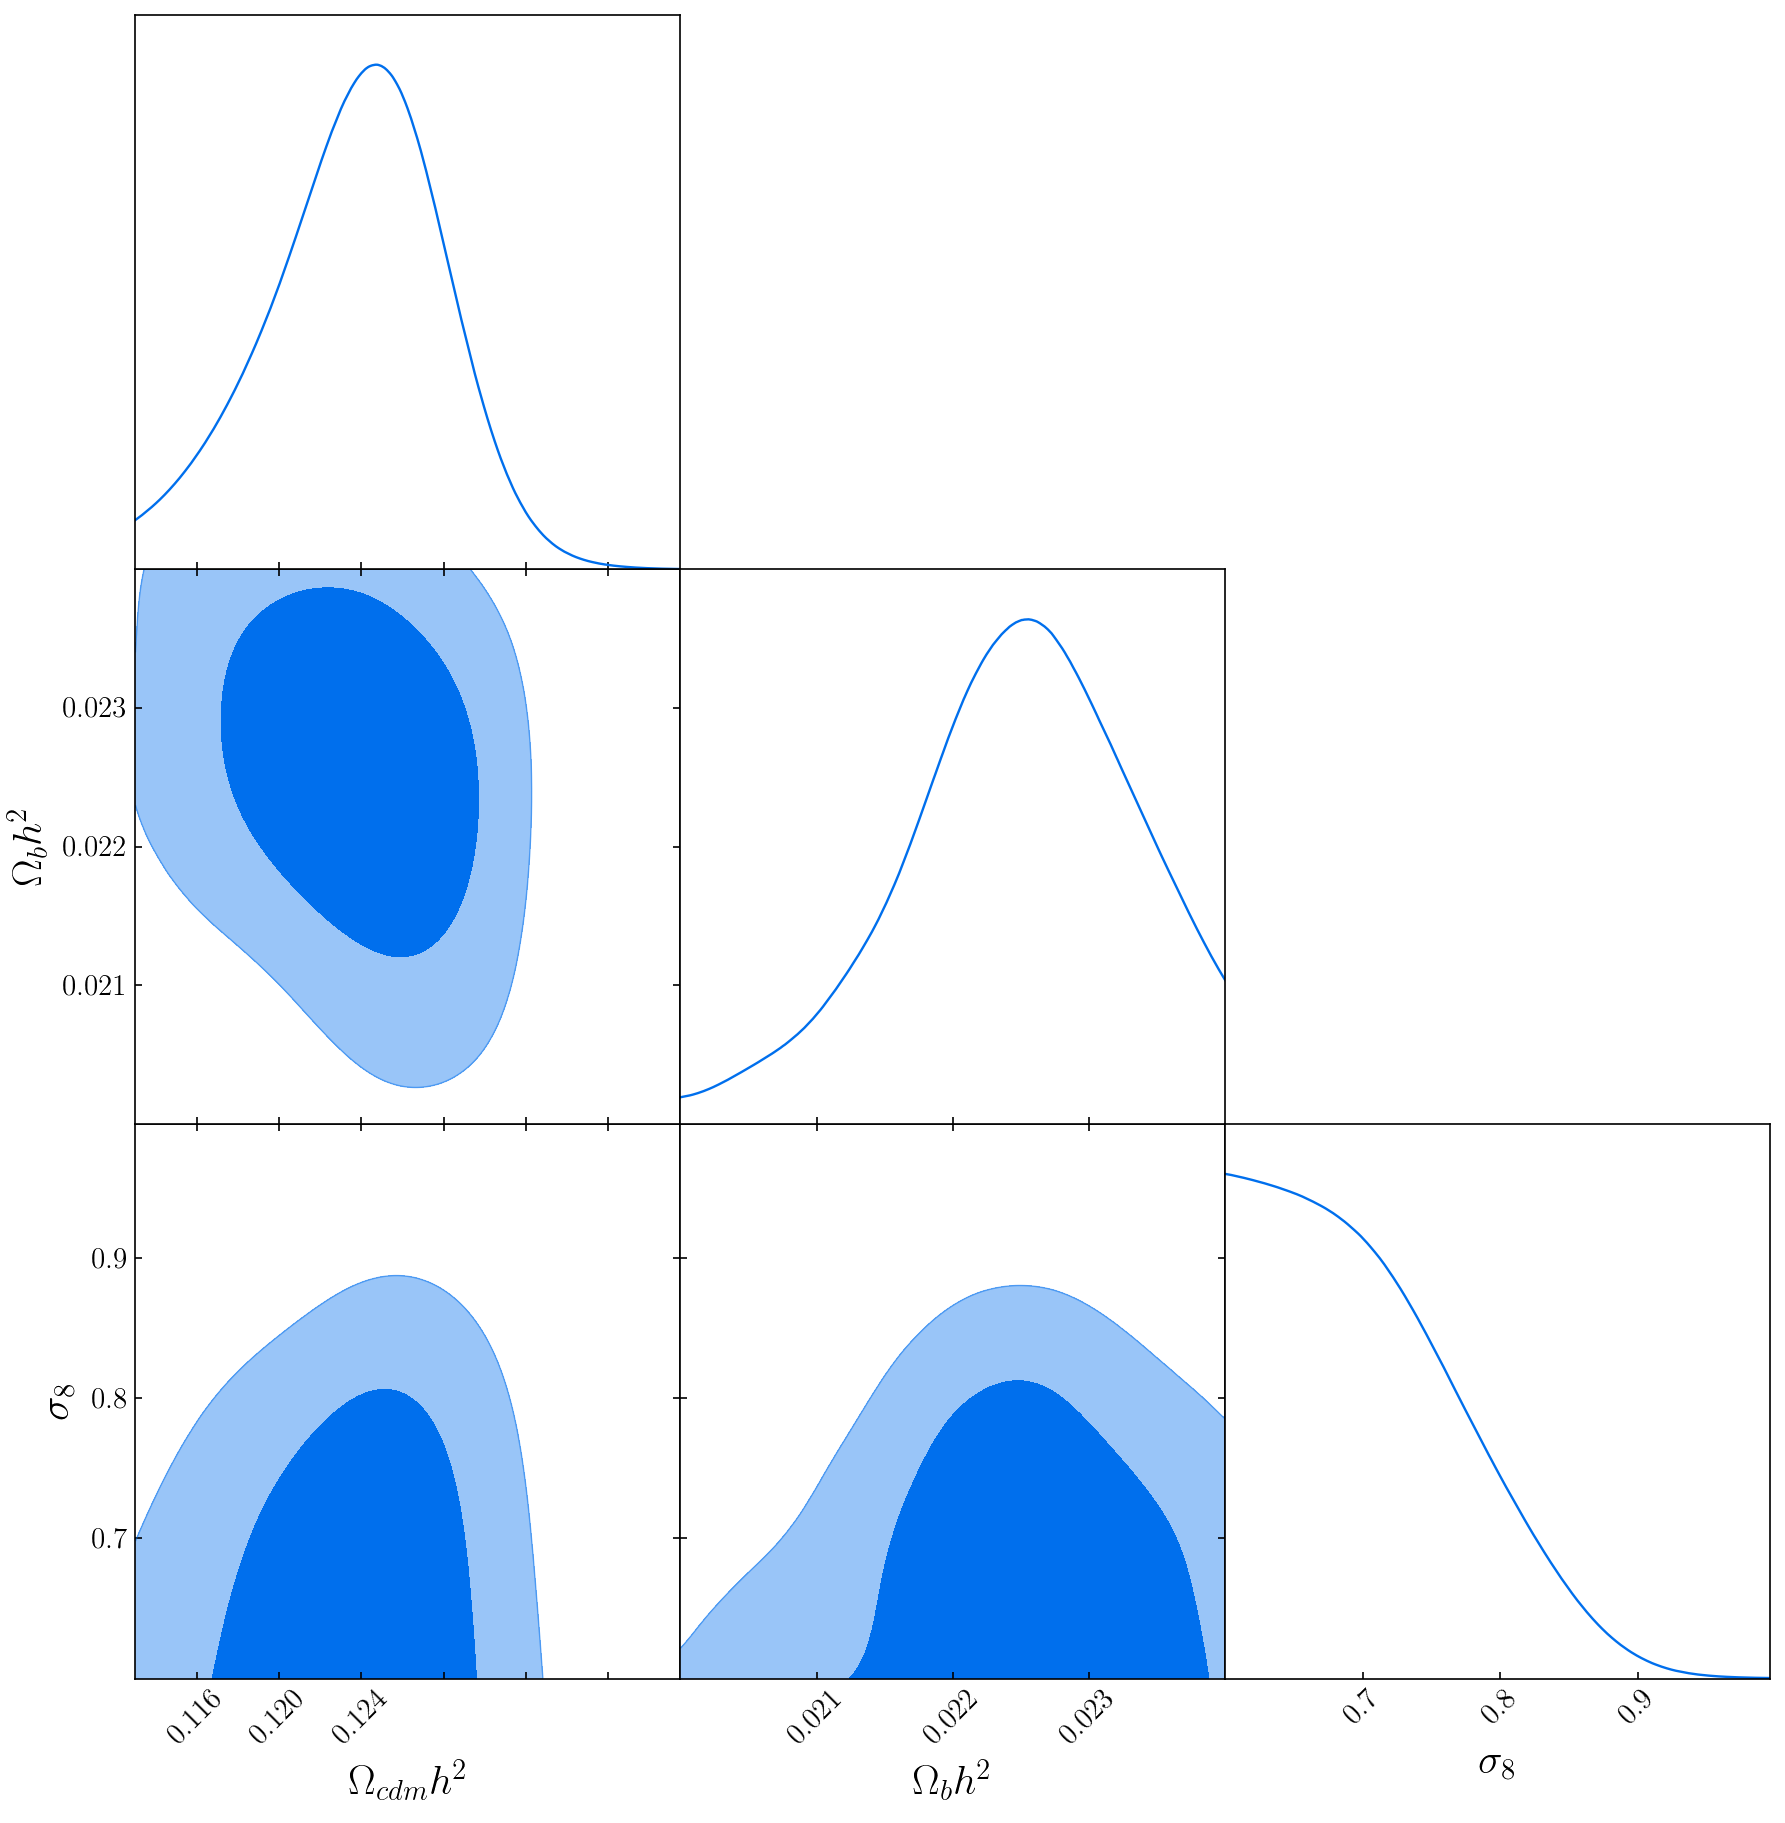

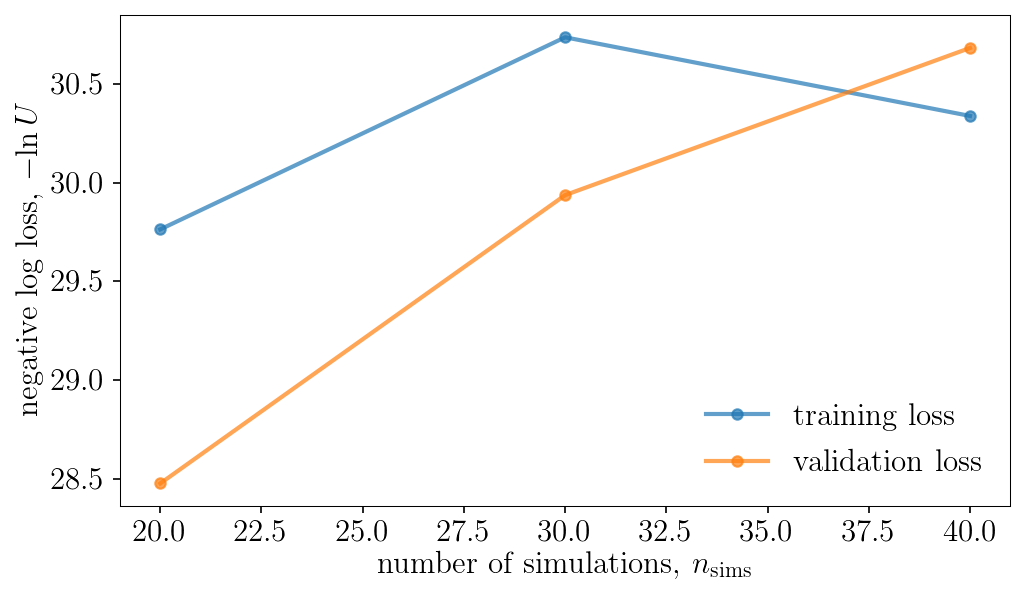

Population 3/20
Sampling proposal density...
Done.


total: 1.0013550380001561 s
total: 0.9975954989999991 s
total: 0.9981215170000723 s
total: 0.9975121949998993 s
total: 1.001452011000083 s
total: 0.9962223879999783 s
total: 0.9989822580000691 s
total: 0.9981721090000519 s
total: 0.998421209000071 s
total: 0.9969192660000772 s


Sampling approximate posterior...
Done.
Removed no burn in


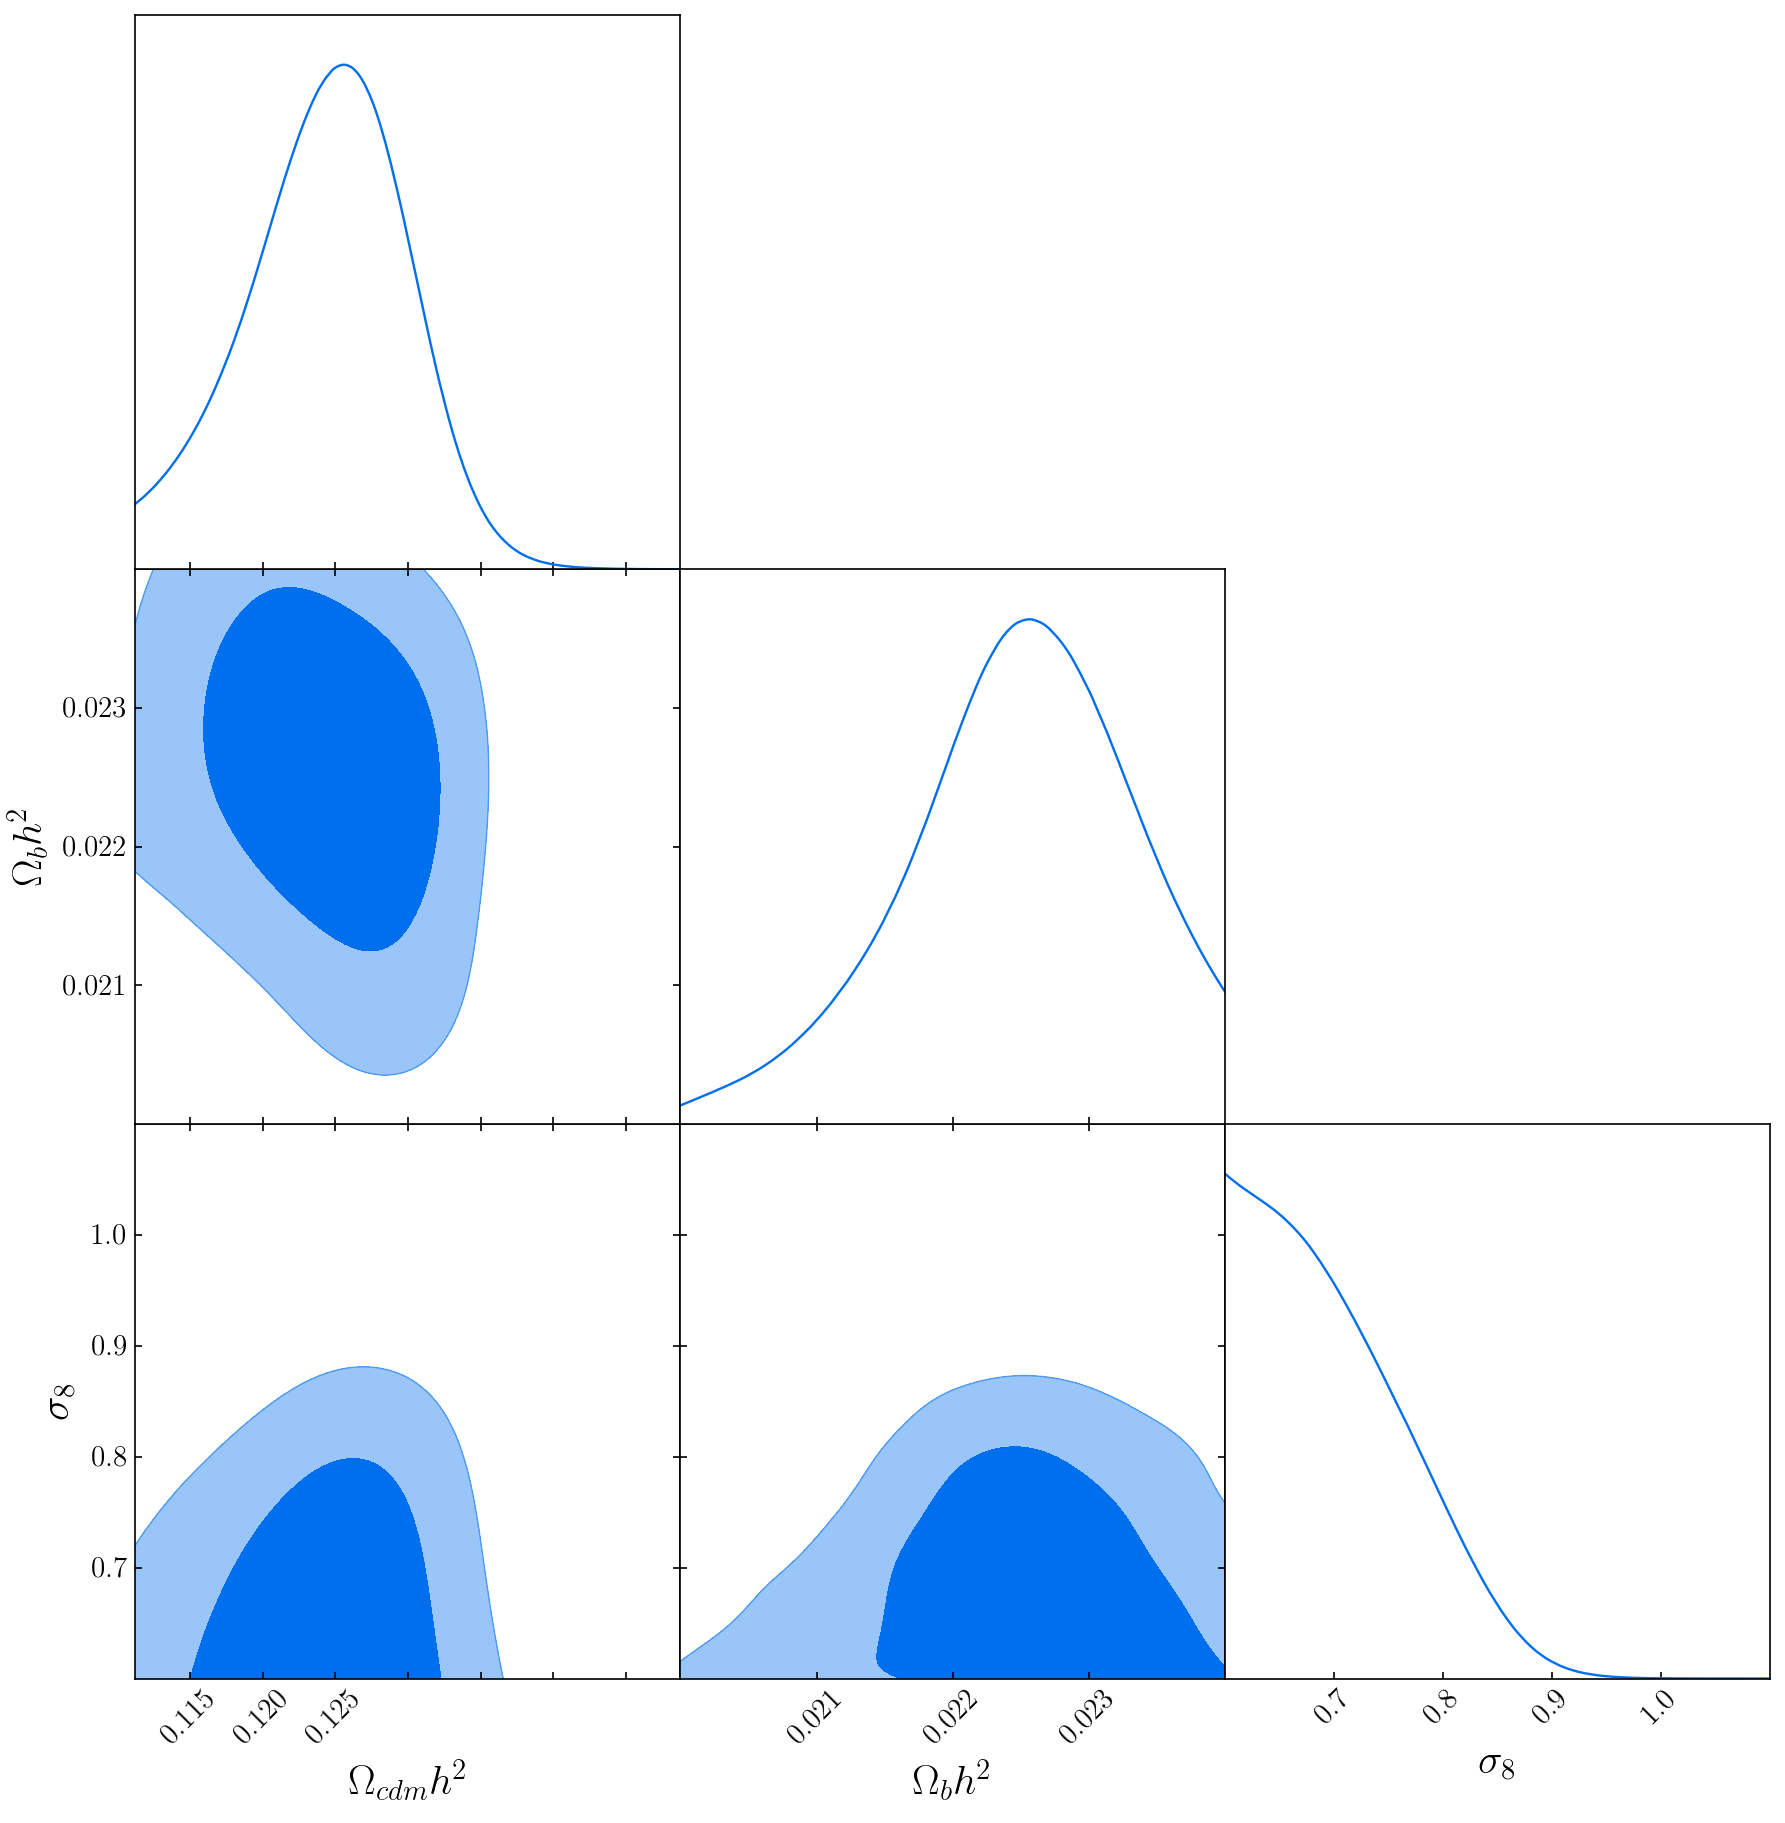

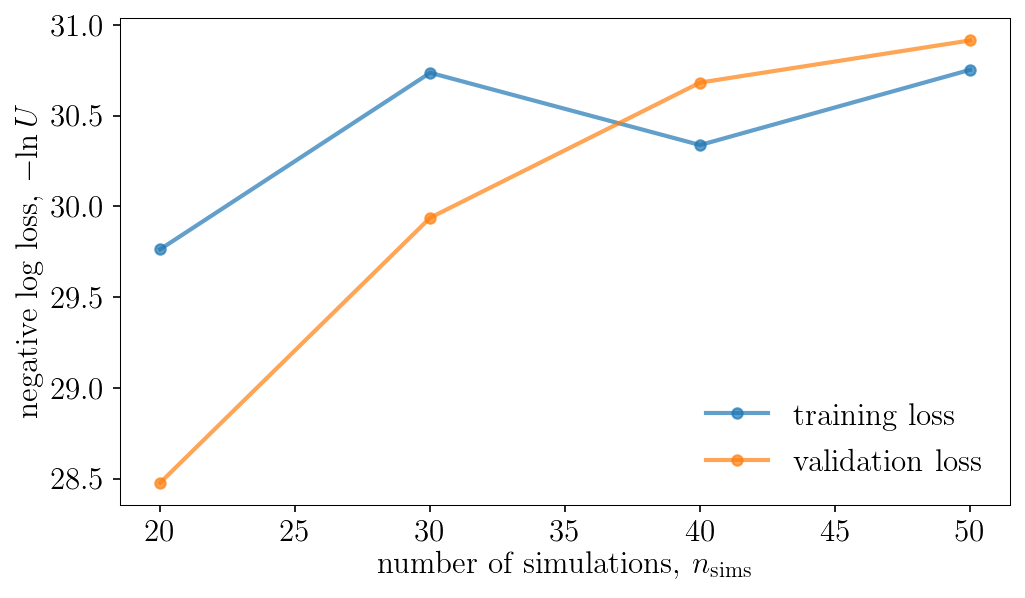

Population 4/20
Sampling proposal density...
Done.


total: 1.0052936190004402 s
total: 1.001273496000067 s
total: 1.0003015460001734 s
total: 0.9902753239998674 s
total: 0.9866573720000815 s
total: 0.9840922630000932 s
total: 0.987732713999776 s
total: 0.9854108590002397 s
total: 1.001384612000038 s
total: 0.9941093080001338 s


Sampling approximate posterior...
Done.
Removed no burn in


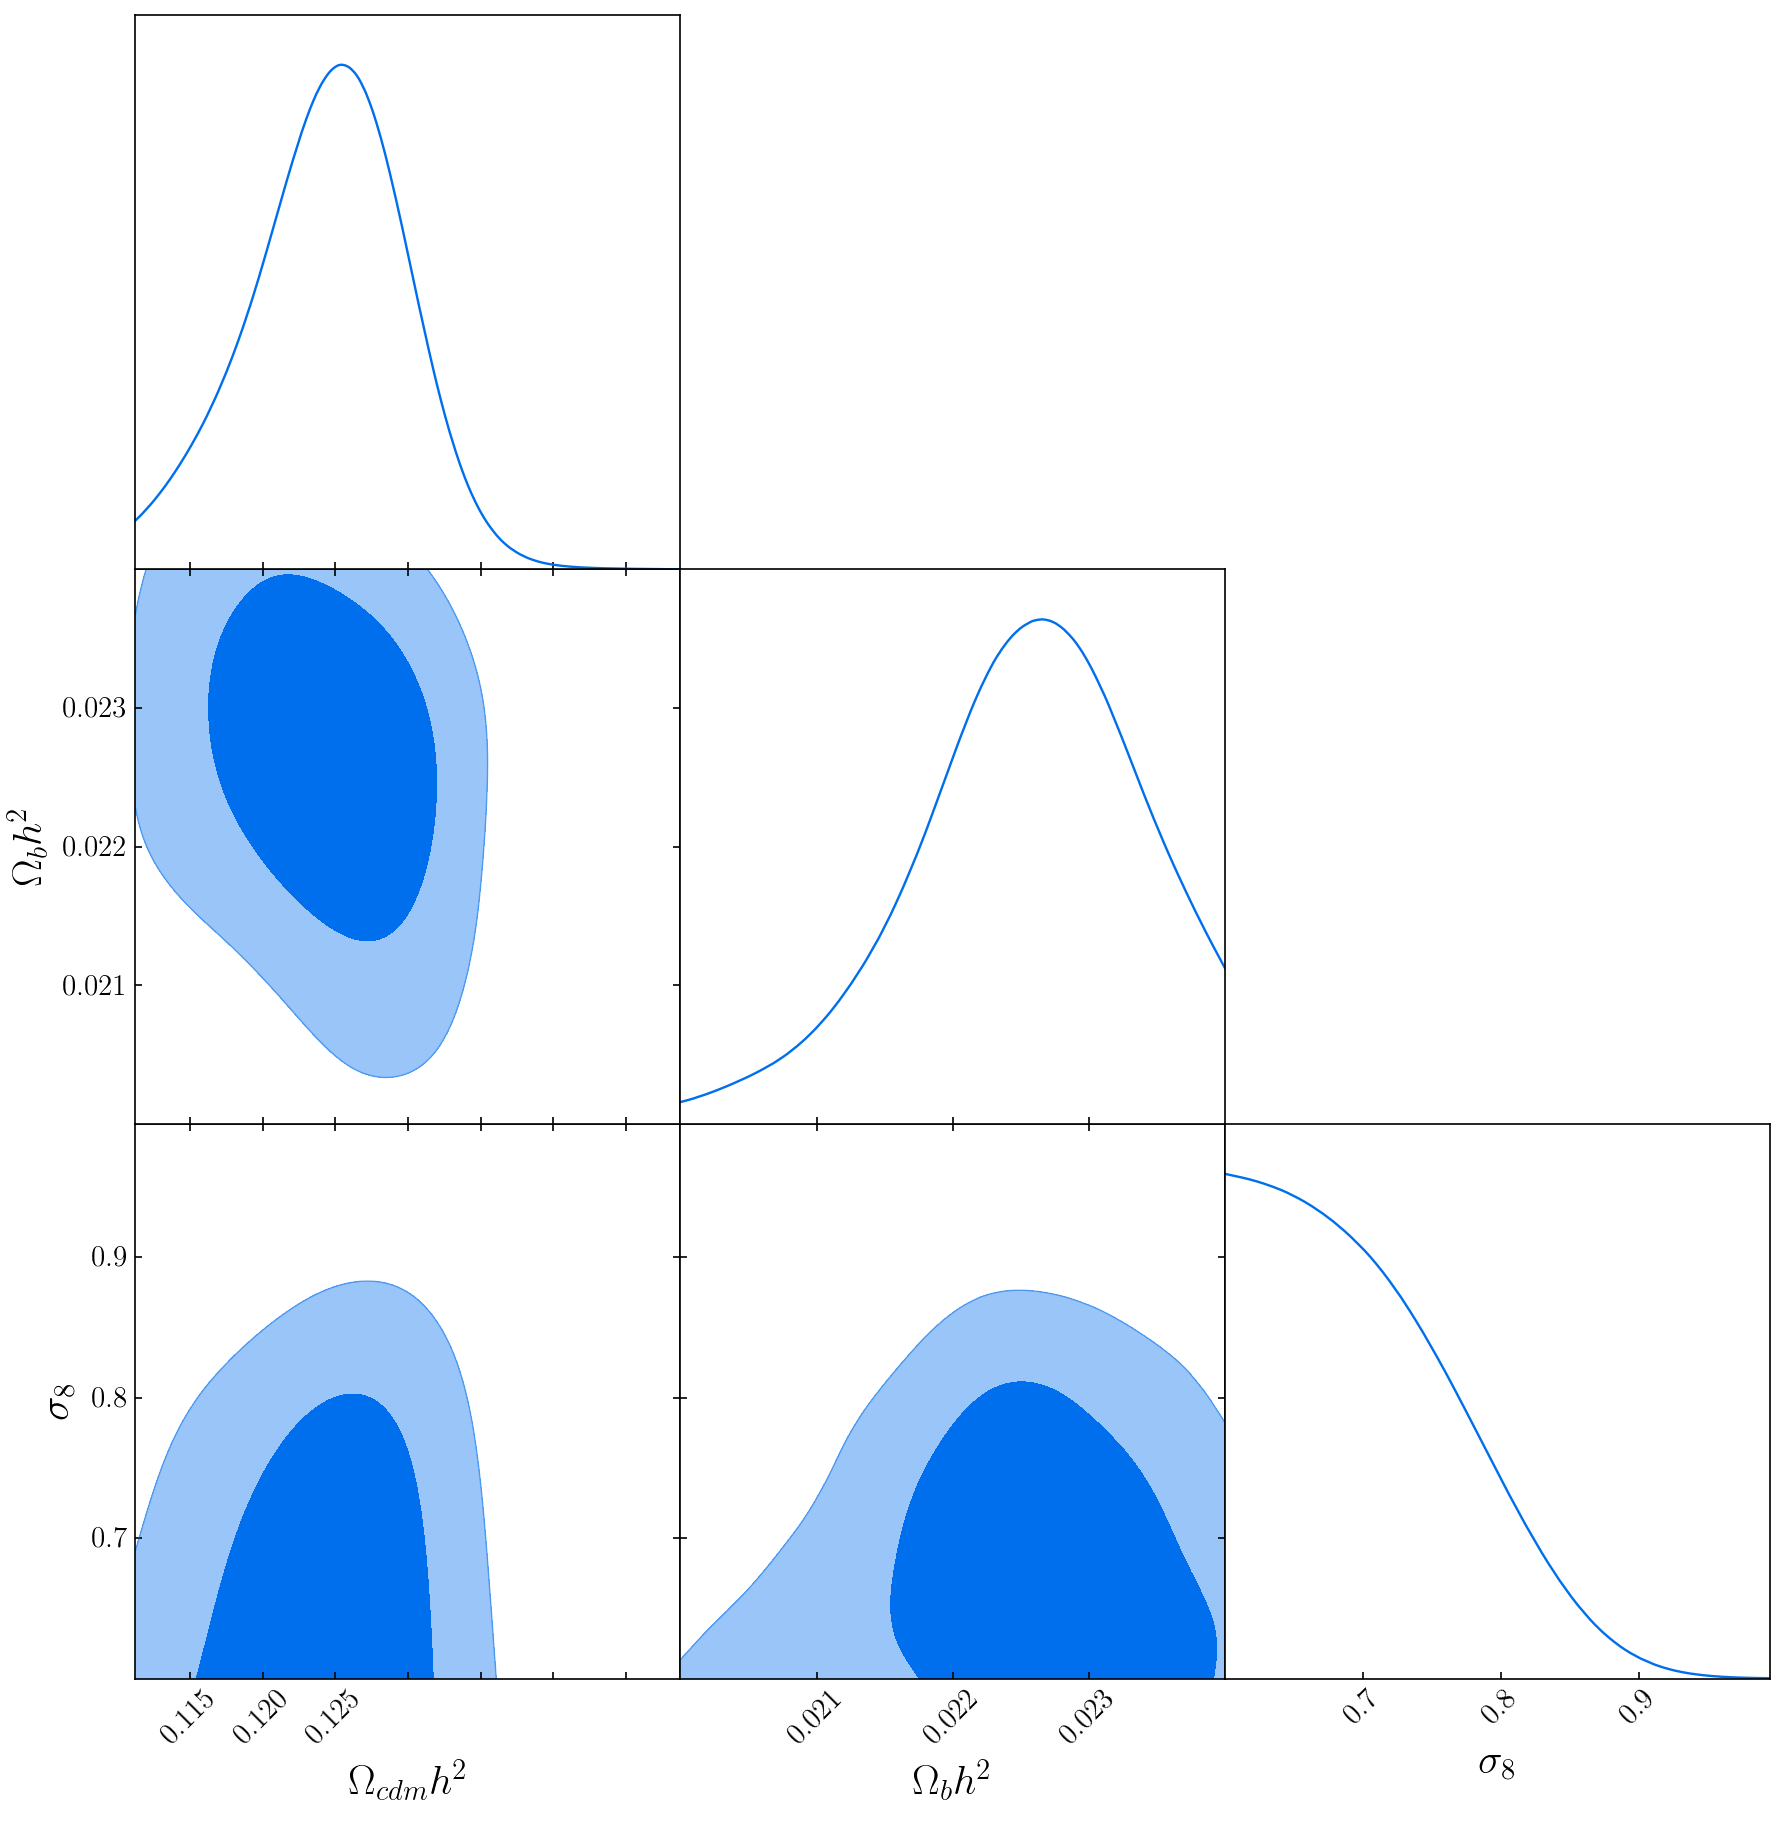

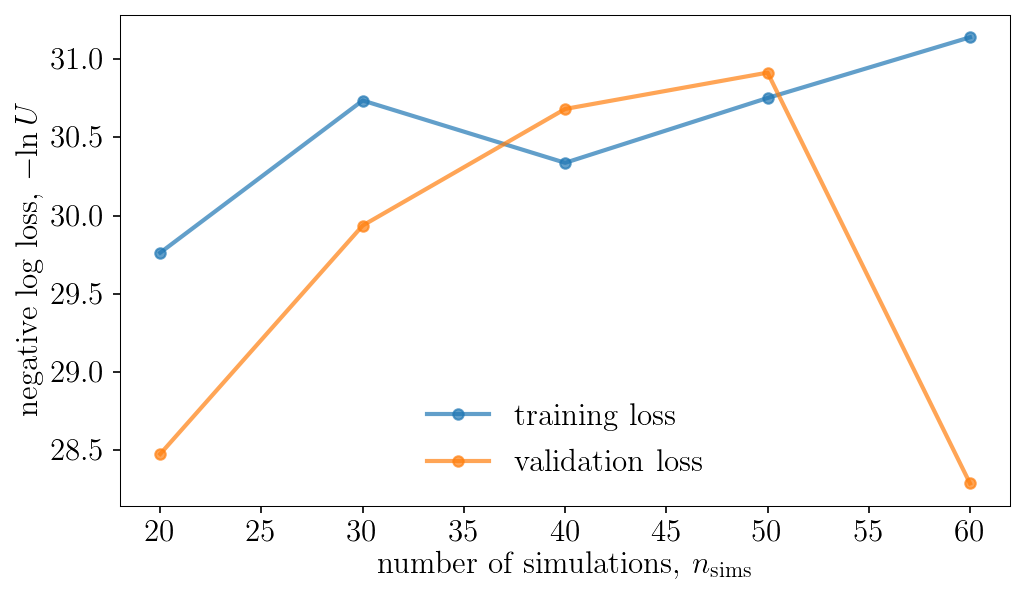

Population 5/20
Sampling proposal density...
Done.


total: 0.9945586029998594 s
total: 0.995713682999849 s
total: 0.9926699280003959 s
total: 0.9861969319999844 s
total: 0.9792671770001107 s
total: 0.9804485310000928 s
total: 0.9773376339999231 s
total: 0.9814510719997998 s
total: 0.9783151199999338 s
total: 0.9784069319998707 s


Sampling approximate posterior...
Done.
Removed no burn in


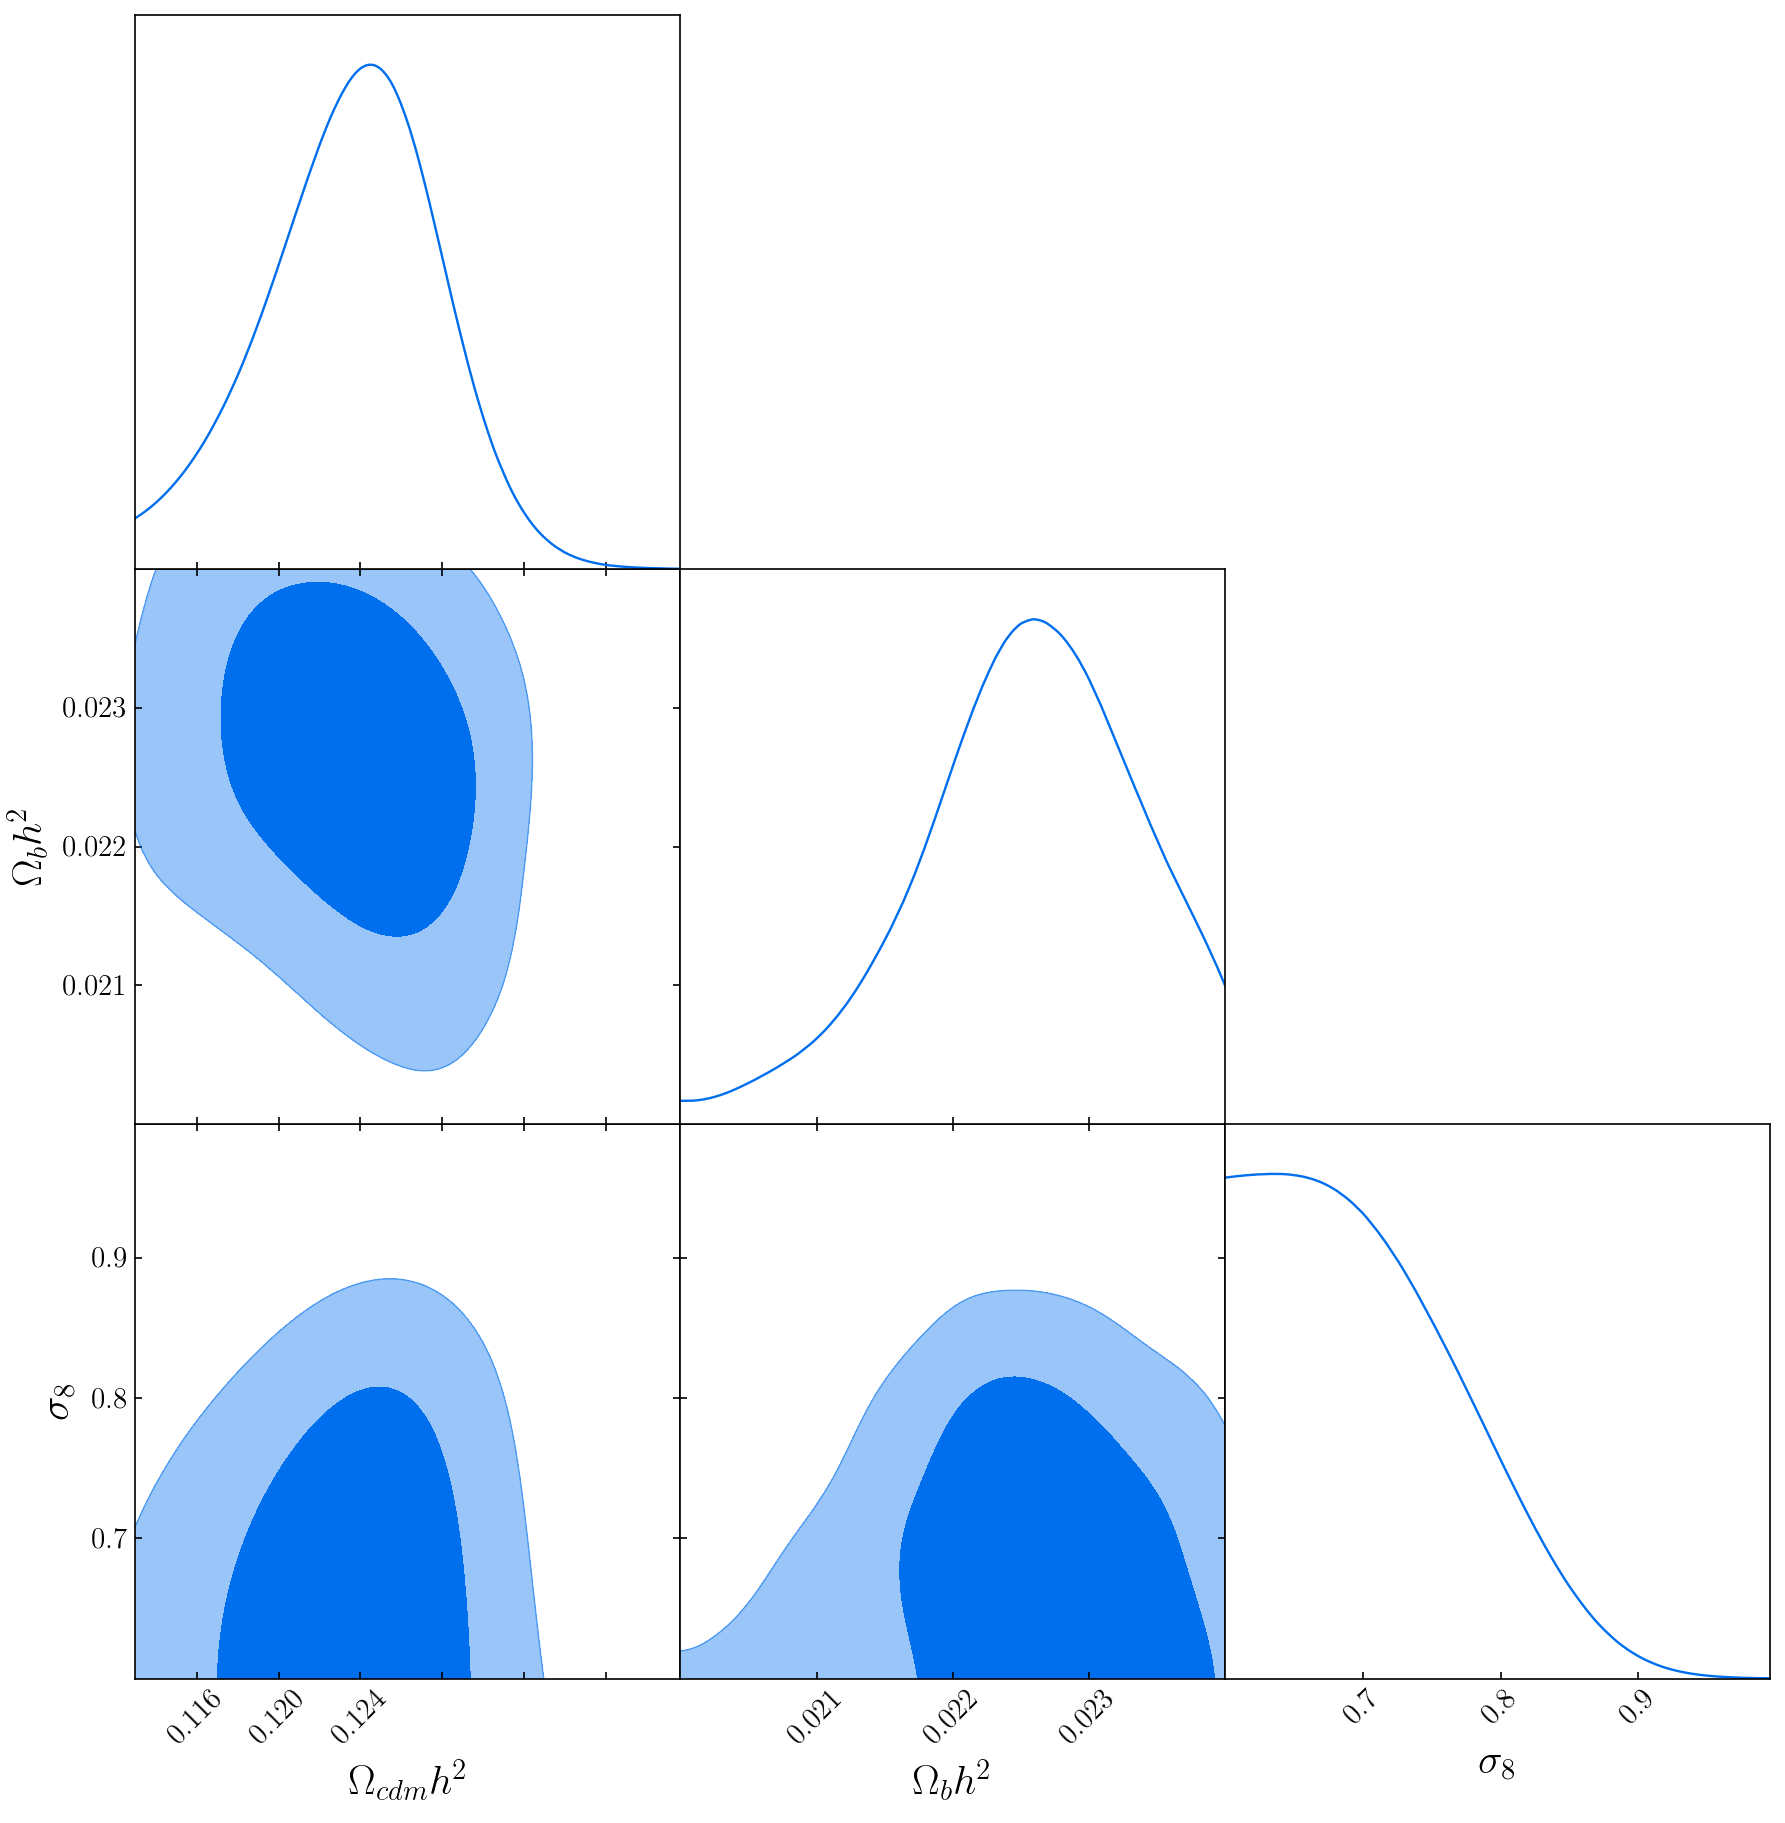

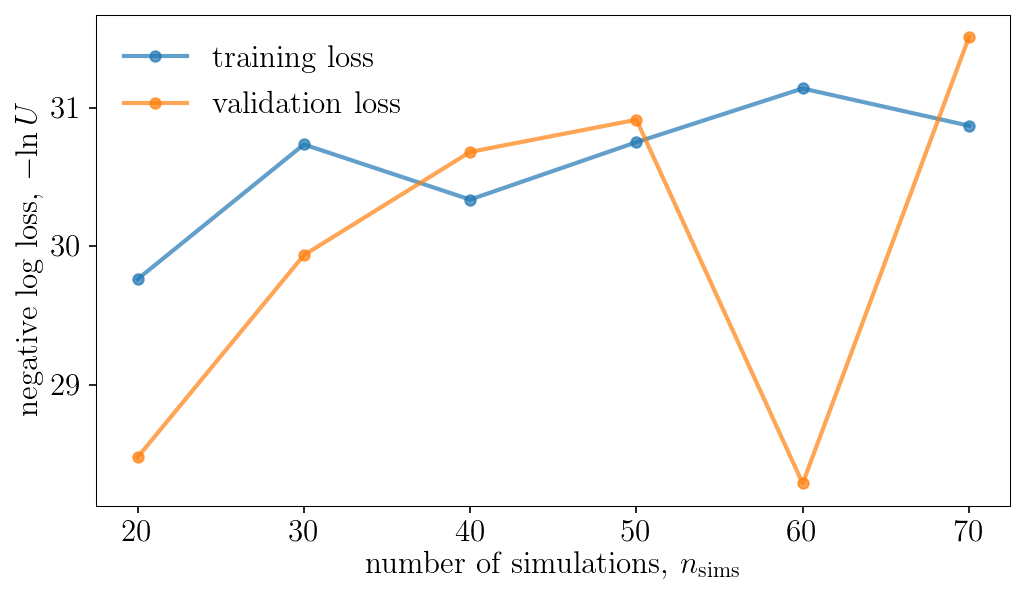

Population 6/20
Sampling proposal density...
Done.


total: 0.9950800749998052 s
total: 0.9966414870000335 s
total: 0.9950112550000085 s
total: 0.9905480220004392 s
total: 0.979461192999679 s
total: 0.9849078459997145 s
total: 0.977021858000171 s
total: 0.9793065509998087 s
total: 0.9777509030000147 s
total: 0.9766917970000577 s


Sampling approximate posterior...
Done.
Removed no burn in


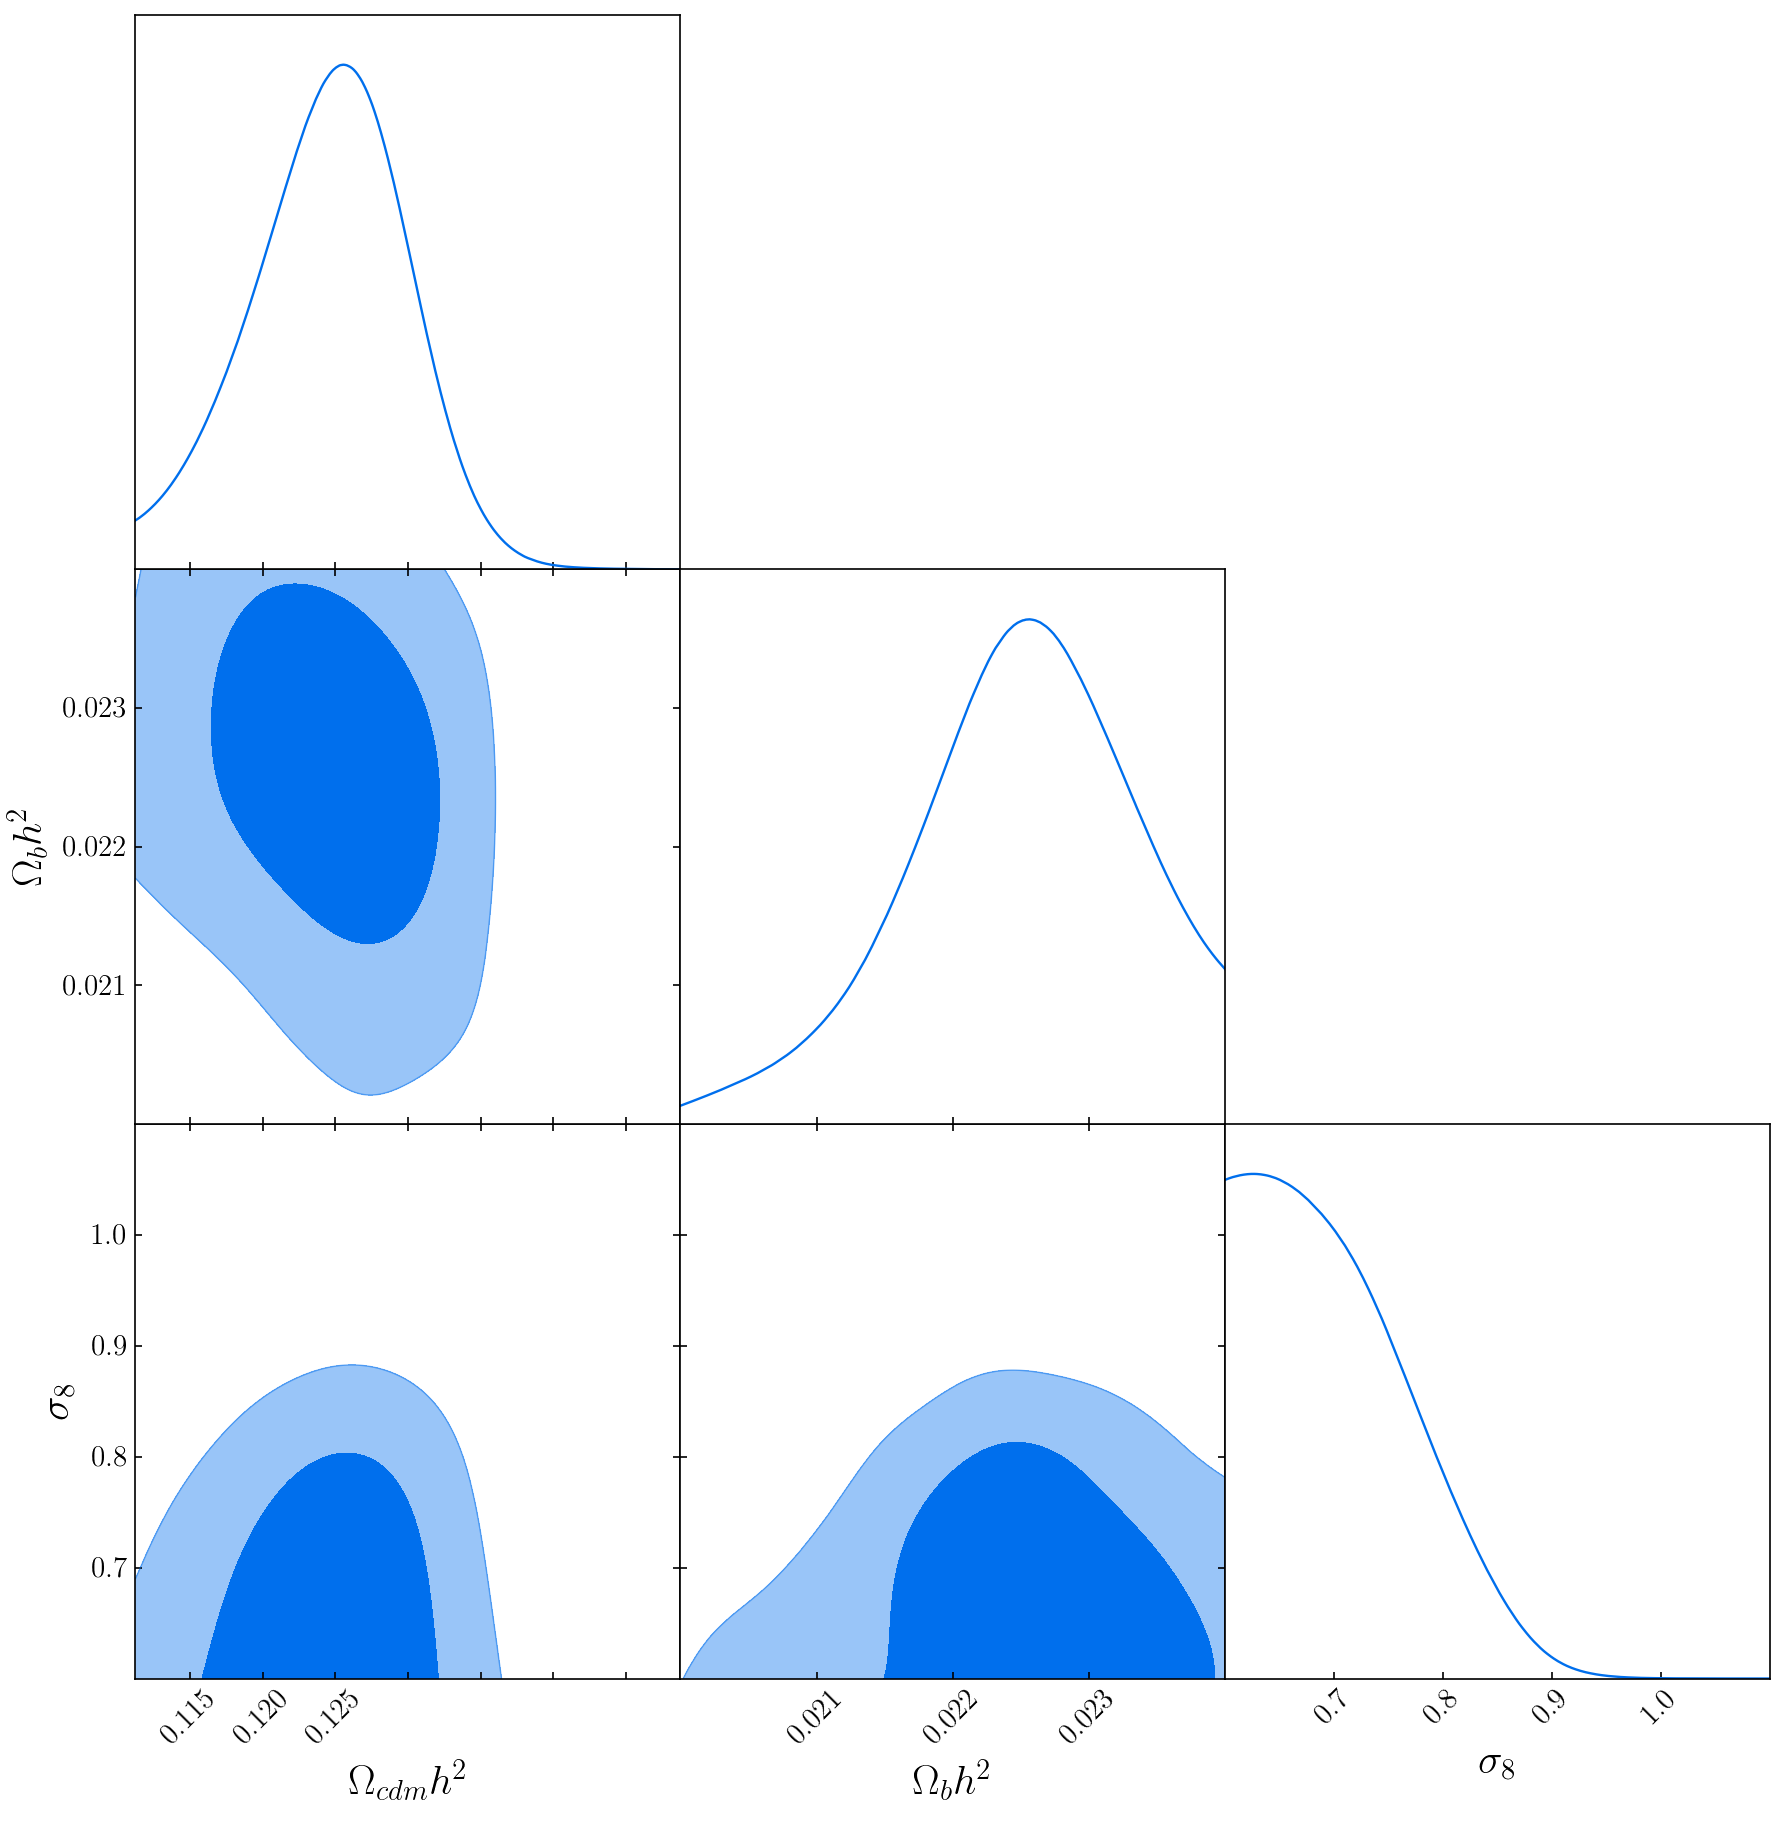

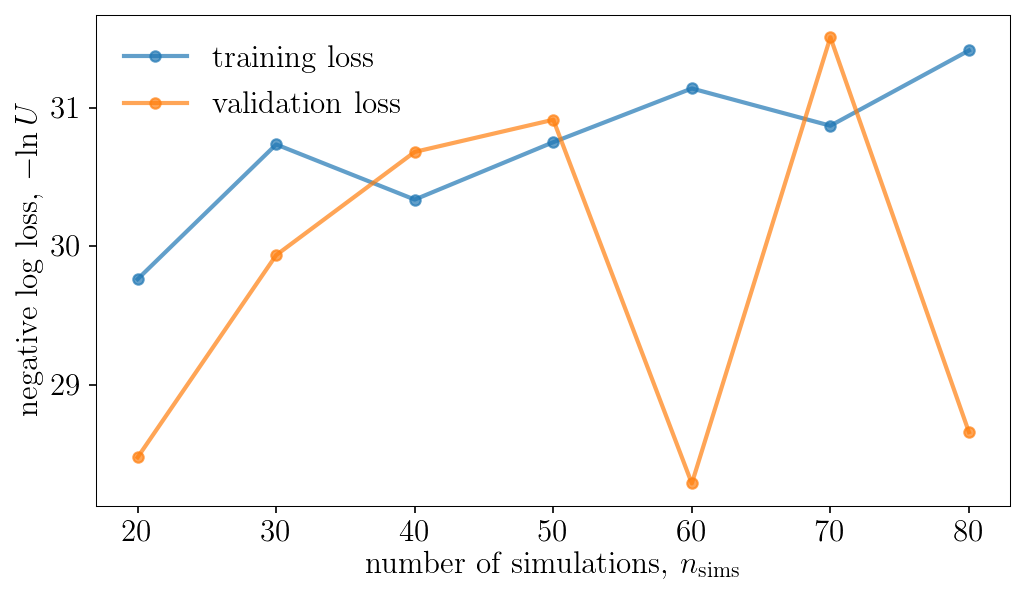

Population 7/20
Sampling proposal density...
Done.


total: 0.9854316559999461 s
total: 1.0071828279997135 s
total: 0.9795678939999561 s
total: 0.9792346609997367 s
total: 0.9840177589999257 s
total: 0.9800722360000691 s
total: 0.9813046919998669 s
total: 0.9858705020001253 s
total: 0.9786414559998775 s
total: 0.9811400319999848 s


Sampling approximate posterior...
Done.
Removed no burn in


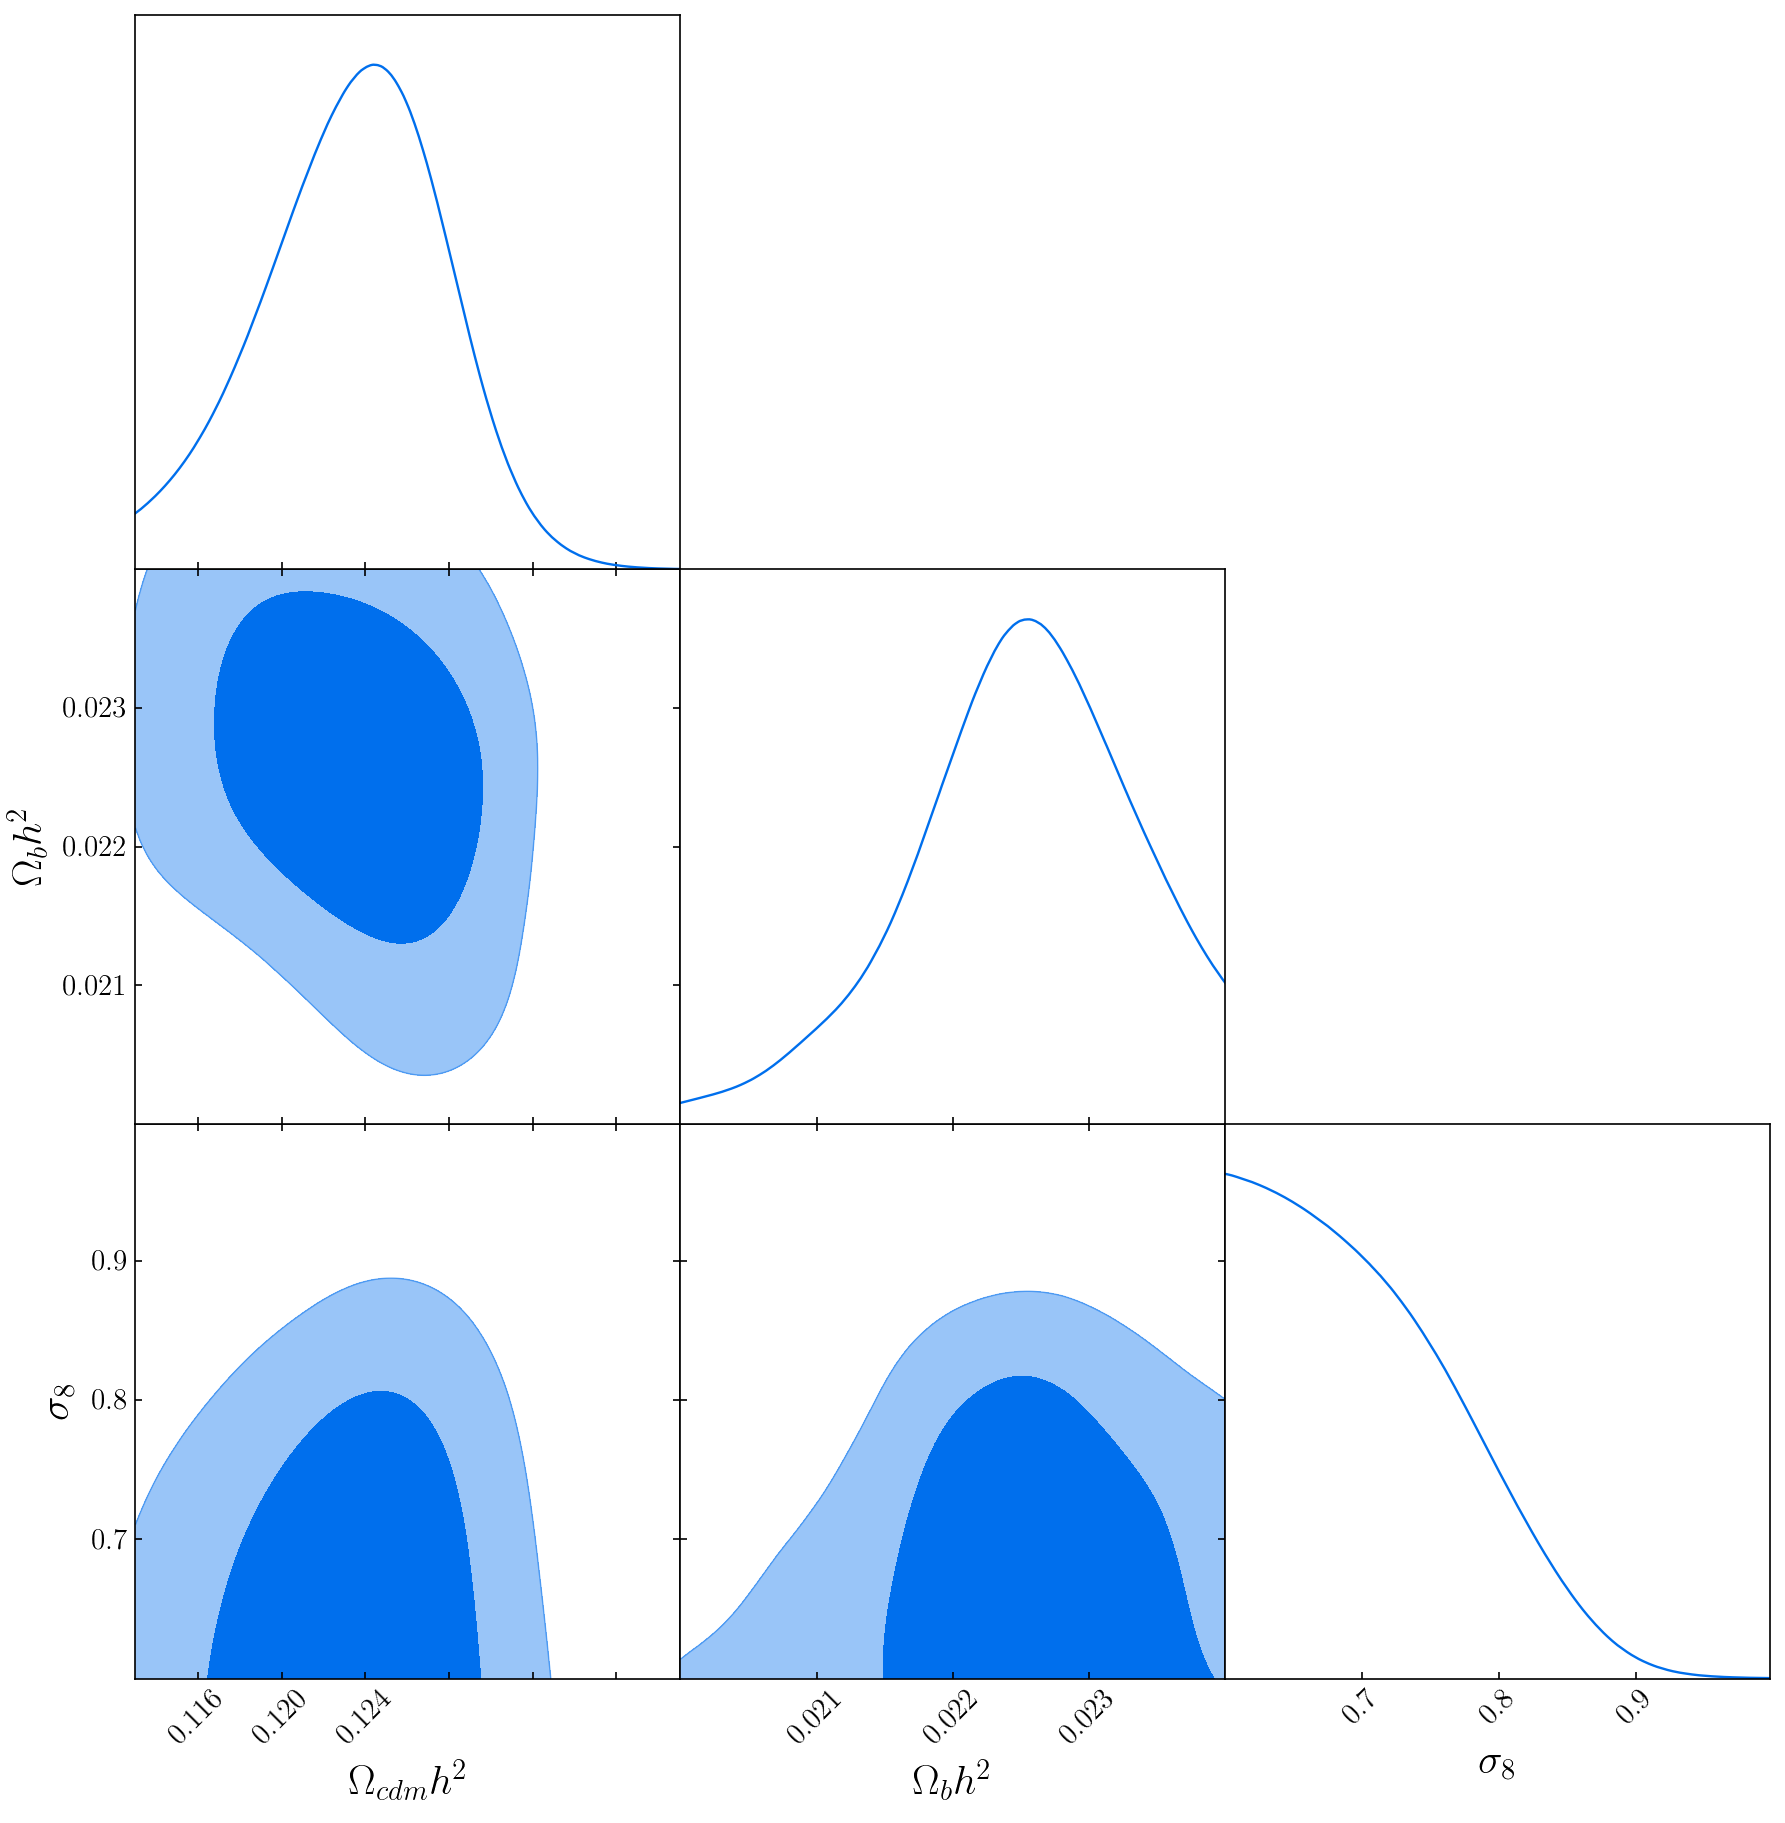

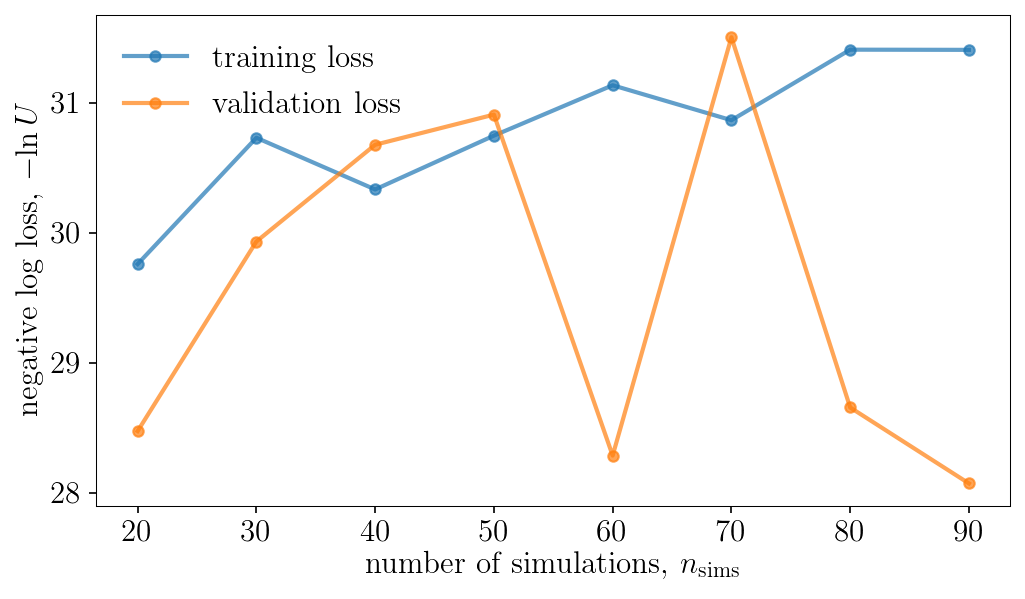

Population 8/20
Sampling proposal density...
Done.


total: 0.9919852550001451 s
total: 0.9997875519993613 s
total: 0.9870076470006097 s
total: 1.0045104020000508 s
total: 0.9914865030004876 s
total: 1.0039693879998595 s
total: 0.9953172259993153 s
total: 1.0046060839995334 s
total: 0.9988640179999493 s
total: 0.9993596120002621 s


Sampling approximate posterior...
Done.
Removed no burn in


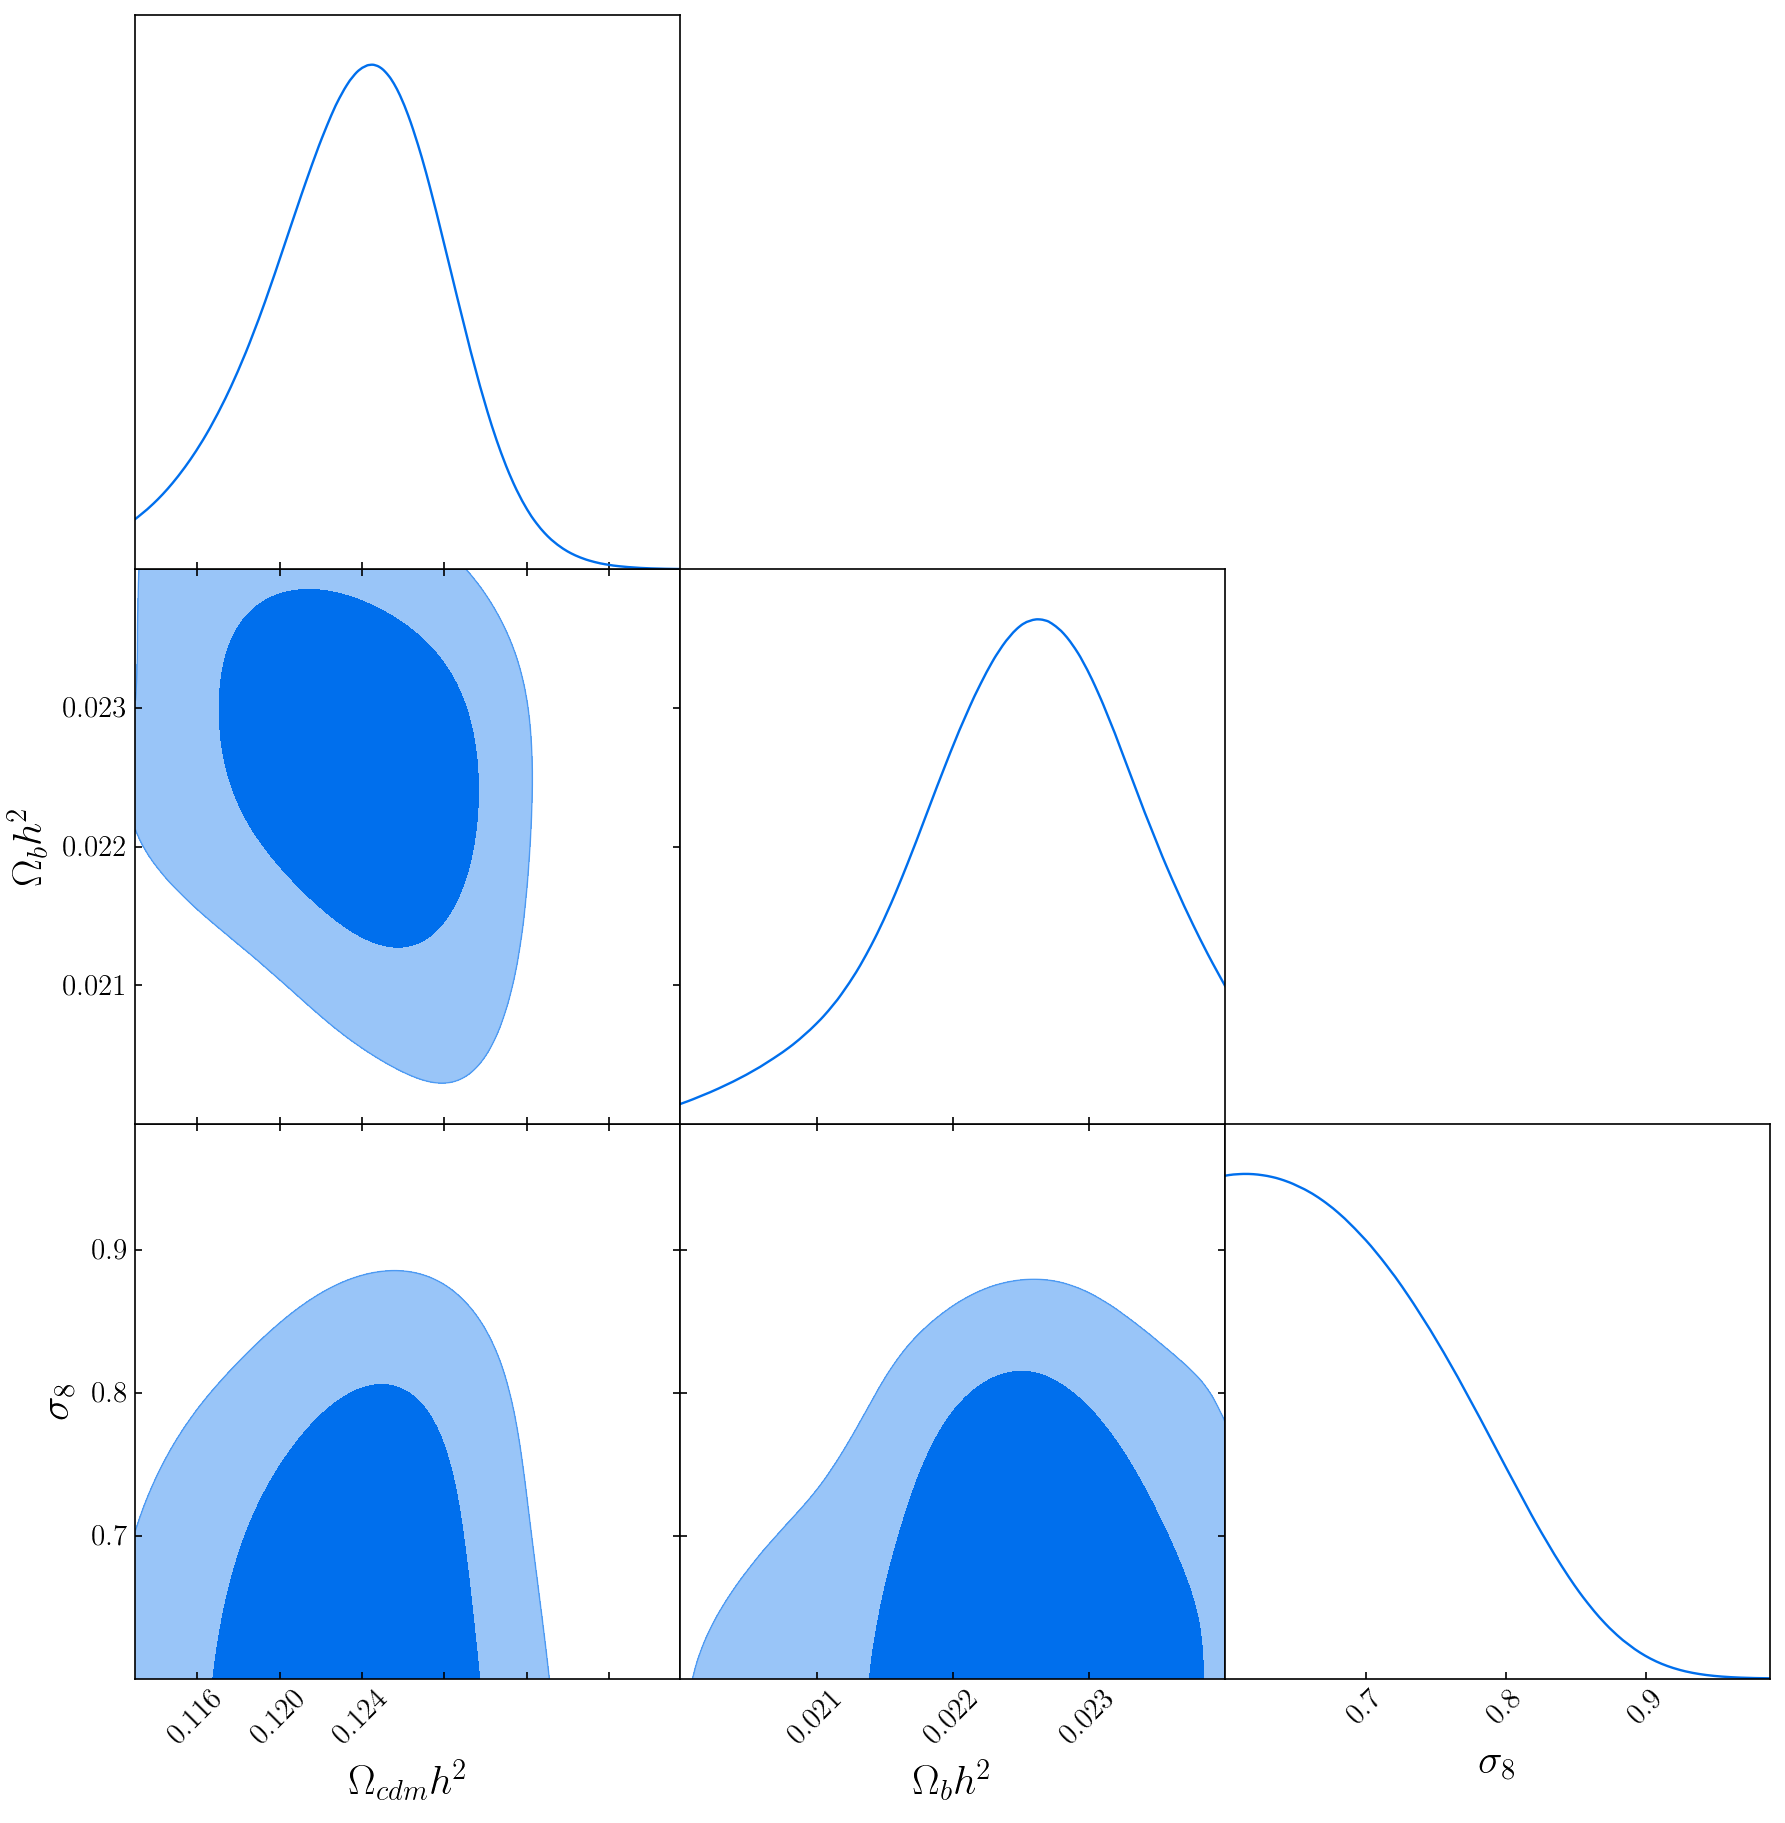

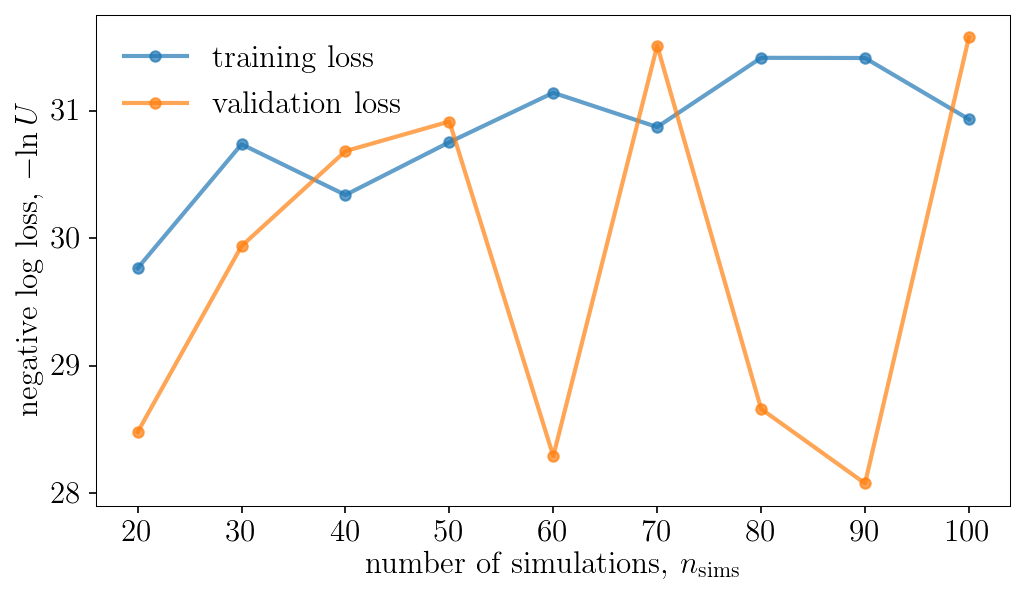

Population 9/20
Sampling proposal density...
Done.


total: 0.9960260819998439 s
total: 1.0004755700001624 s
total: 0.9946680550001474 s
total: 0.9947773980002239 s
total: 0.9820380709998062 s
total: 0.9831925840007898 s
total: 0.98645366799974 s
total: 0.9817983370003276 s
total: 0.9817340710005737 s
total: 0.9812034699998549 s


Sampling approximate posterior...
Done.
Removed no burn in


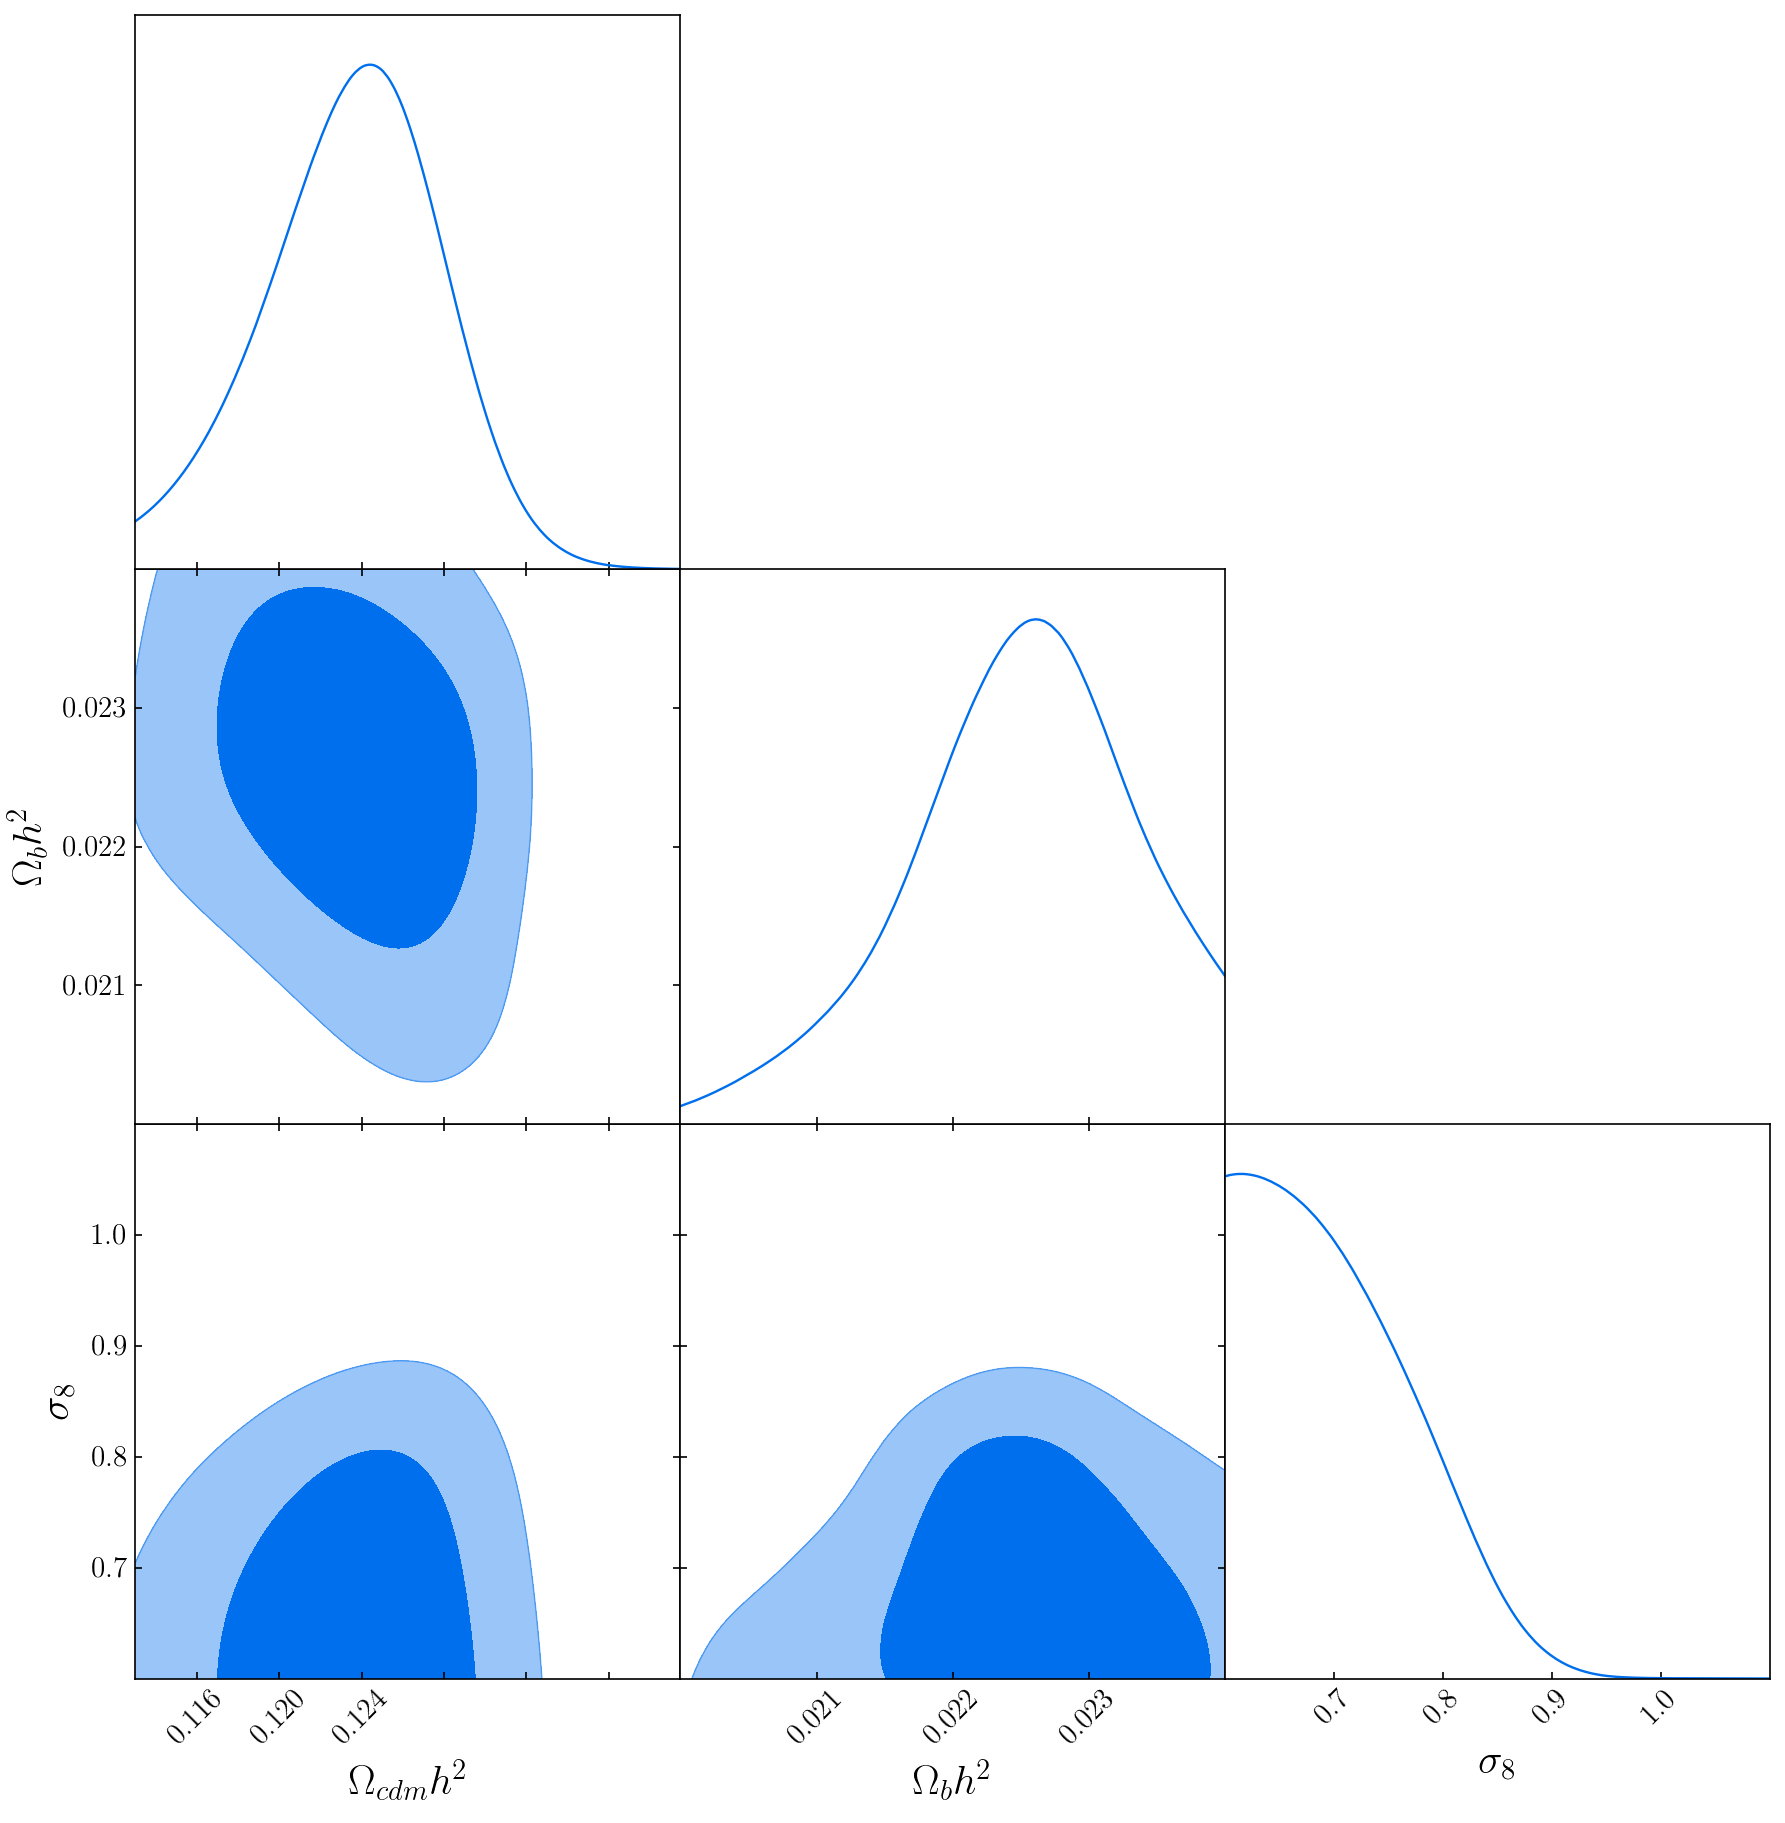

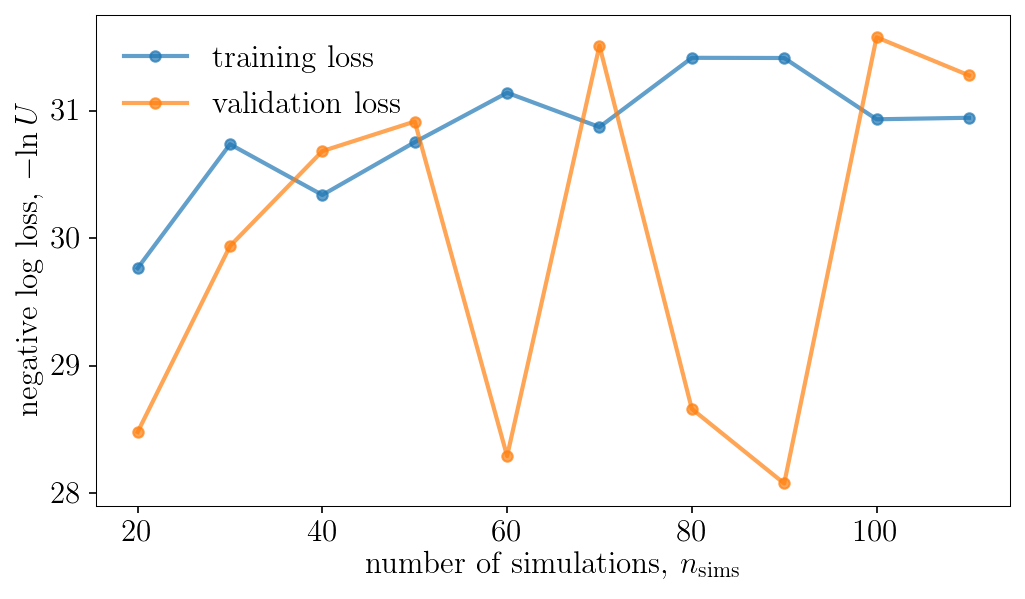

Population 10/20
Sampling proposal density...
Done.


total: 0.9973140849997435 s
total: 1.0013287540004967 s
total: 0.9974004589994365 s
total: 0.9999507219999941 s
total: 1.0005765649993918 s
total: 0.9958372330002021 s
total: 0.9968173419993036 s
total: 0.9949581649998436 s
total: 0.983497651000107 s
total: 0.9855405429998427 s


Sampling approximate posterior...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
Removed no burn in


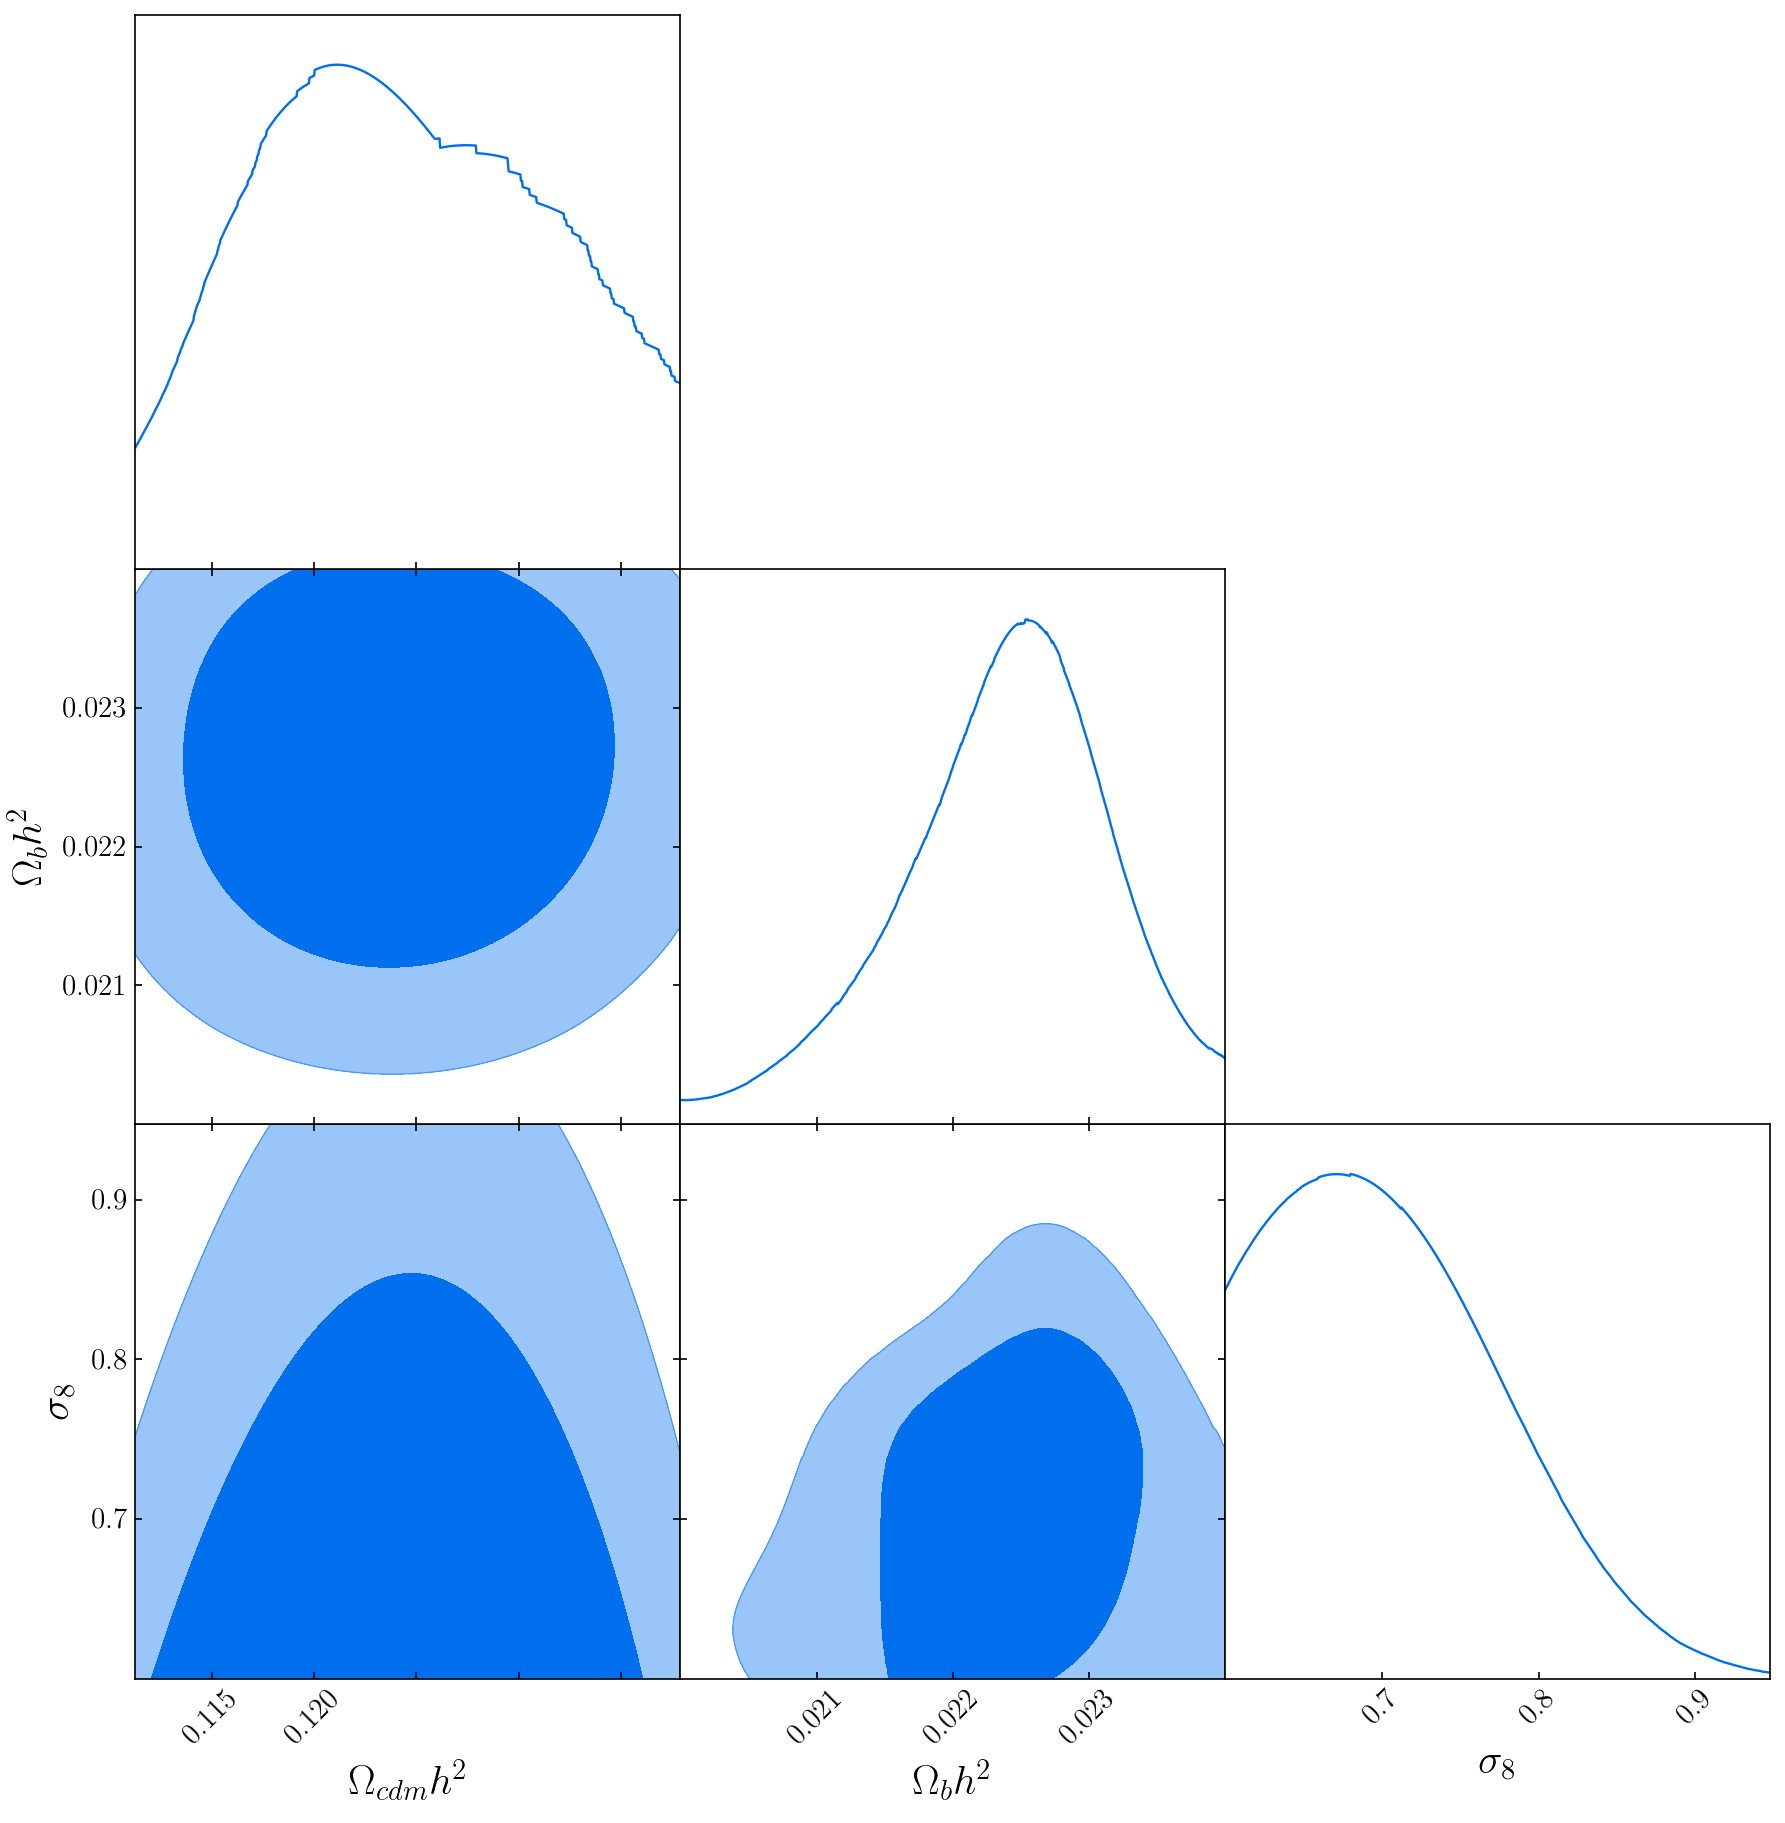

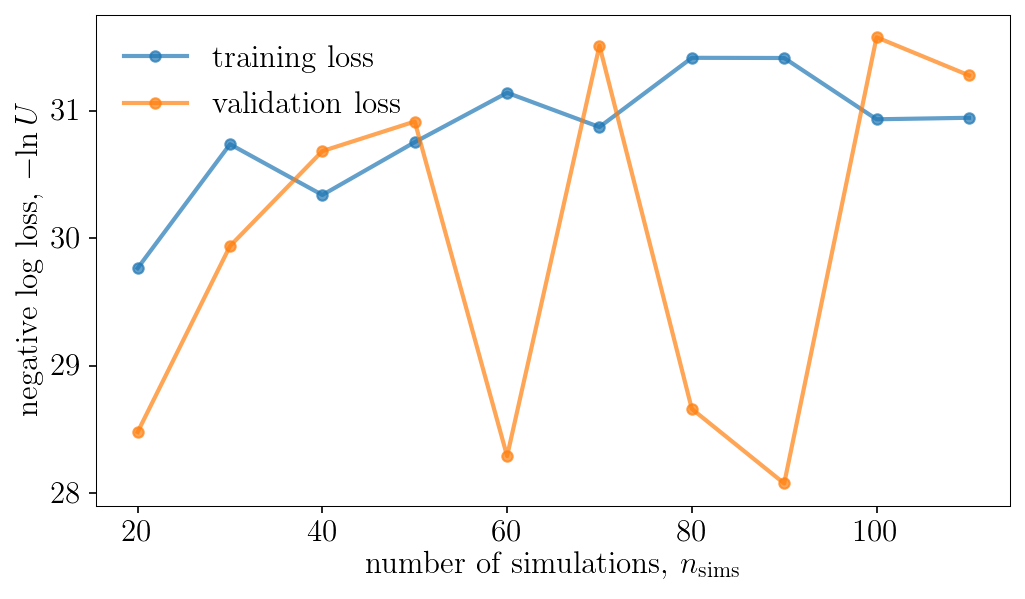

Population 11/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9808375389984576 s
total: 0.9780500559991196 s
total: 0.9828260159993079 s
total: 0.9791068850008742 s
total: 0.9837430150000728 s
total: 0.9801424819997919 s
total: 0.9798715360011556 s
total: 0.9819705720001366 s
total: 0.979248607000045 s
total: 0.9770904929991957 s


Sampling approximate posterior...
Done.
Removed no burn in


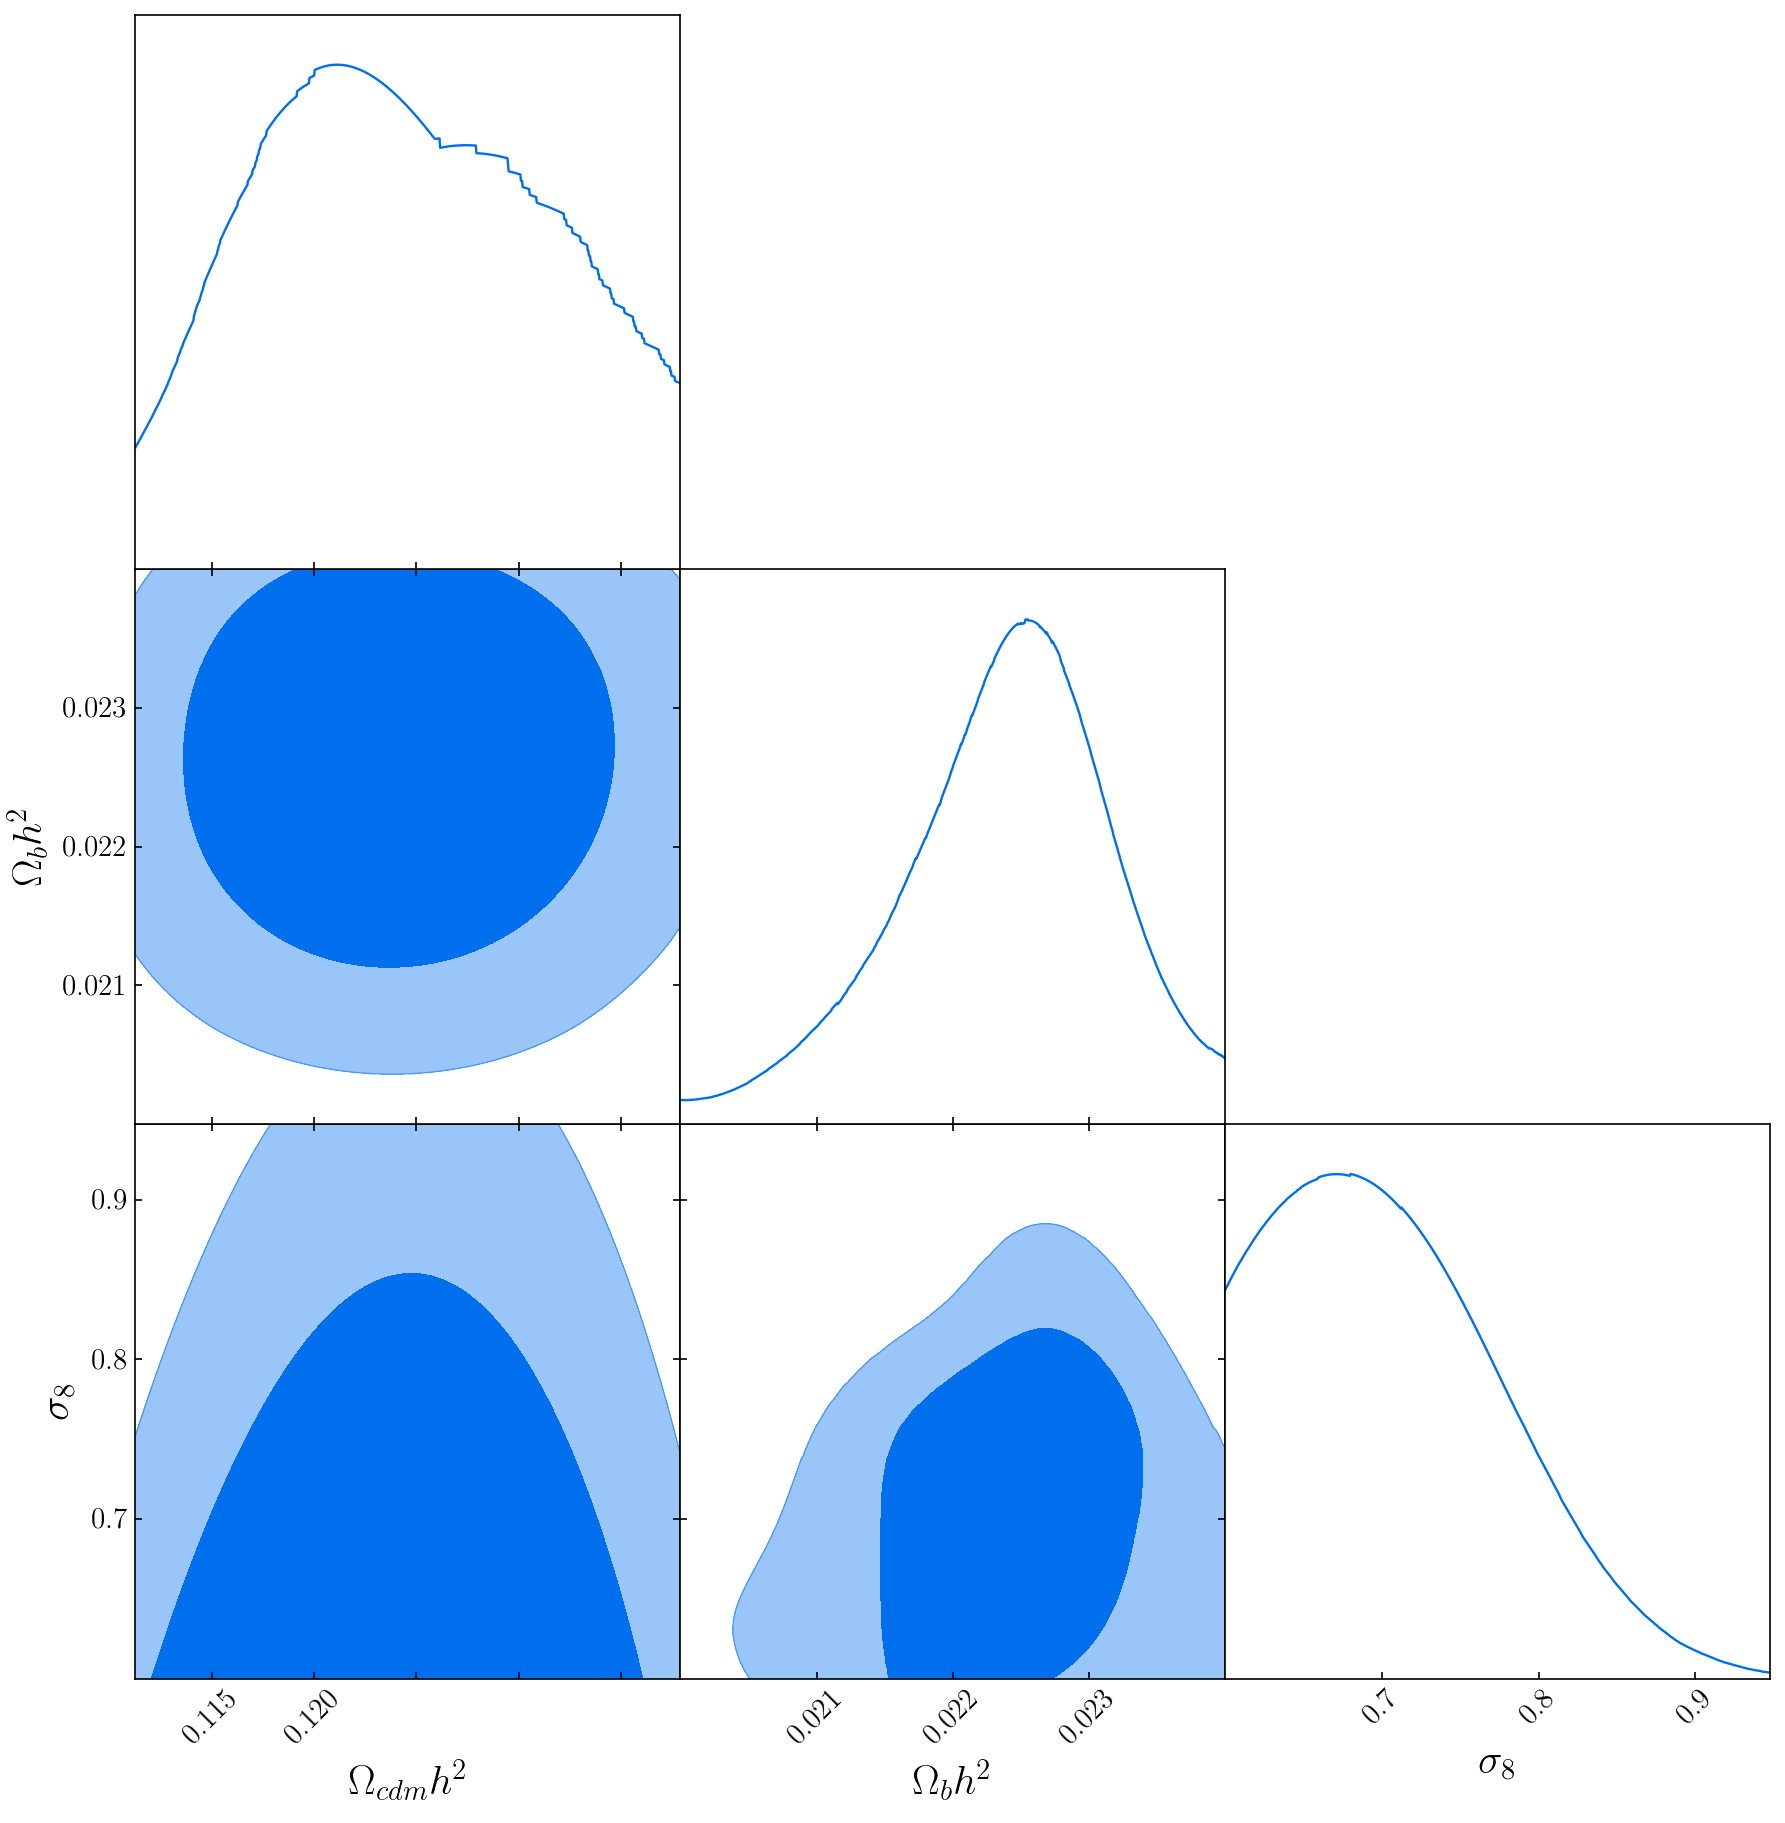

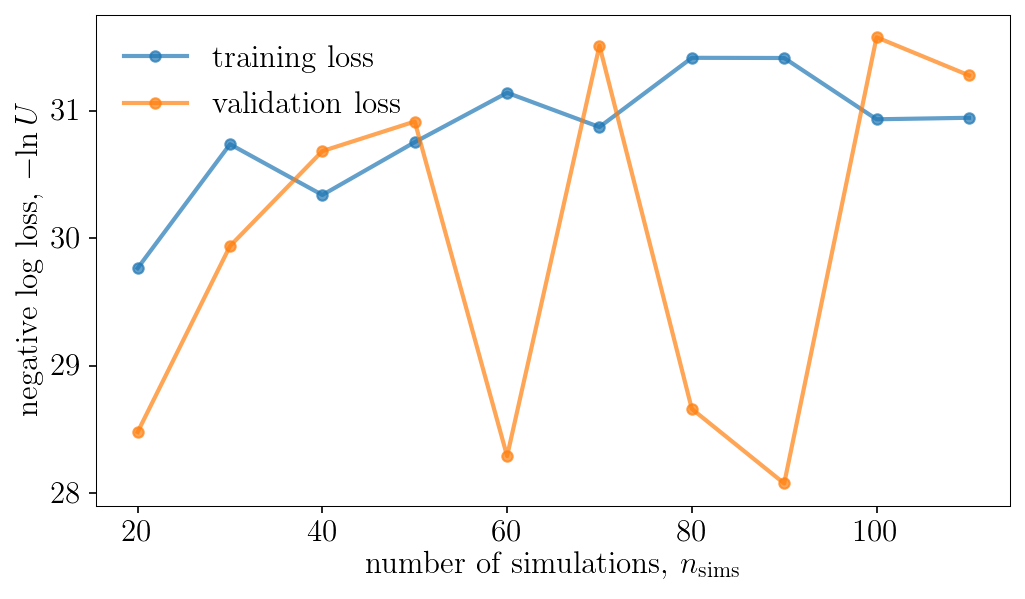

Population 12/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9979216499996255 s
total: 0.9882003179991443 s
total: 1.0013796539988107 s
total: 0.985191705998659 s
total: 0.9860083499988832 s
total: 0.987064384000405 s
total: 0.9889748360001249 s
total: 0.9864127040000312 s
total: 1.0030122870011837 s
total: 0.9868001340000774 s


Sampling approximate posterior...
Done.
Removed no burn in


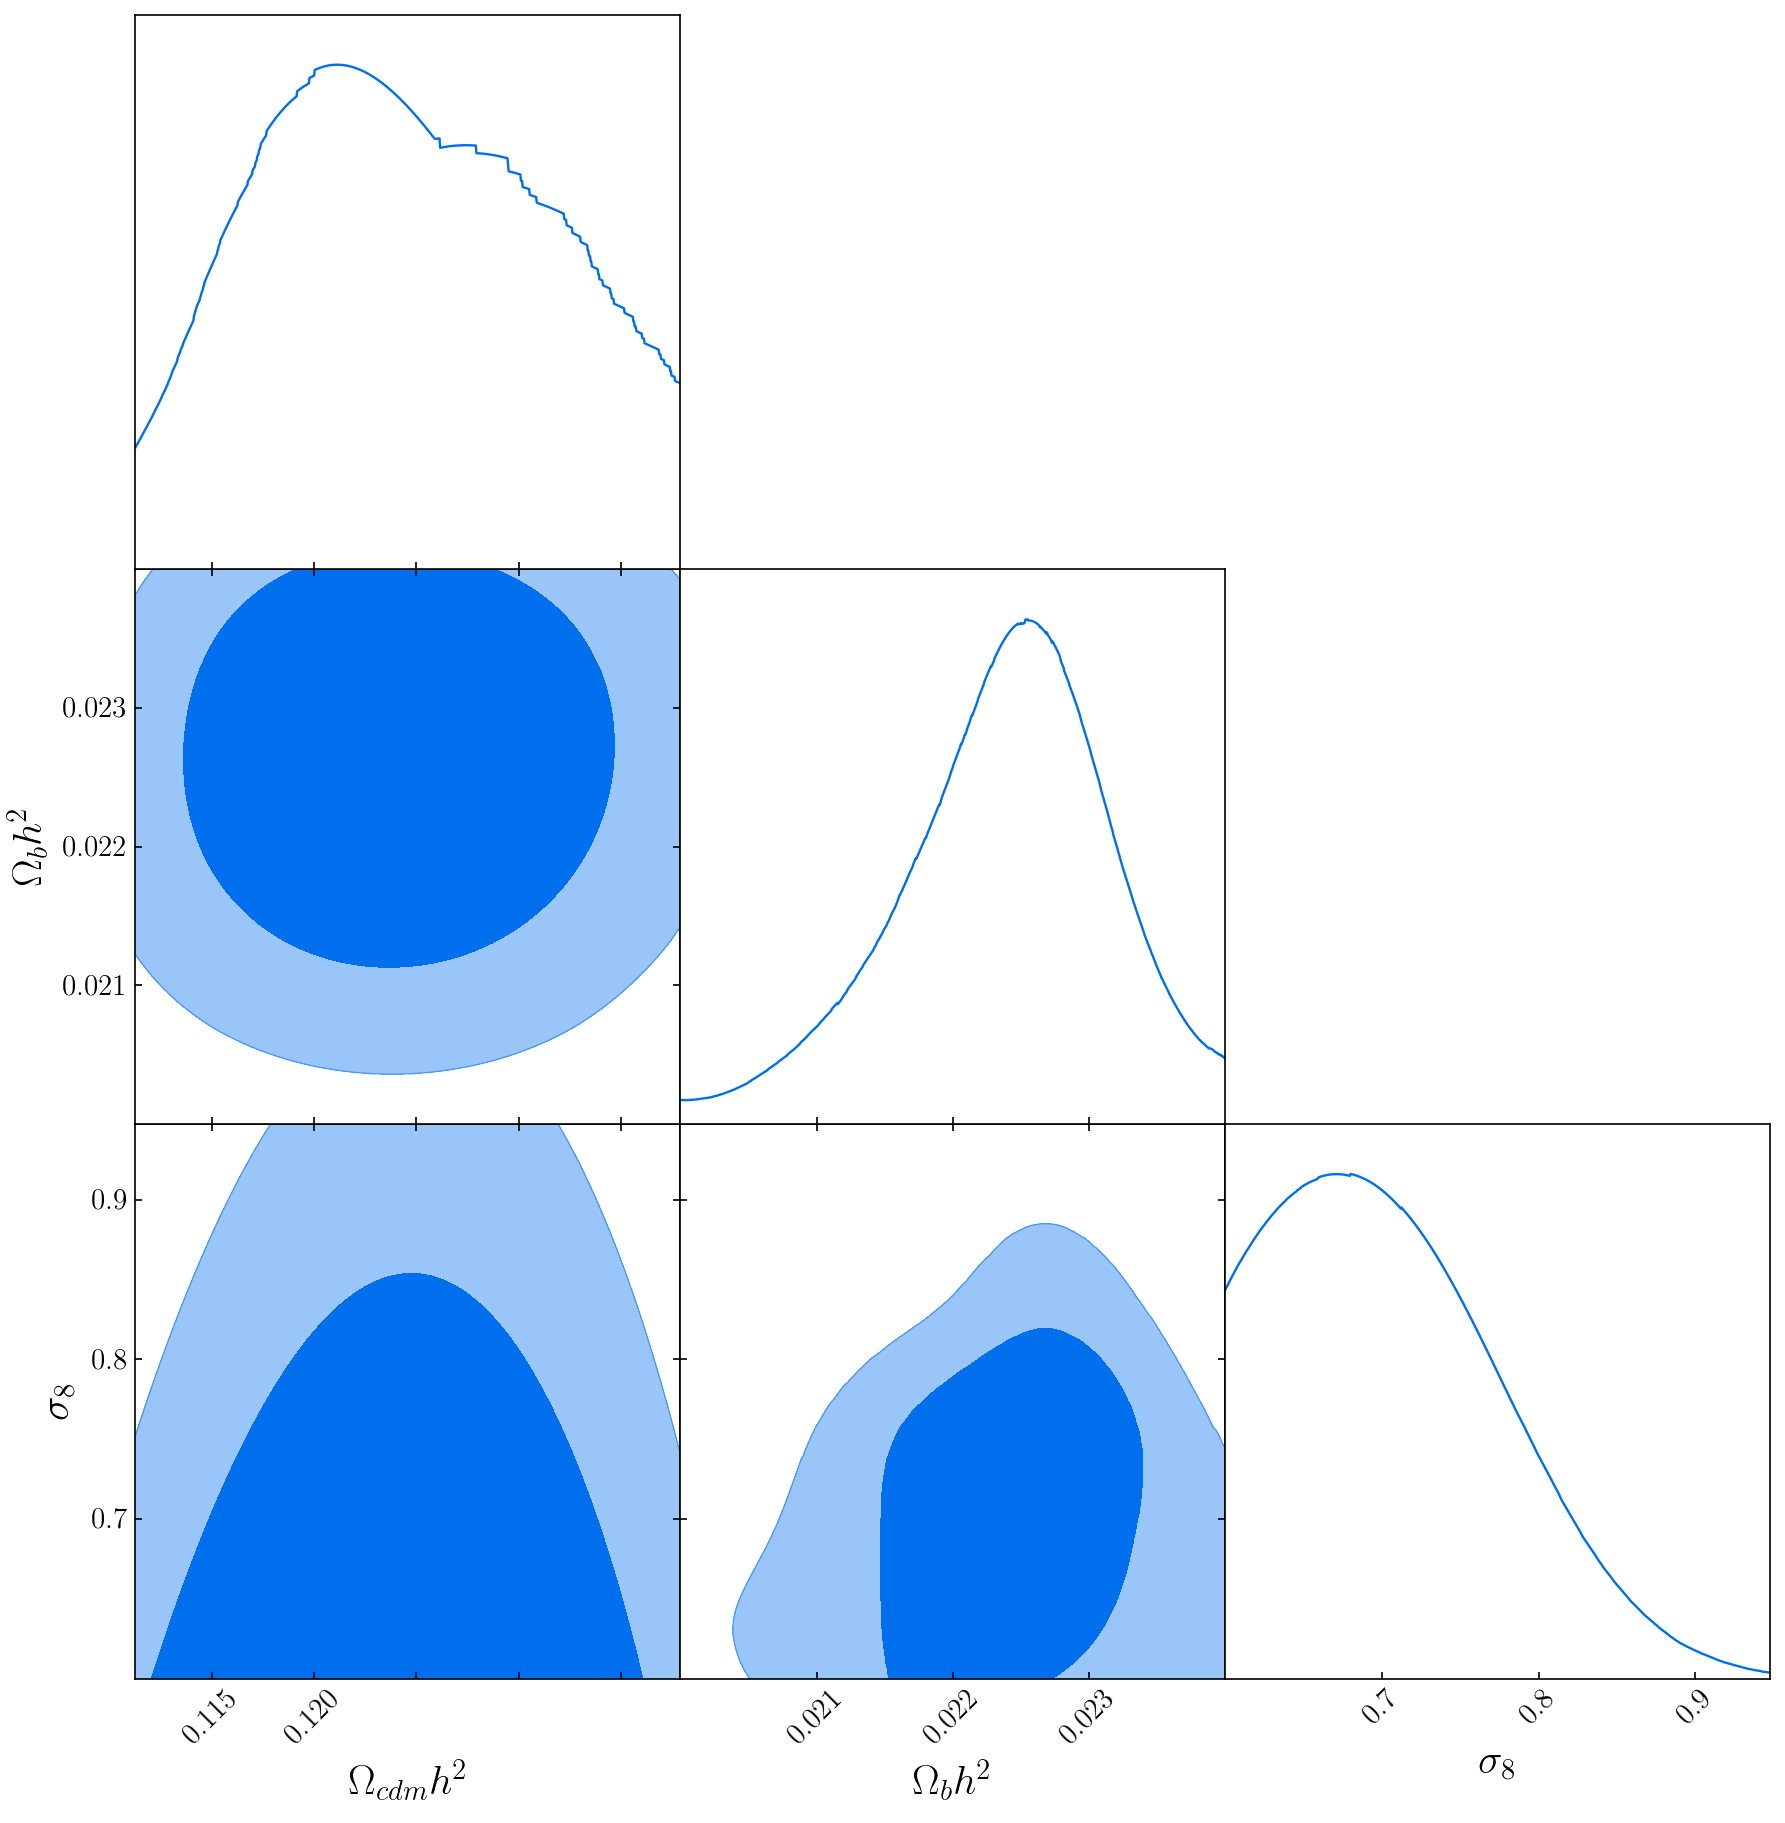

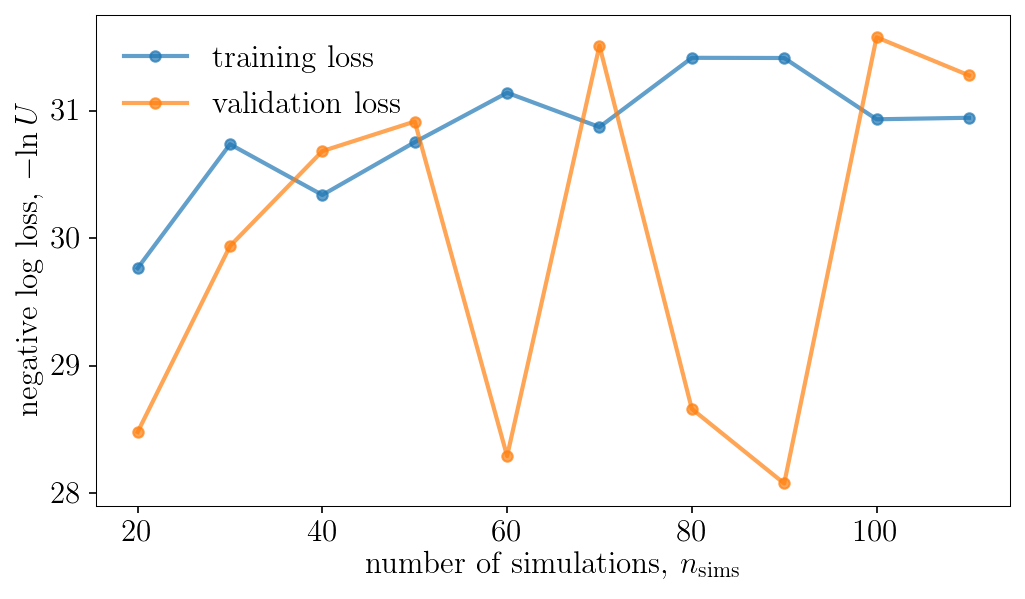

Population 13/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9973014709994459 s
total: 0.9929141939992405 s
total: 0.9922027850006998 s
total: 0.9844729320011538 s
total: 0.9888463320003211 s
total: 0.9870851350005978 s
total: 0.9863217599995551 s
total: 0.9855495670017262 s
total: 0.9872908990000724 s
total: 0.9881010289991536 s


Sampling approximate posterior...
Done.
Removed no burn in


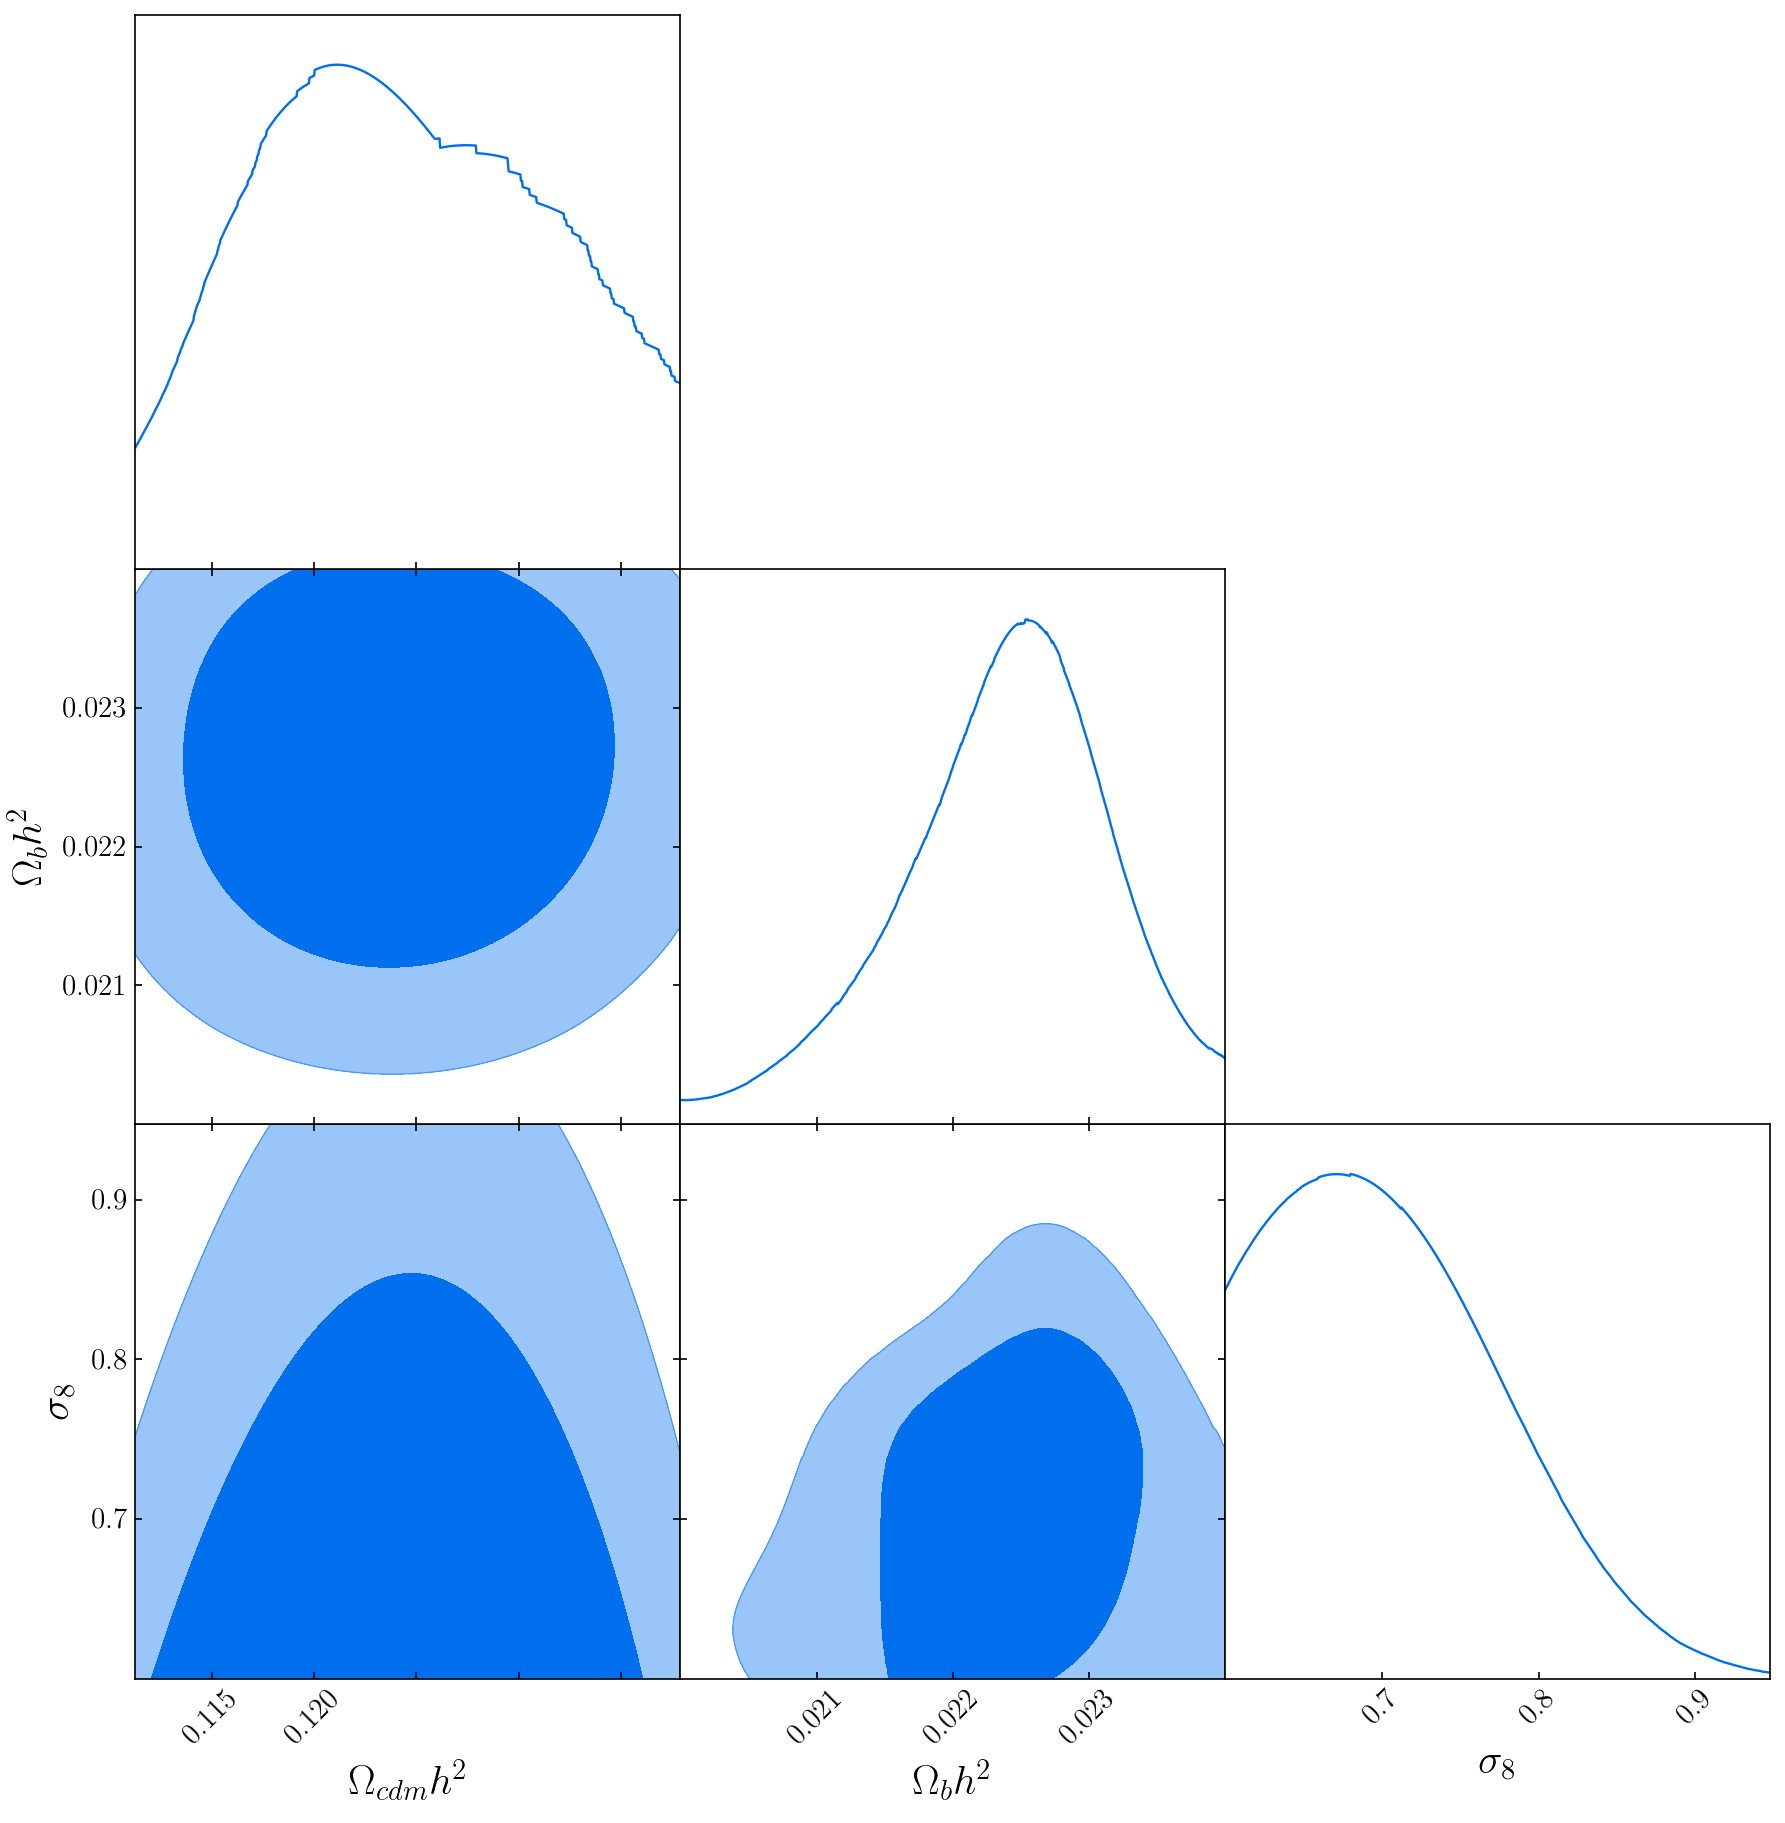

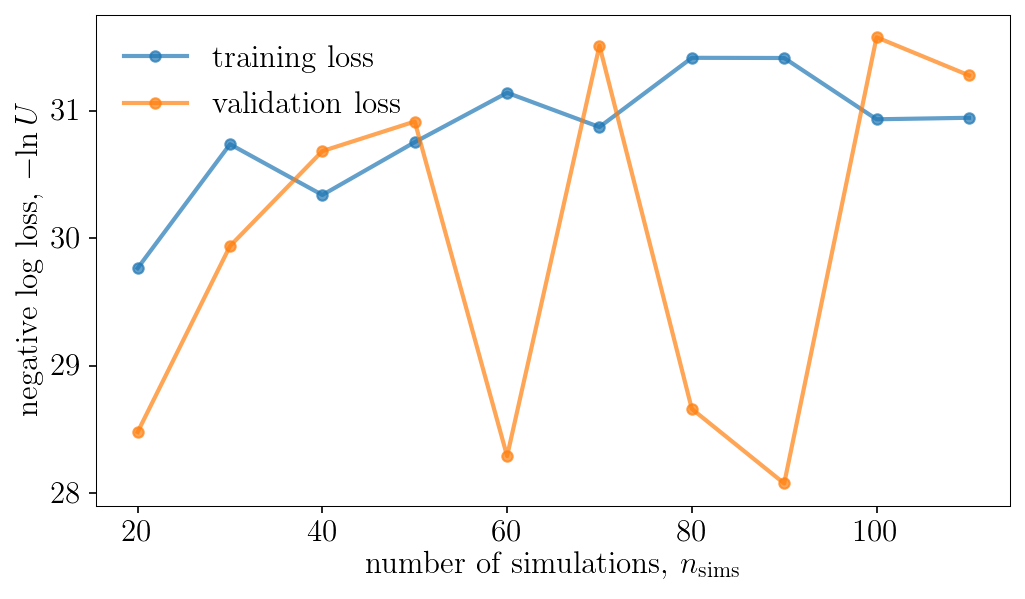

Population 14/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9901525919995038 s
total: 0.9906014120006148 s
total: 0.9871683740002481 s
total: 1.000874555998962 s
total: 0.9949731150009029 s
total: 0.9942631039994012 s
total: 0.9885031370013166 s
total: 0.9857081739992282 s
total: 0.9841718170009699 s
total: 0.9855894989996159 s


Sampling approximate posterior...
Done.
Removed no burn in


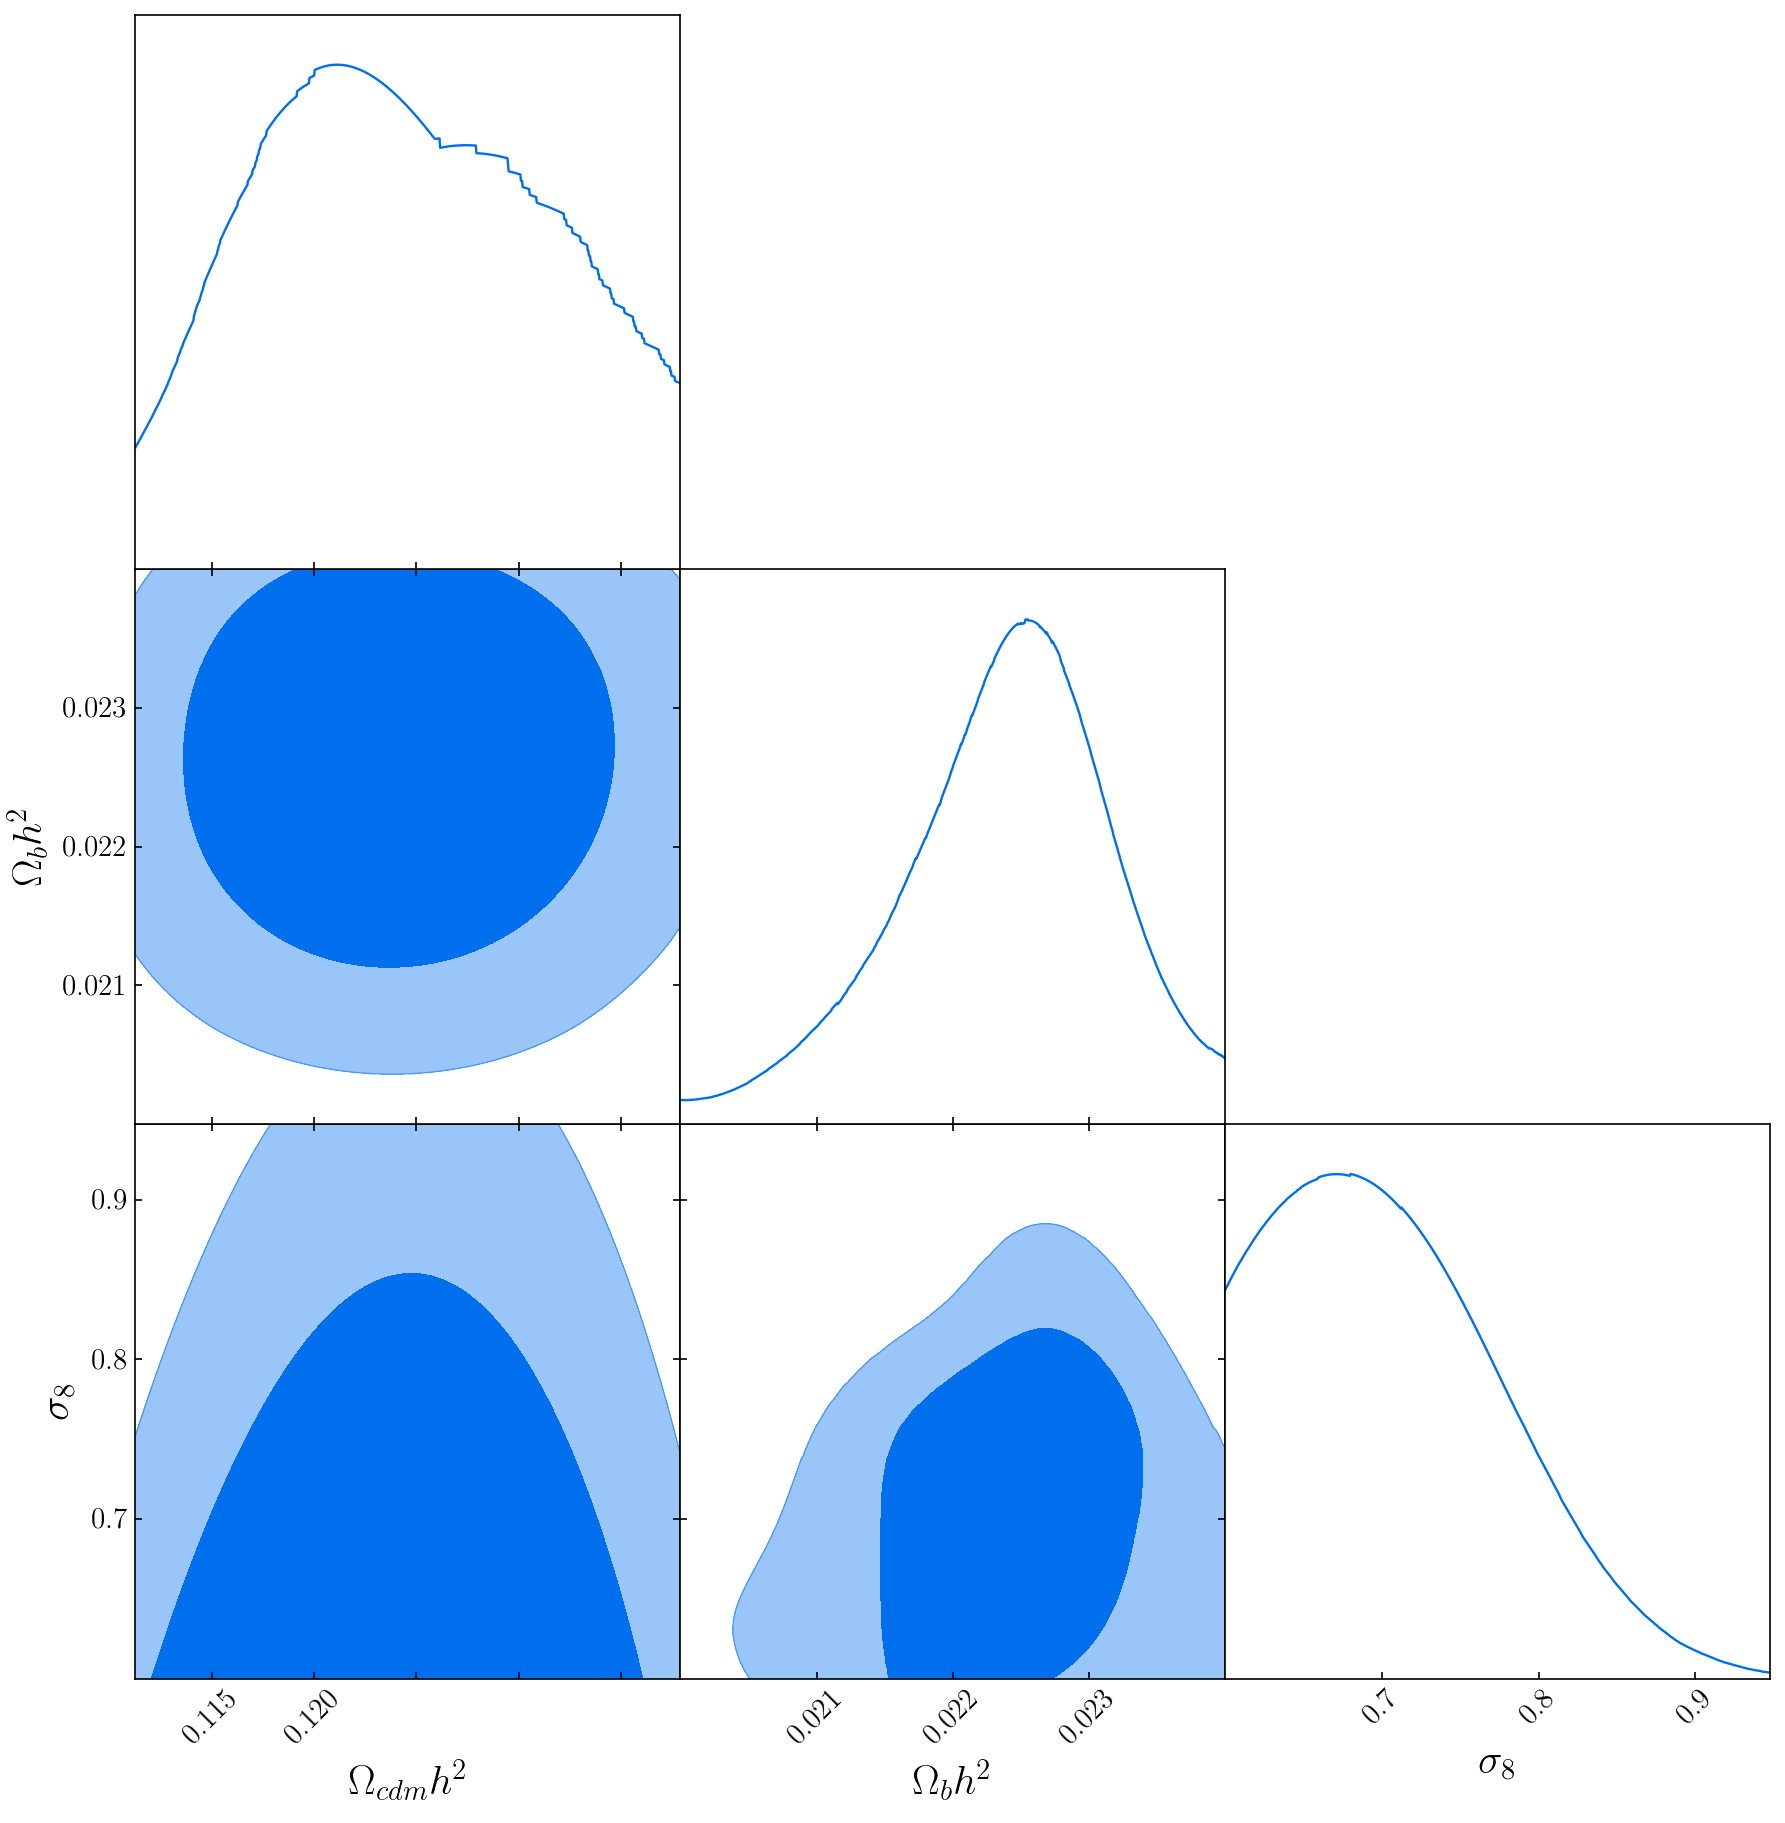

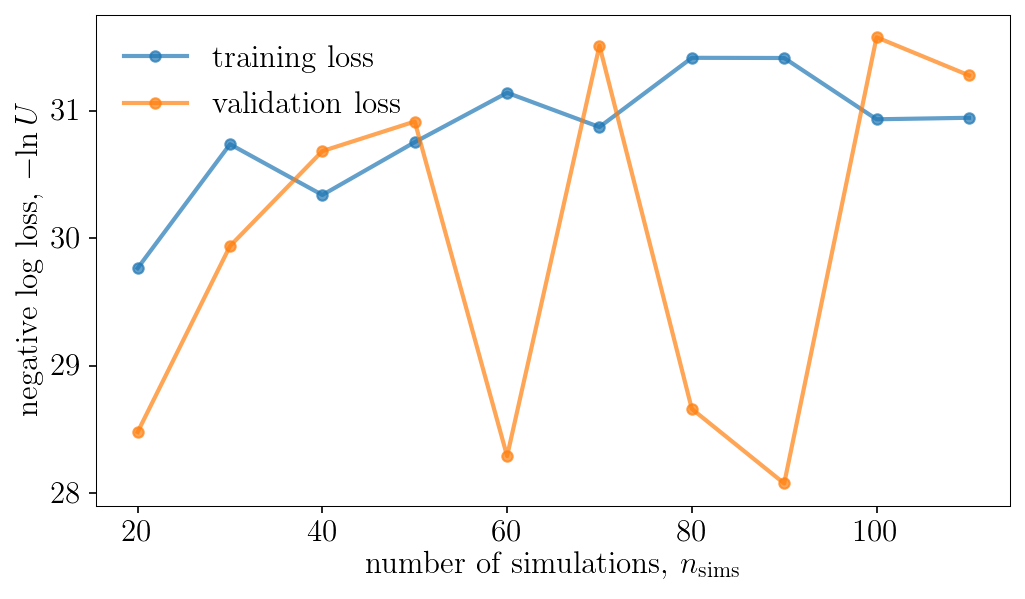

Population 15/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9890639080003893 s
total: 0.9845288999986224 s
total: 0.9832468320000771 s
total: 0.9863397030003398 s
total: 0.9866541410010541 s
total: 0.9910187890000088 s
total: 0.9850737579999986 s
total: 0.982281979999243 s
total: 0.9849295269996219 s
total: 0.9938028920005308 s


Sampling approximate posterior...
Done.
Removed no burn in


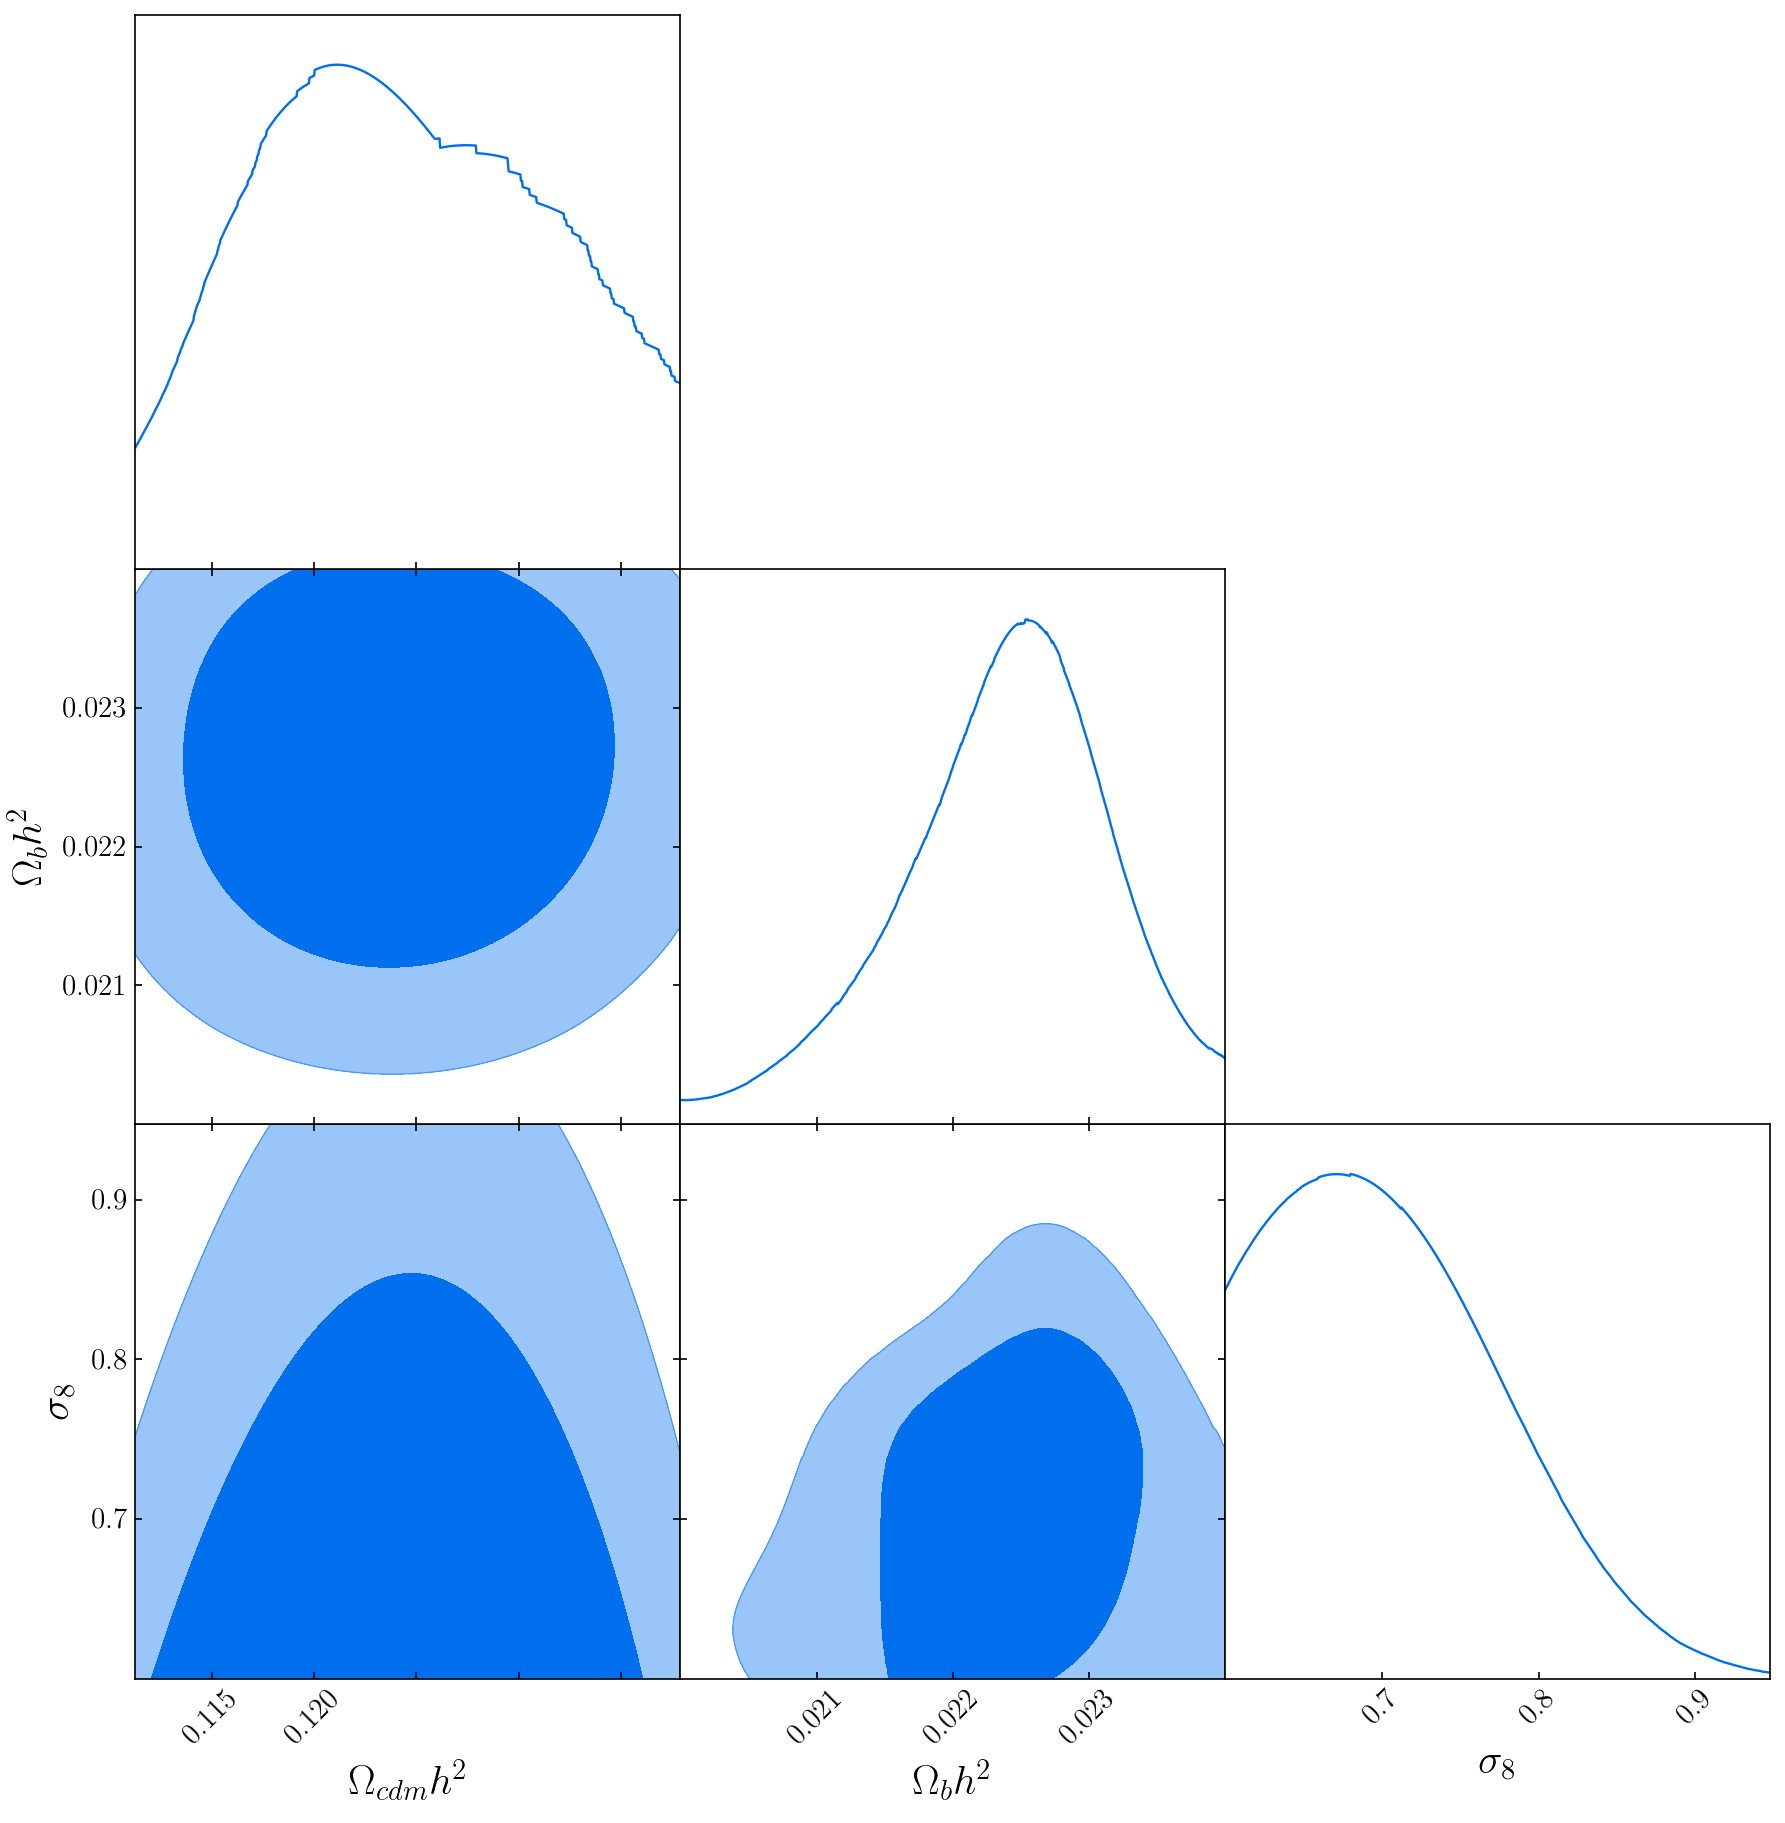

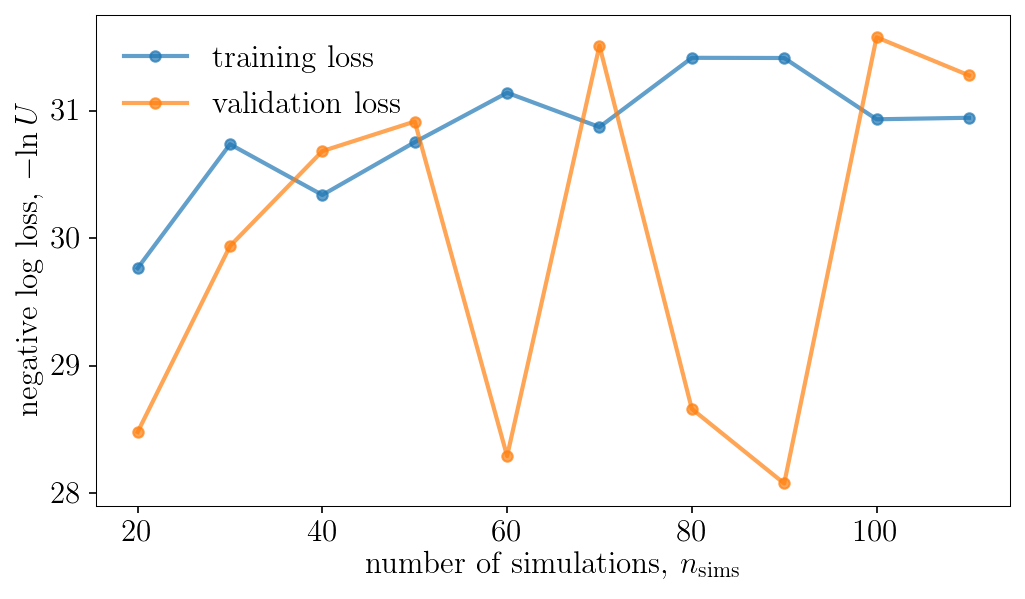

Population 16/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9880693779996363 s
total: 0.9853159220001544 s
total: 0.9798739180005214 s
total: 0.9784401159995468 s
total: 0.9771326840018446 s
total: 0.9791247450011724 s
total: 0.9790722729994741 s
total: 0.9828799339993566 s
total: 0.9783984650021011 s
total: 0.9802168809983414 s


Sampling approximate posterior...
Done.
Removed no burn in


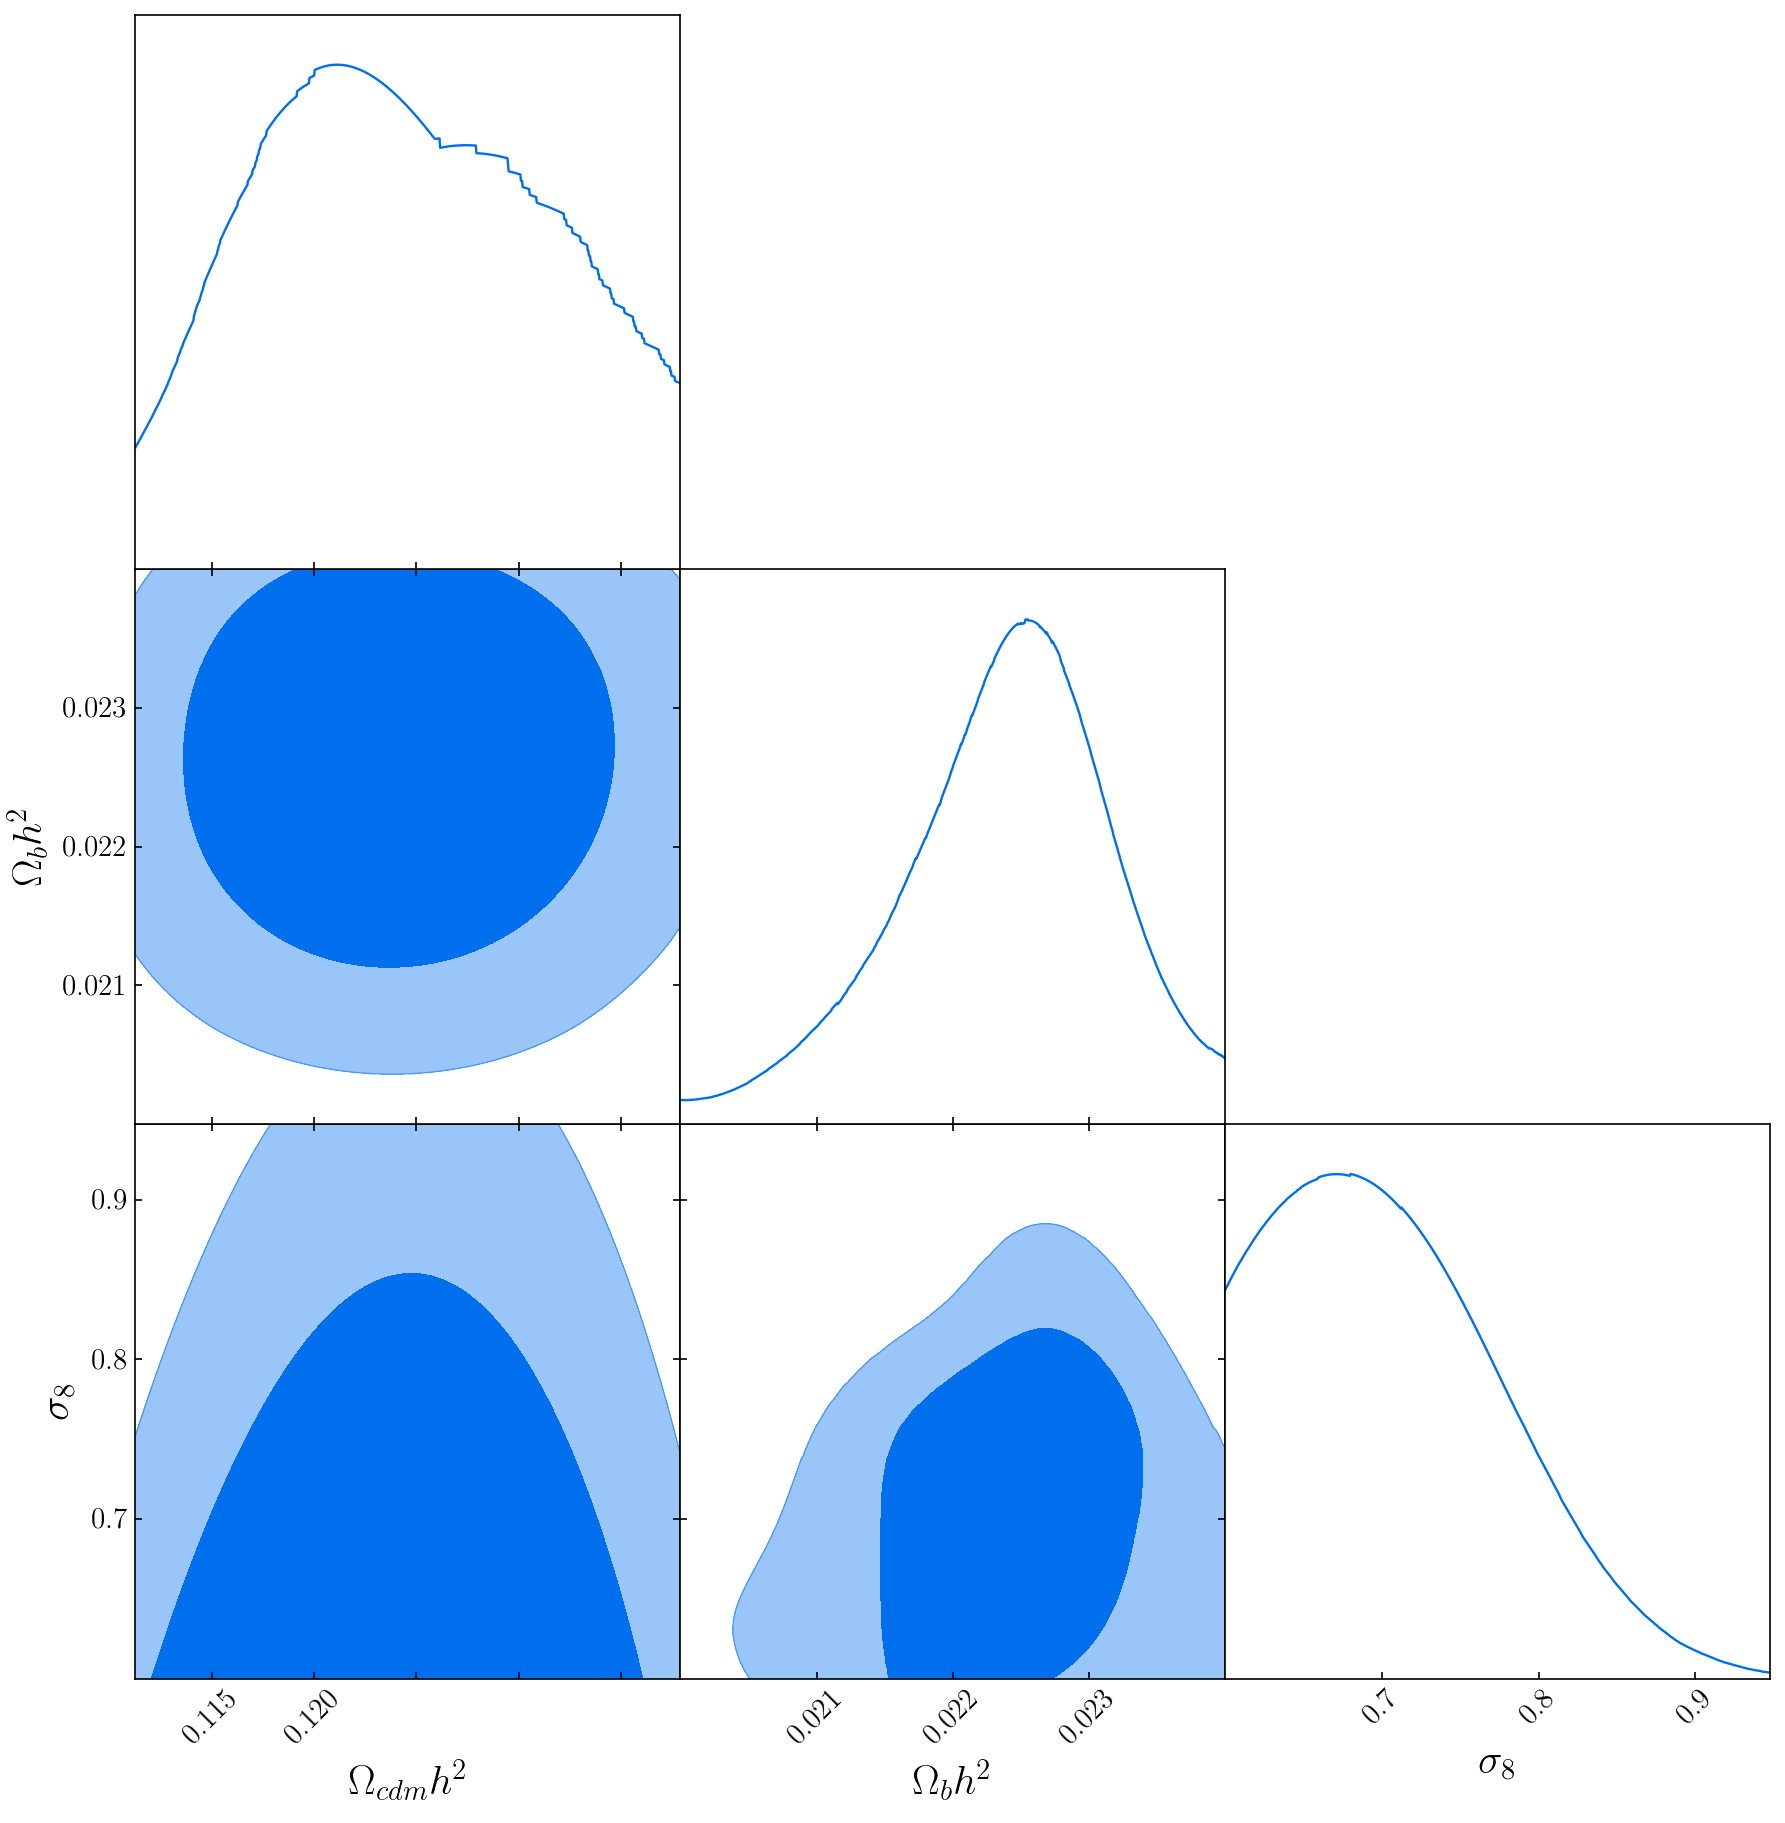

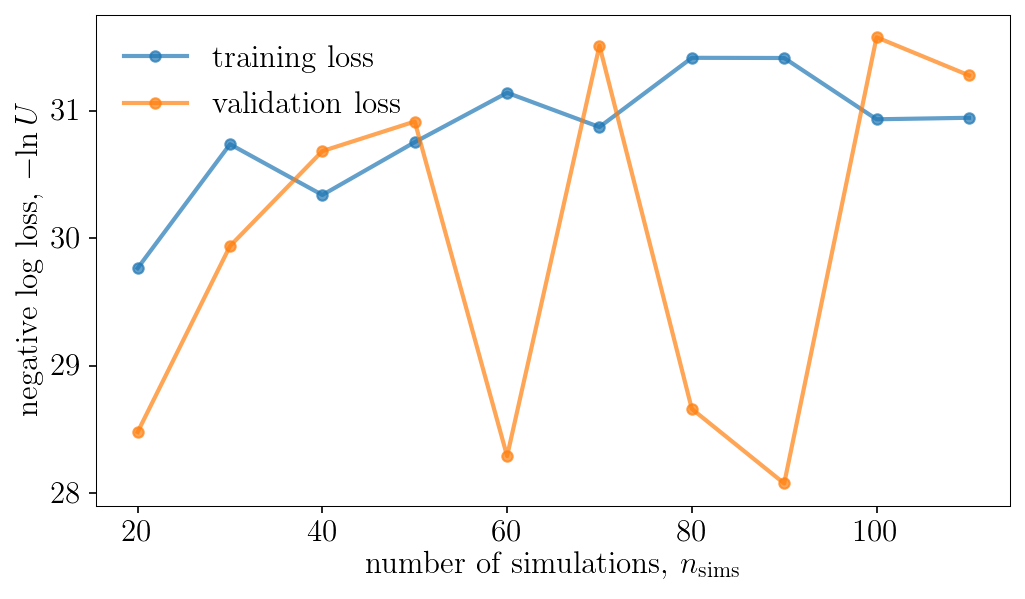

Population 17/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9840120490007394 s
total: 0.9805200820010214 s
total: 0.9821788340013882 s
total: 0.9804735249999794 s
total: 0.9852960799980792 s
total: 0.9853057659965998 s
total: 0.9818757270004426 s
total: 0.9800492490030592 s
total: 0.9792303479989641 s
total: 0.9821558250005182 s


Sampling approximate posterior...
Done.
Removed no burn in


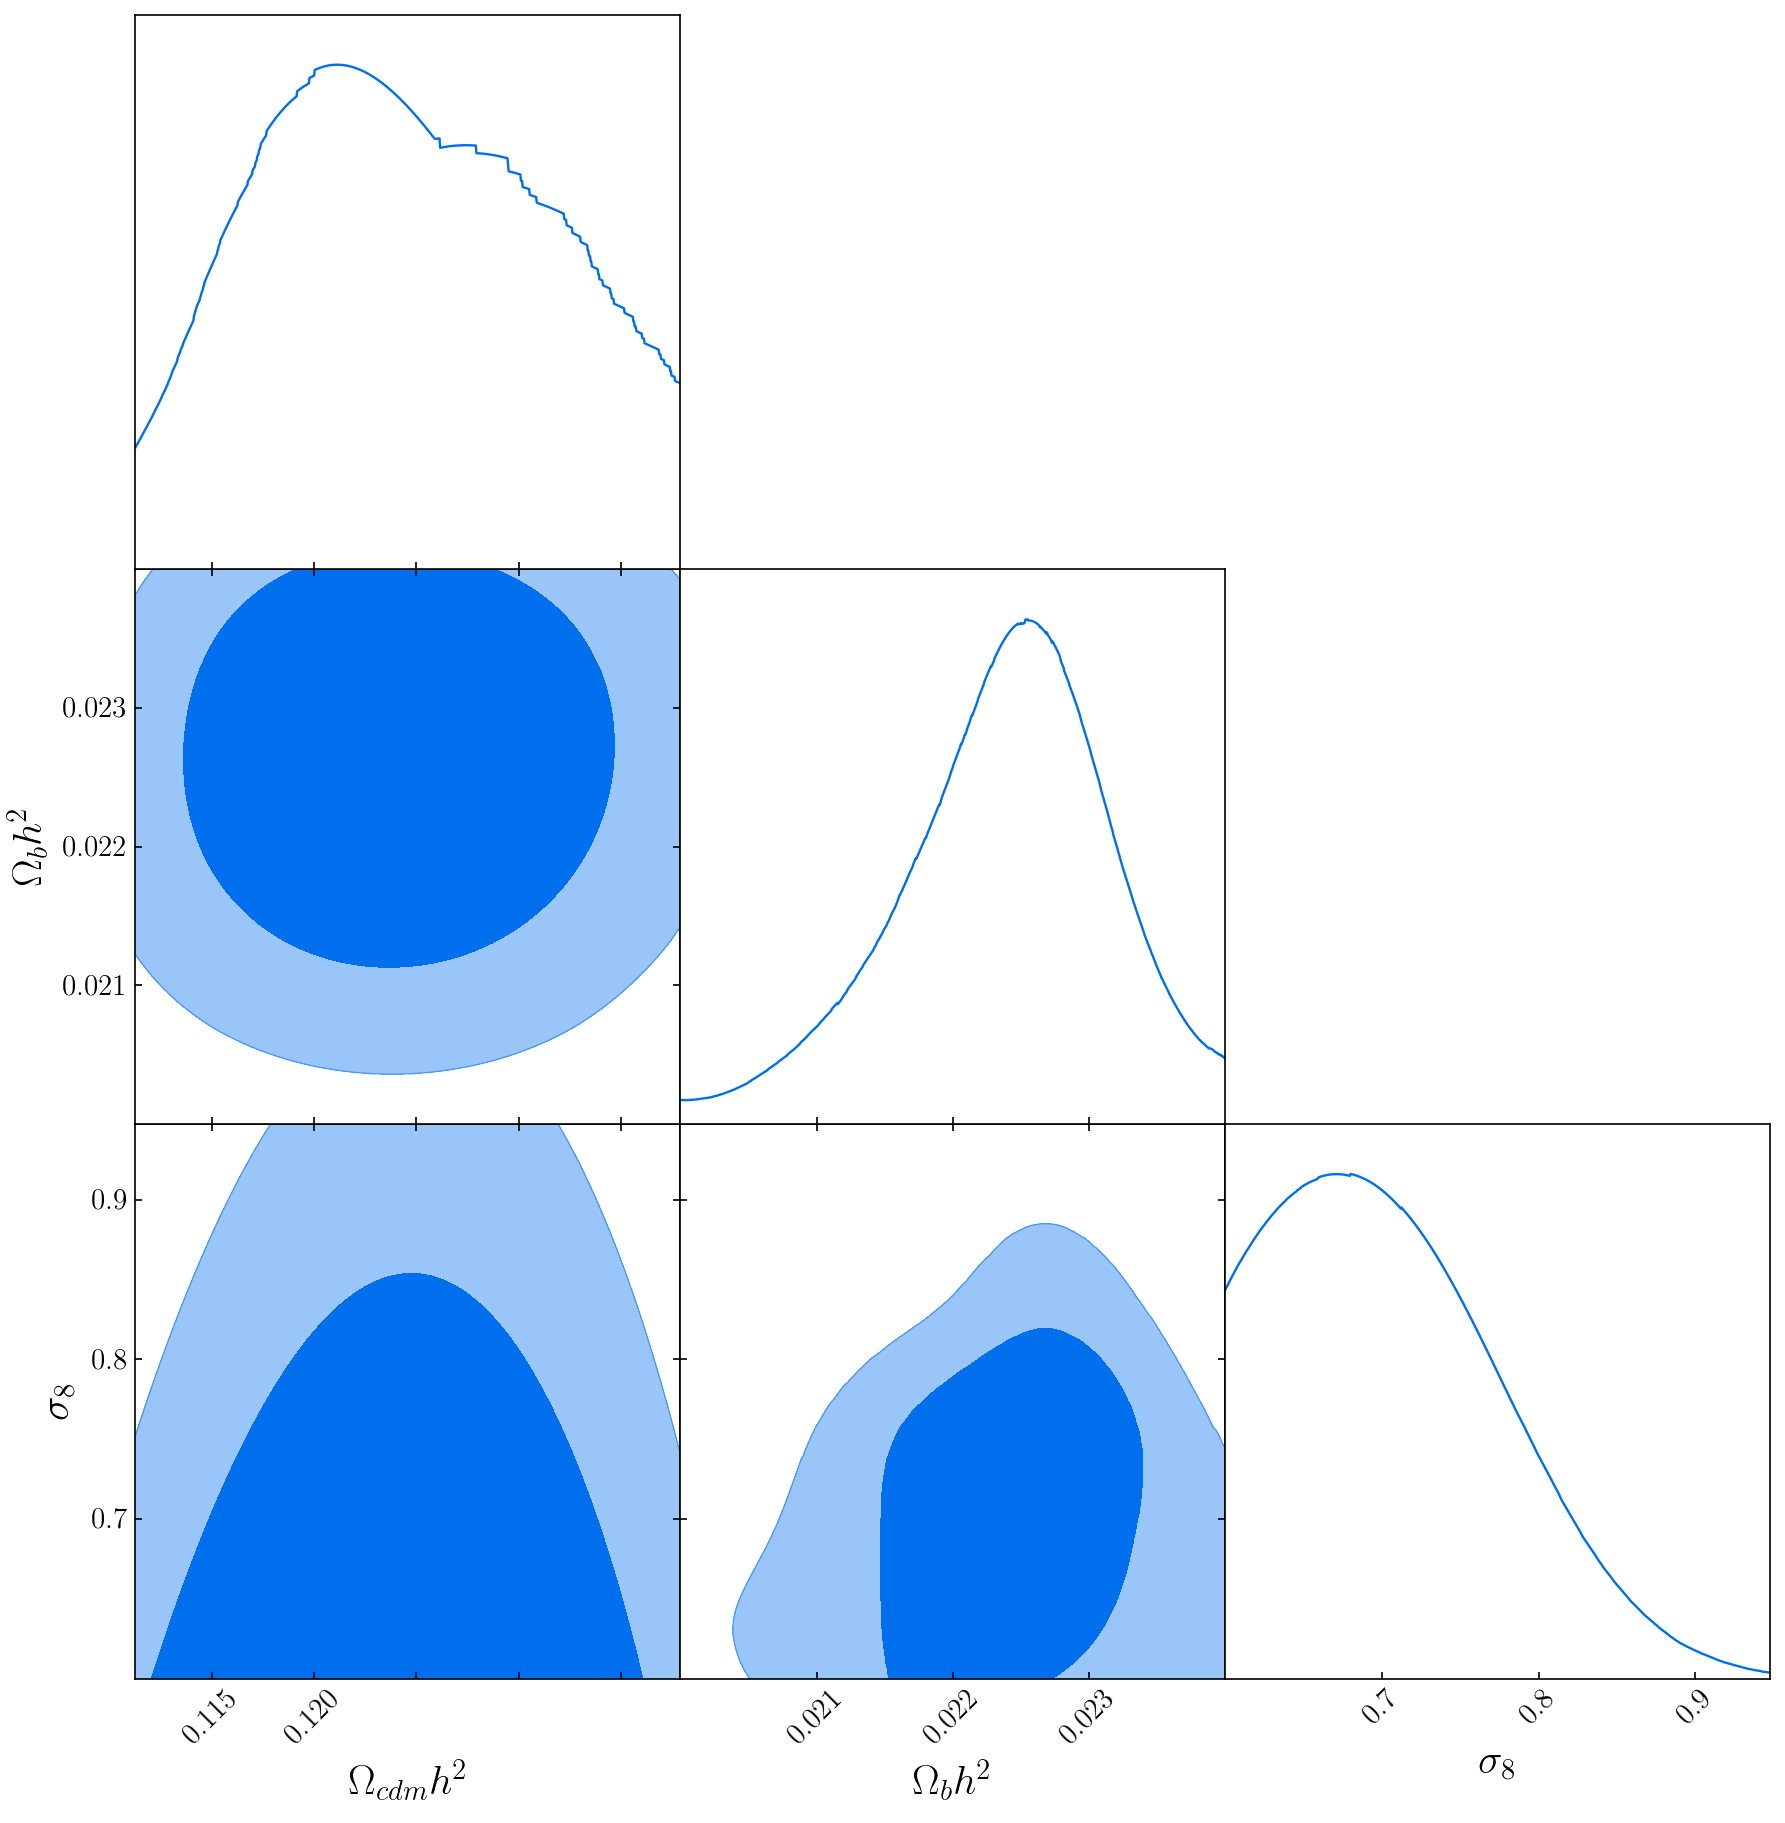

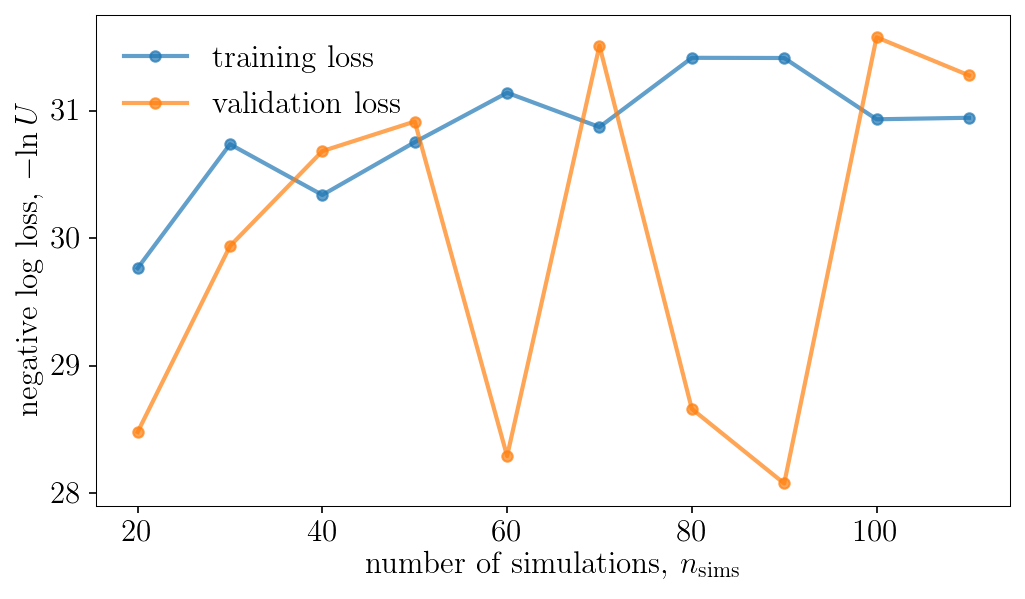

Population 18/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9815653969999403 s
total: 0.9767869429997518 s
total: 0.9792835760017624 s
total: 0.9782552739998209 s
total: 0.978042815997469 s
total: 0.9790494459994079 s
total: 0.9796259219983767 s
total: 0.986929869002779 s
total: 0.9787035059998743 s
total: 0.976125854998827 s


Sampling approximate posterior...
Done.
Removed no burn in


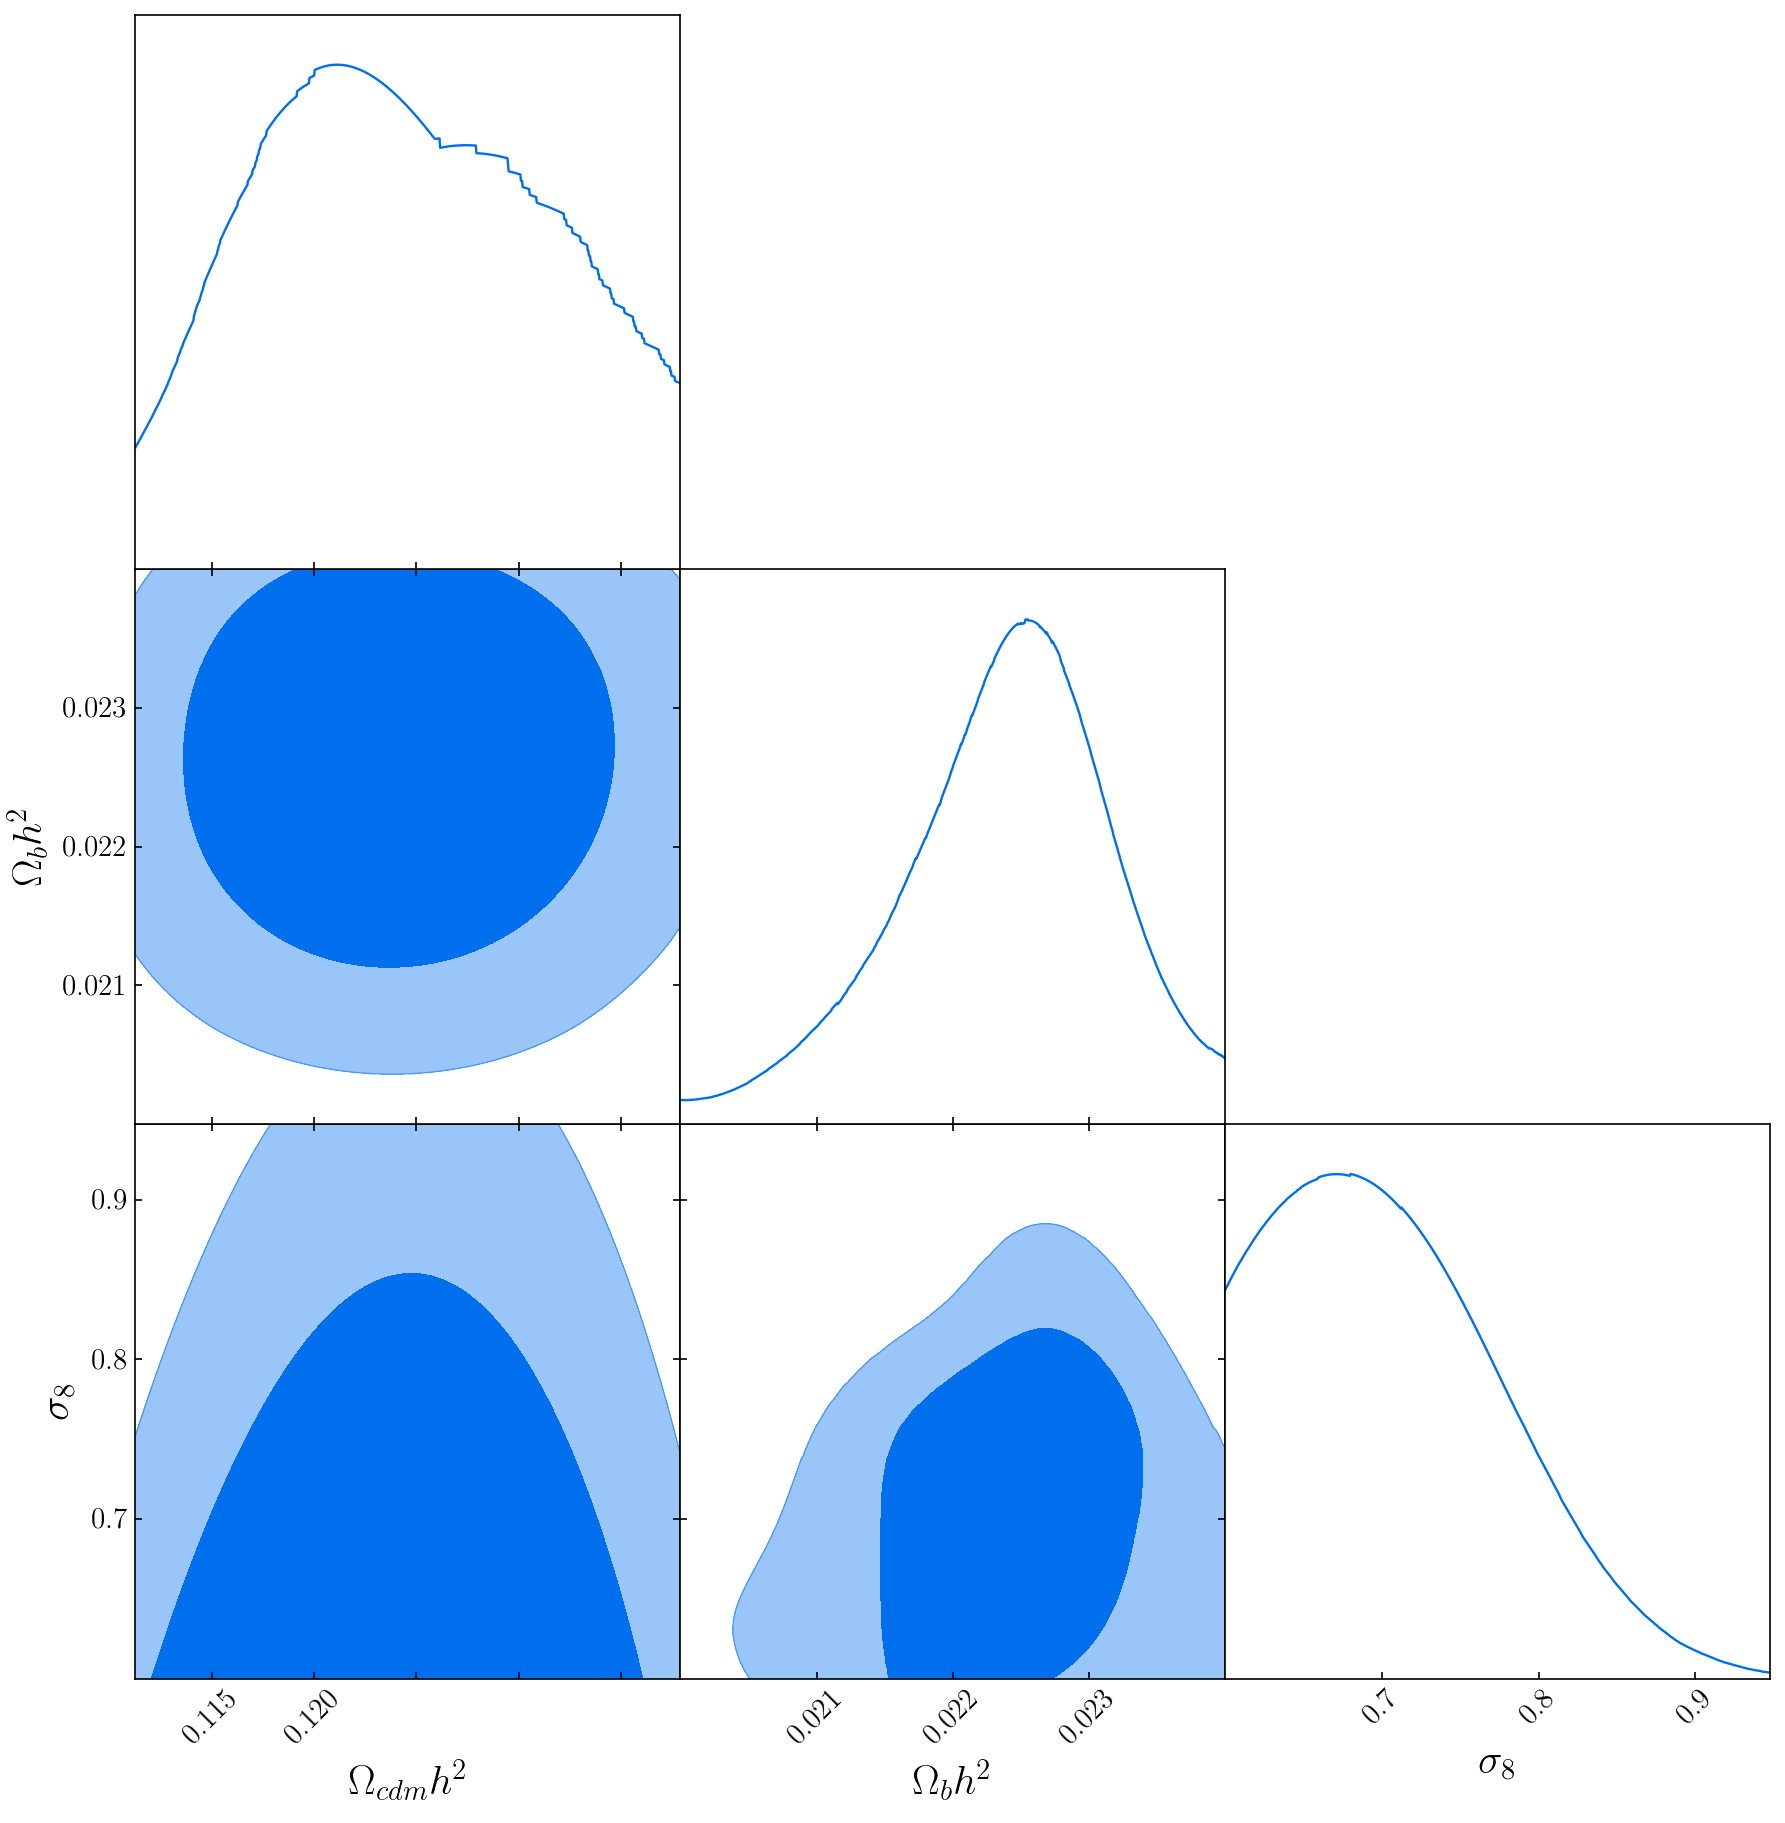

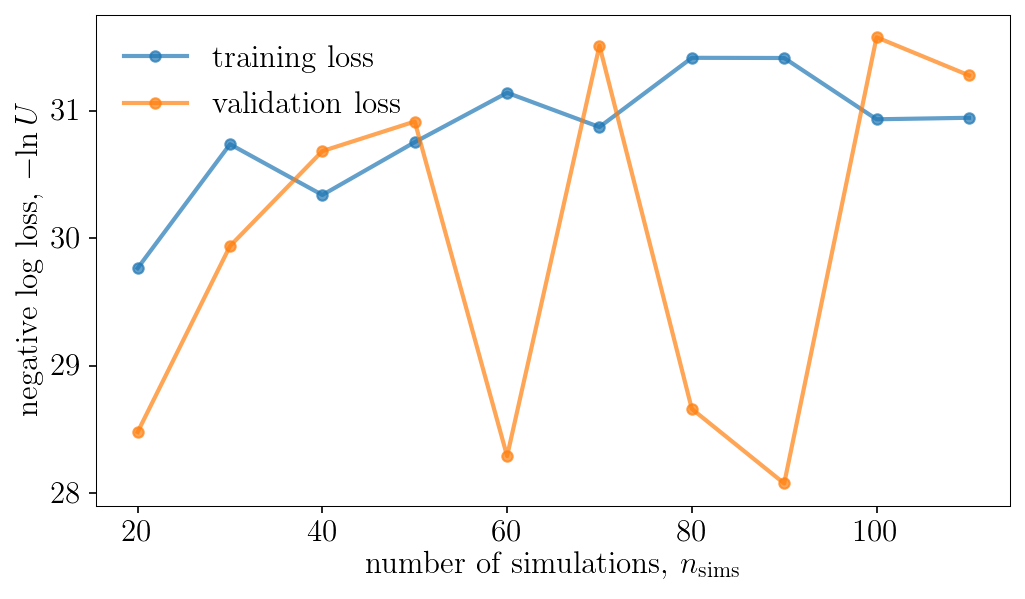

Population 19/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9929390130018874 s
total: 0.9856325500004459 s
total: 0.9855024000025878 s
total: 0.9855180129998189 s
total: 0.984661877999315 s
total: 0.9849013470011414 s
total: 0.9864317940009641 s
total: 0.9856342409984791 s
total: 0.987528788002237 s
total: 0.984491760002129 s


Sampling approximate posterior...
Done.
Removed no burn in


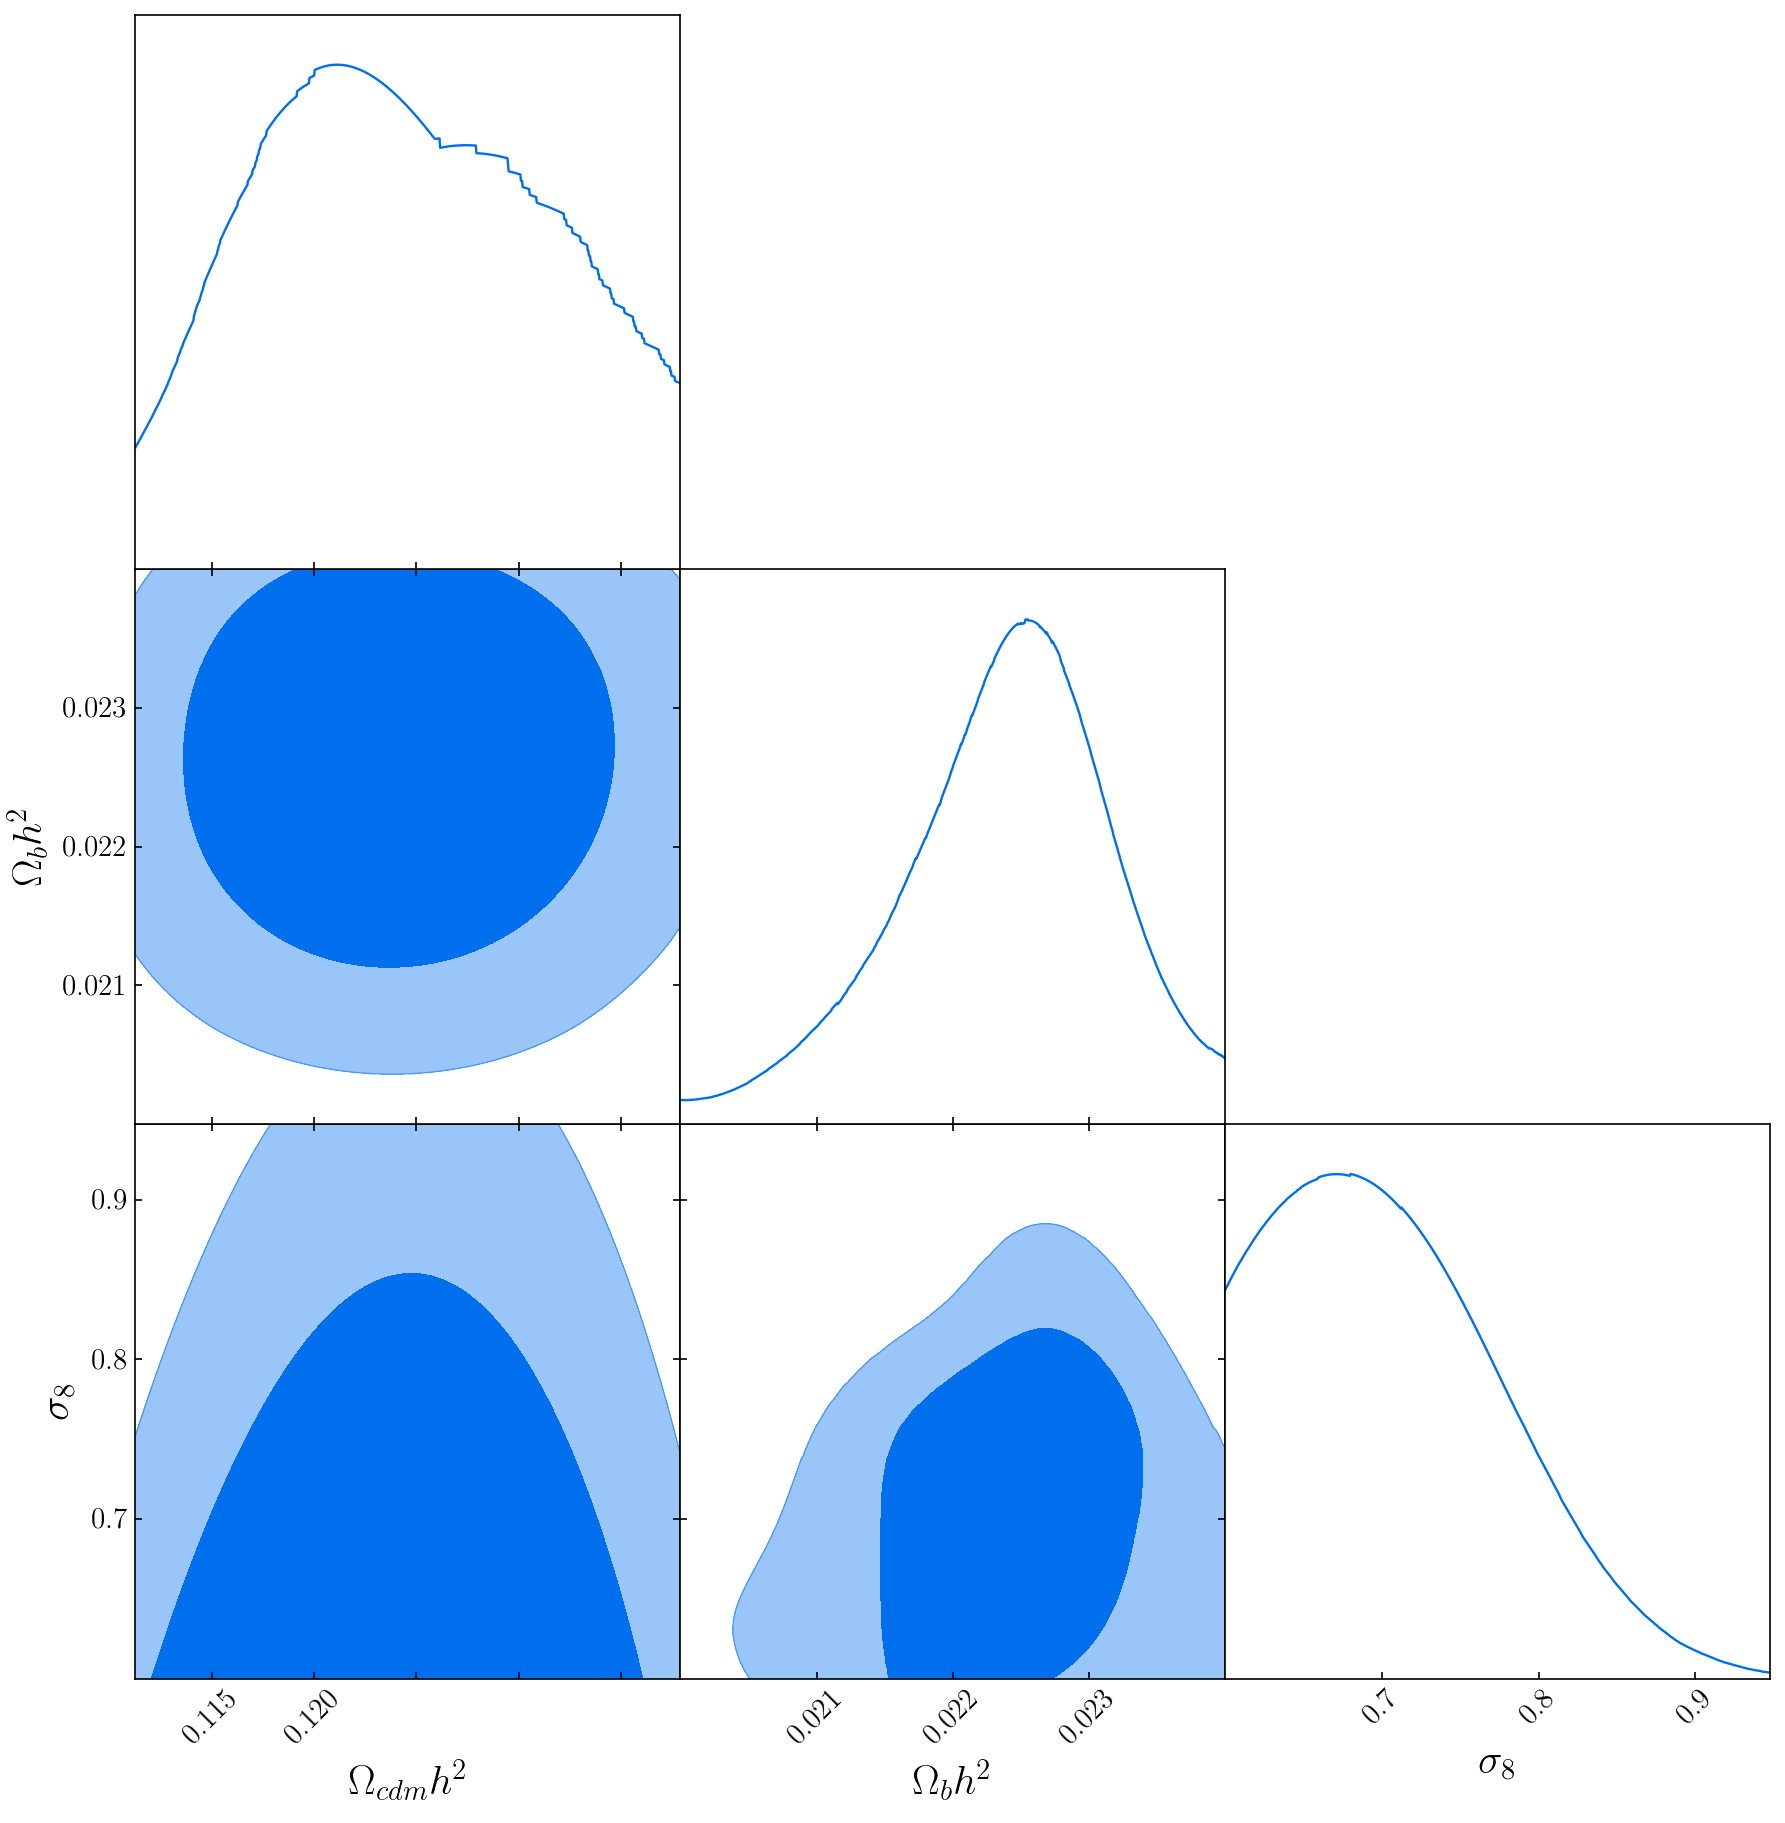

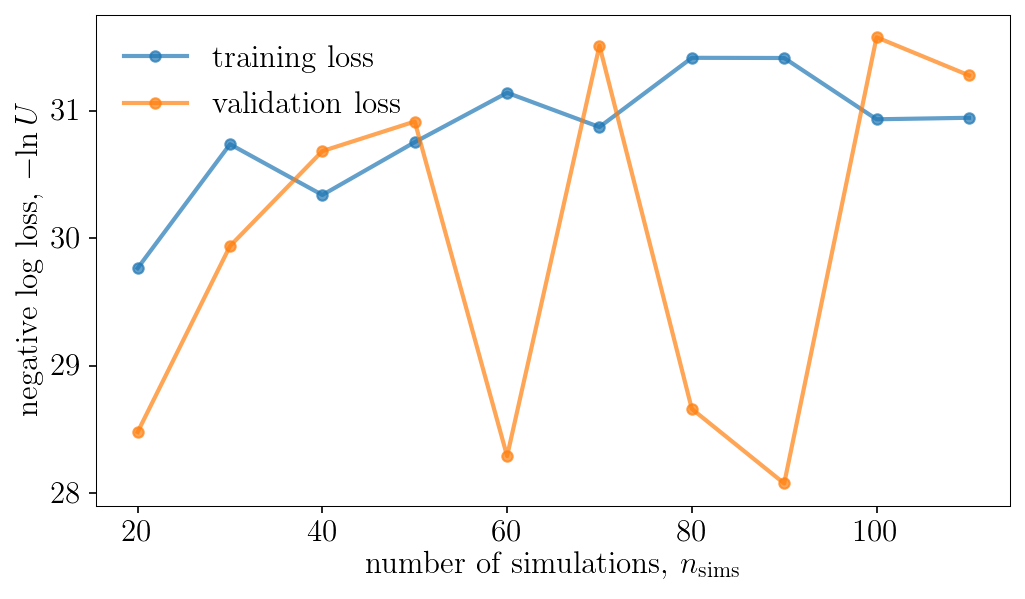

Population 20/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.9918754200007243 s
total: 0.9825988370030245 s
total: 0.9827988860015466 s
total: 0.9798853119973501 s
total: 0.9853742870000133 s
total: 0.992250912997406 s
total: 0.9945959319993563 s
total: 0.9812826390007103 s
total: 0.9855646839969268 s
total: 0.9804980340013572 s


Sampling approximate posterior...
Done.
Removed no burn in


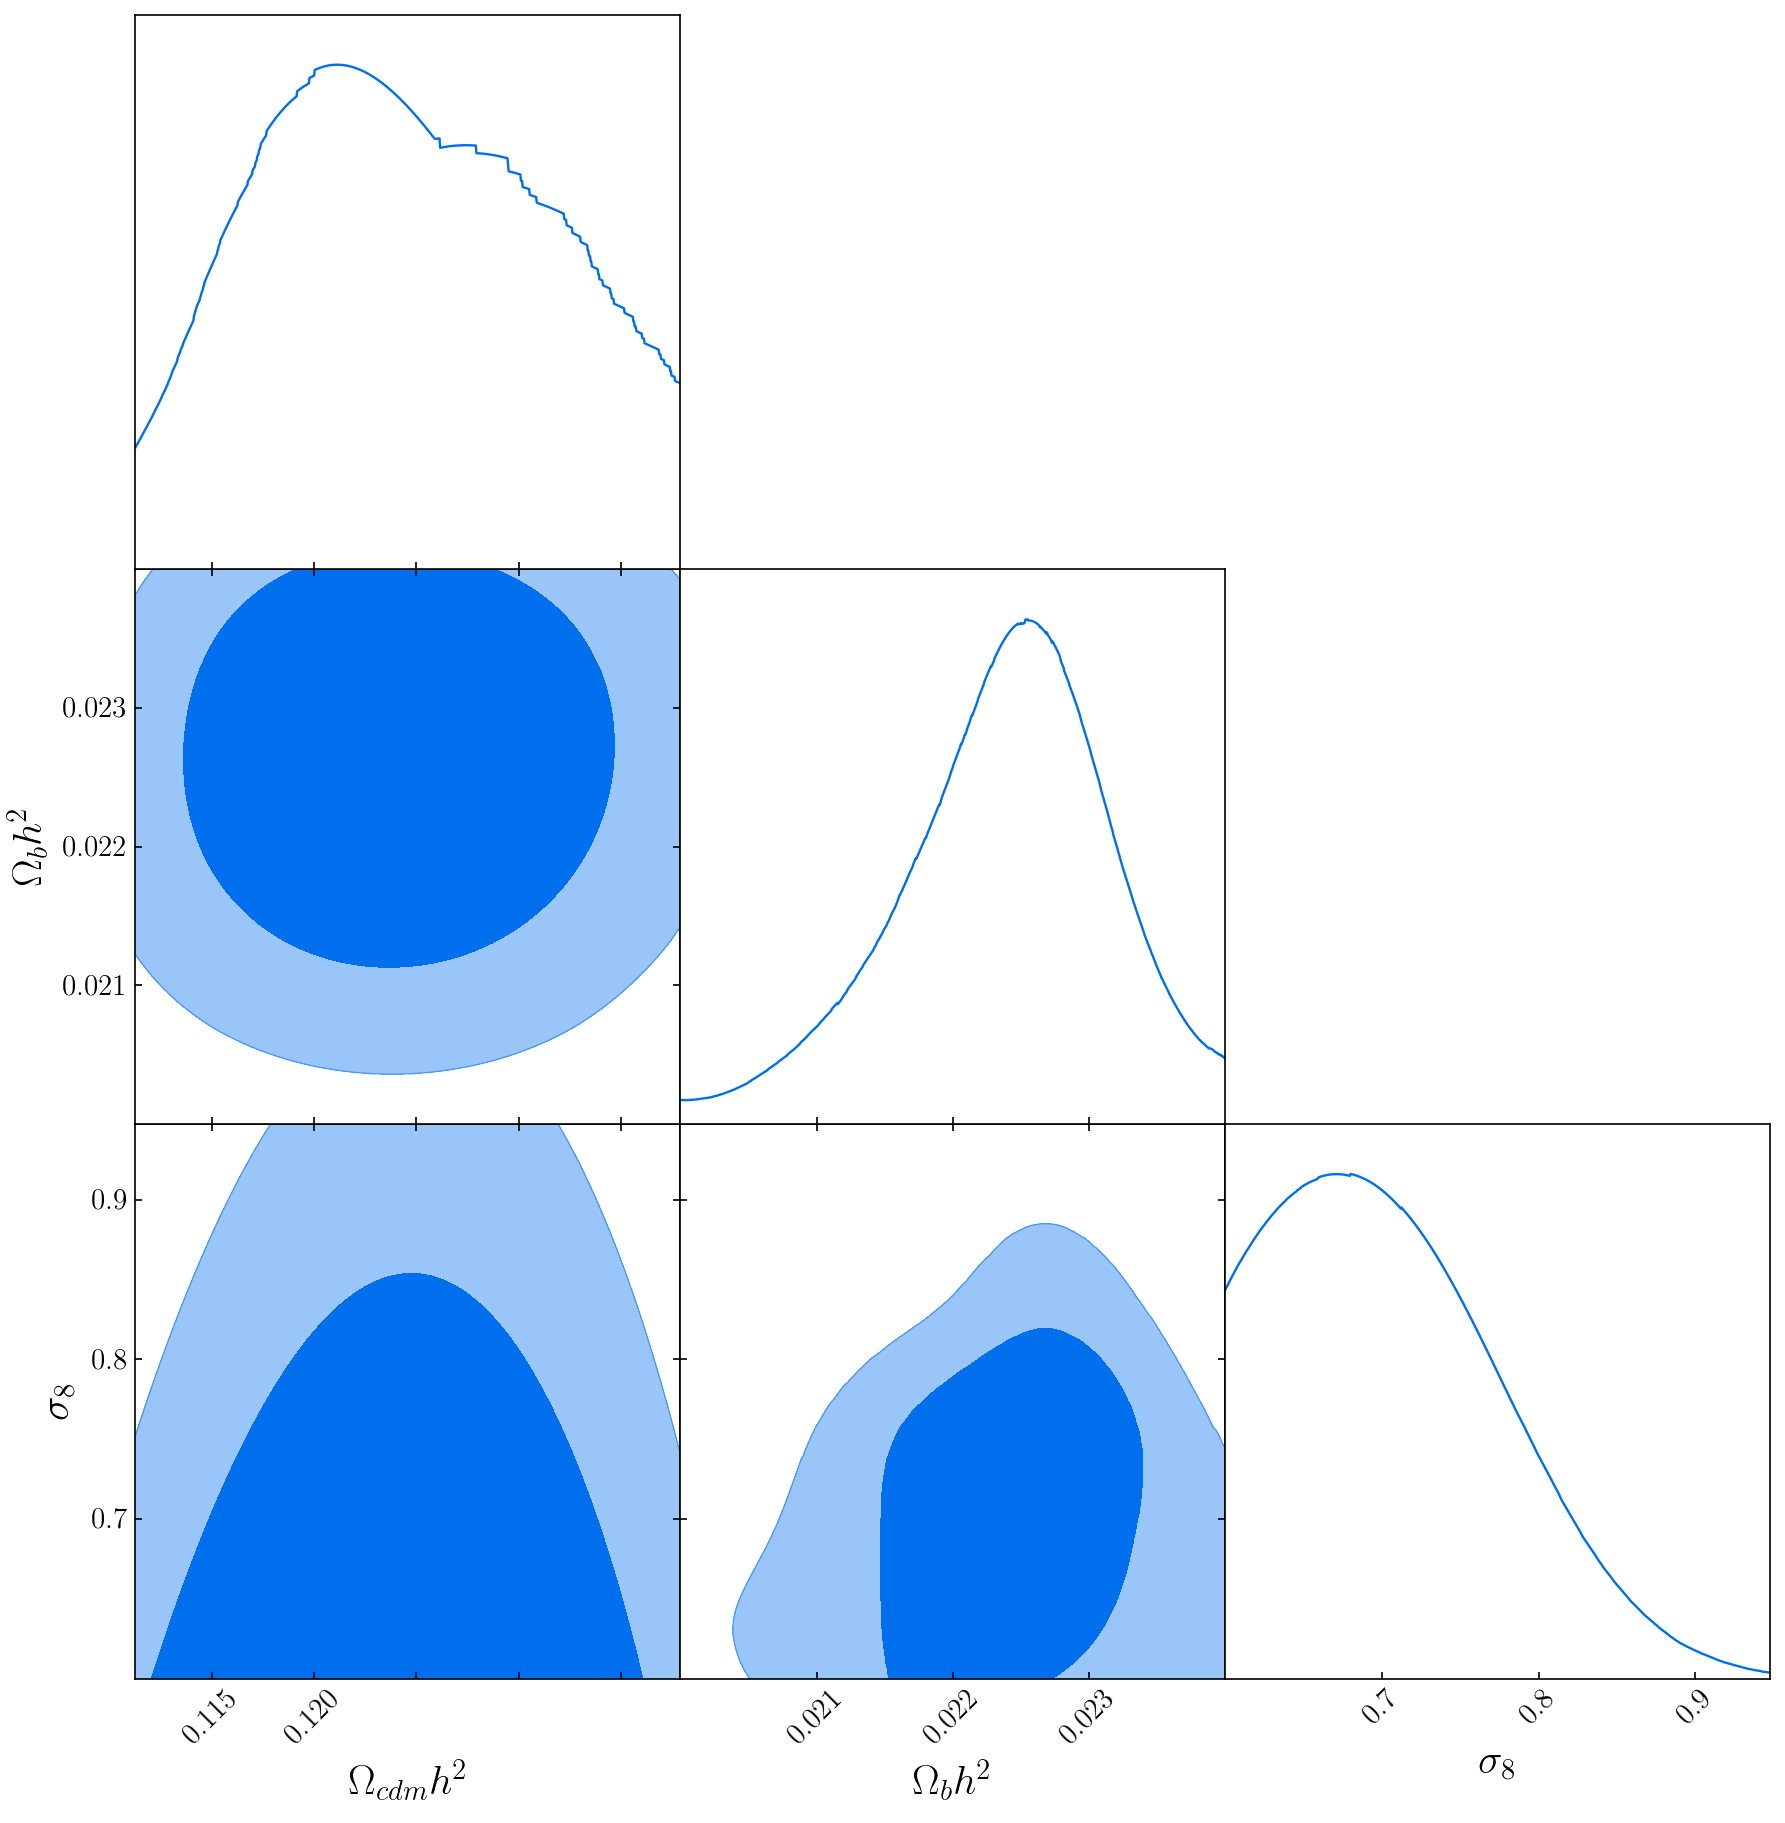

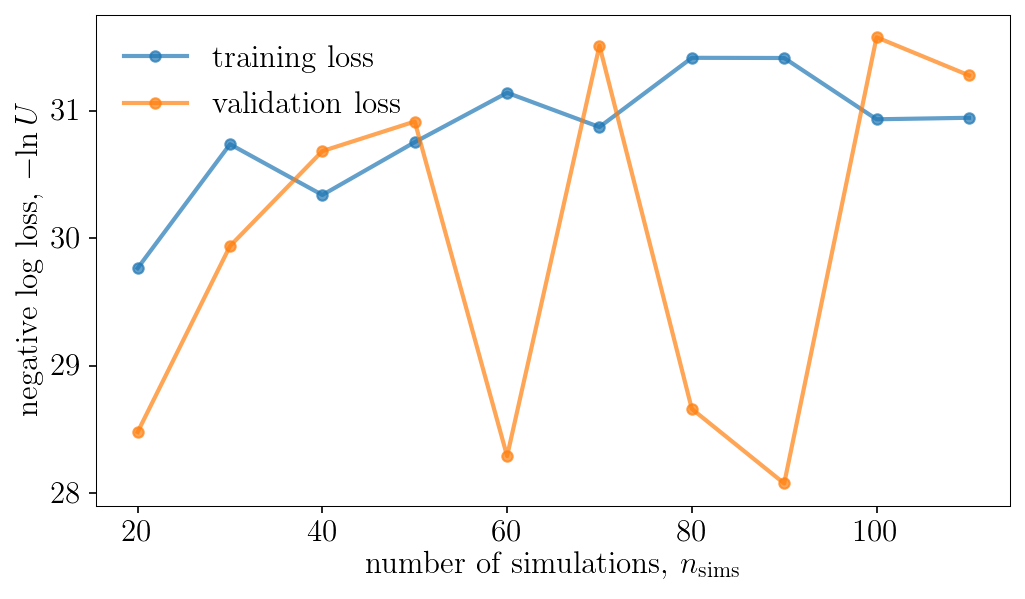

In [20]:
DelfiEnsemble2.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20)

In [21]:
x0 = DelfiEnsemble2.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble2.posterior_samples)), 
                                                       p=DelfiEnsemble2.posterior_weights.astype(np.float32)/sum(DelfiEnsemble2.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble2.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble2.emcee_sample(x0=x0)


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Removed no burn in


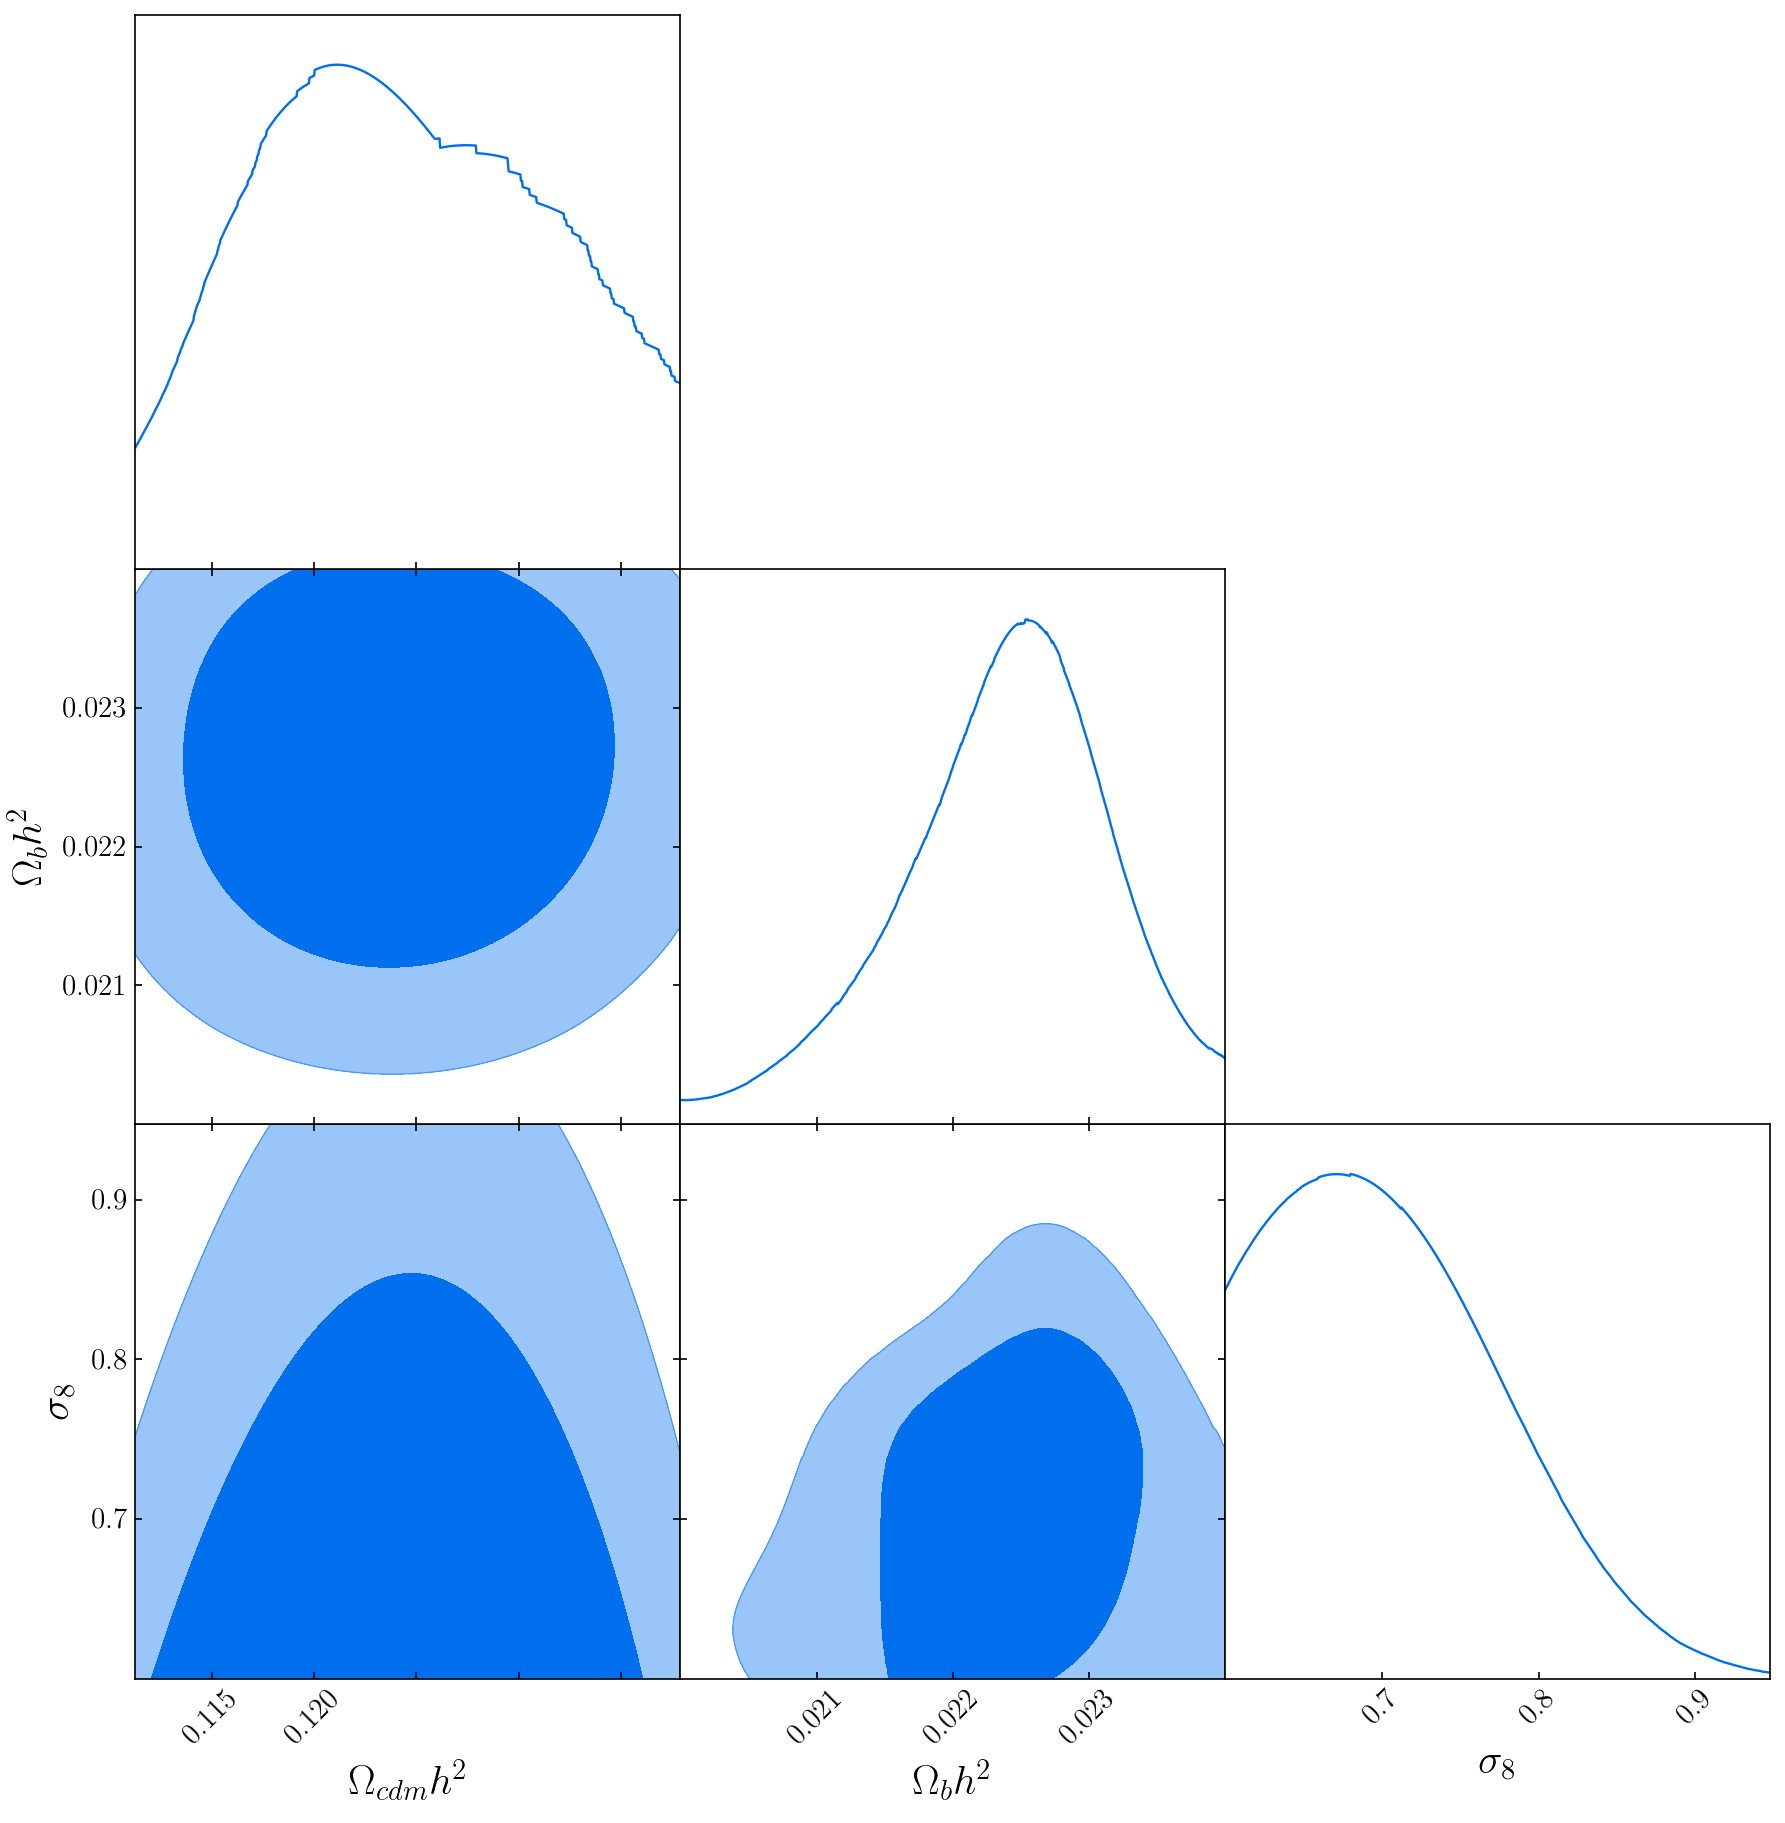

In [22]:
DelfiEnsemble2.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])


In [23]:
DelfiEnsemble2.sequential_nsims

[20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220]

In [24]:
DelfiEnsemble2.stacked_sequential_training_loss

[29.76371955871582,
 30.73604393005371,
 30.337928771972656,
 30.75222396850586,
 31.139982223510742,
 30.87104034423828,
 31.4140625,
 31.412612915039062,
 30.931732177734375,
 30.94353675842285,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [25]:
DelfiEnsemble2.stacked_sequential_validation_loss

[28.4777889251709,
 29.93720817565918,
 30.682056427001953,
 30.91415023803711,
 28.289255142211914,
 31.50938606262207,
 28.659534454345703,
 28.074914932250977,
 31.575077056884766,
 31.27631187438965,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]